In [1]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import

model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [2]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 50
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)

In [3]:
import torch
from acdc import get_pad_token

print("printing example data points:")
for b in range(10):
    pad_token = get_pad_token(model.tokenizer)
    # because there is padding if lengths vary, this only fetches the tokens that are part of the sequence
    toks = data.data[b][:data.last_token_position[b]+1]
    print(model.tokenizer.decode(toks))
    for ind, tok in enumerate(data.correct[b]):
        if tok != pad_token:
            print(f"  correct answer: {repr(model.tokenizer.decode([tok.item()]))}")
    for ind, tok in enumerate(data.incorrect[b]):
        if tok != pad_token:
            print(f"  incorrect answer: {repr(model.tokenizer.decode([tok.item()]))}")

from acdc import accuracy_metric
from acdc import ACDCEvalData
from acdc import get_pad_token
def logging_incorrect_metric(data: ACDCEvalData):
    pad_token = get_pad_token(model.tokenizer)
    for data_subset in [data.patched, data.corrupted]:
        batch, _ = data_subset.data.size()
        for b in range(batch):
            if not data_subset.top_is_correct[b].item():
                toks = data_subset.data[b][:data_subset.last_token_position[b]+1]
                print("failed on this data point:")
                print(model.tokenizer.decode(toks))
                print("correct prs:")
                for i, tok in enumerate(data_subset.correct[b]):
                    if tok.item() != pad_token:
                        print(data_subset.correct_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
                print("incorrect prs:")
                for i, tok in enumerate(data_subset.incorrect[b]):
                    if tok.item() != pad_token:
                        print(data_subset.incorrect_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
    return data.patched.top_is_correct

top_is_correct = data.eval(model=model, batch_size=10, metric=logging_incorrect_metric)
accuracy = top_is_correct.sum().item()/top_is_correct.size()[0]
print(f"accuracy: {accuracy}")


printing example data points:
<|endoftext|>Friends Brian, Lily and Diana went to the house. Brian and Lily gave a apple to
  correct answer: ' Diana'
  incorrect answer: ' Brian'
  incorrect answer: ' Donovan'
  incorrect answer: ' Lily'
<|endoftext|>Friends Brian, Lily and Donovan went to the house. Brian and Lily gave a apple to
  correct answer: ' Donovan'
  incorrect answer: ' Brian'
  incorrect answer: ' Diana'
  incorrect answer: ' Lily'
<|endoftext|>When Catherine, Jordan and Owen arrived at the office, Catherine and Owen gave a apple to
  correct answer: ' Jordan'
  incorrect answer: ' Catherine'
  incorrect answer: ' Henry'
  incorrect answer: ' Owen'
<|endoftext|>When Catherine, Henry and Owen arrived at the office, Catherine and Owen gave a apple to
  correct answer: ' Henry'
  incorrect answer: ' Catherine'
  incorrect answer: ' Jordan'
  incorrect answer: ' Owen'
<|endoftext|>When Edwin, Miranda and Marco arrived at the office, Miranda and Marco gave a kiss to
  correct an

all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 0 edges, keeping 0 edges, 1225 remain
patching 0 edges, keeping 0 edges, 1225 remain
baseline score 2.651578664779663
[49] sized edge sets remaining
got scores tensor([1.6466e-07], device='cuda:0')
splitting 49 edges into two edge sets, as they have score 1.646648115638527e-07 which has diff 2.651578426361084 > 1e-05
patching 0 edges, keeping 0 edges, 1225 remain
baseline score 2.651578664779663
[24, 25] sized edge sets remaining
got scores tensor([2.6515e+00, 9.6757e-05], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.651517868041992 which has diff 6.079673767089844e-05 > 1e-05
splitting 25 edges into two edge sets, as they have score 9.675651

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7001, 2.6999, 2.6999, 2.7002, 2.6198, 2.6724, 2.7079, 0.4702, 2.6747,
        2.3683], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.6998884677886963 which has diff 0.0001621246337890625 > 1e-05
keeping edge edge  14 -> output (('blocks.14.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.699887752532959 which has diff 0.0001628398895263672 > 1e-05
keeping edge edge  35 -> output (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.619821786880493 which has diff 0.08022880554199219 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.672353982925415 which has diff 0.027696609497070312 > 1e-05
splitting 2 edges into two edge sets, as they have score 0.47024503350257874 which has diff 2.2298054695129395 

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7080, 2.7078, 2.6794, 2.7089, 0.5256, 2.6608, 2.7175, 2.6732, 2.6373,
        2.4477], device='cuda:0')
keeping edge edge  13 -> output (('blocks.13.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.707810640335083 which has diff 0.00014162063598632812 > 1e-05
keeping edge edge  36 -> output (('blocks.36.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.6793603897094727 which has diff 0.02859187126159668 > 1e-05
keeping edge edge  39 -> output (('blocks.39.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 0.5256035327911377 which has diff 2.1823487281799316 > 1e-05
keeping edge edge  40 -> output (('blocks.40.hook_out_proj', <function storage_hook at 0

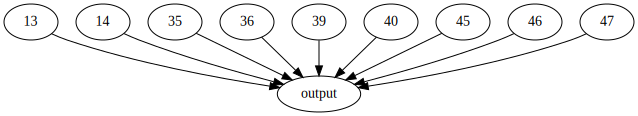

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 0.pkl
patching 40 edges, keeping 9 edges, 1176 remain
patching 40 edges, keeping 9 edges, 1176 remain
baseline score 2.718270778656006
[48] sized edge sets remaining
got scores tensor([2.4578], device='cuda:0')
splitting 48 edges into two edge sets, as they have score 2.457807779312134 which has diff 0.26046299934387207 > 1e-05
patching 40 edges, keeping 9 edges, 1176 remain
baseline score 2.718270778656006
[24, 24] sized edge sets remaining
got scores tensor([2.7184, 2.4578], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.4577791690826416 which has diff 0.26049160957336426 > 1e-05
doing rollback test with score 2.7184154987335205 and score_lost_by_edge_set -0.00014472007751464844 with edge set of size 24
rolling back with pivot 1
patching 24 edges with score 2.7184154987335205 with diff of -0.00014472007751464844
but patching with others at the same time, overall they have score 2.7183709144592285 w

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7222, 2.7223, 2.7060, 2.7248, 2.7251, 2.4822, 2.7190, 2.7171],
       device='cuda:0')
keeping edge edge  32 -> 47 (('blocks.32.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7222366333007812 which has diff 0.0008096694946289062 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.722339391708374 which has diff 0.0007069110870361328 > 1e-05
keeping edge edge  35 -> 47 (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.705994129180908 which has diff 0.017052173614501953 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.482245922088623 which has diff 0.2408003807067871 > 1e-05
keeping edge edge  44 -> 47 (('blocks.44.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_layer_input', <

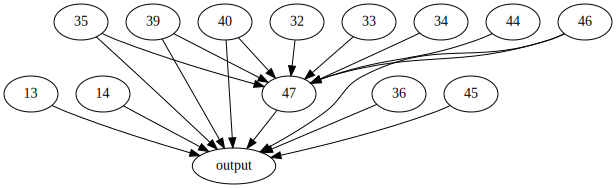

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 1.pkl
patching 80 edges, keeping 17 edges, 1128 remain
patching 80 edges, keeping 17 edges, 1128 remain
baseline score 2.727365016937256
[47] sized edge sets remaining
got scores tensor([2.6500], device='cuda:0')
splitting 47 edges into two edge sets, as they have score 2.6499931812286377 which has diff 0.07737183570861816 > 1e-05
patching 80 edges, keeping 17 edges, 1128 remain
baseline score 2.727365016937256
[23, 24] sized edge sets remaining
got scores tensor([2.7277, 2.6498], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.64979887008667 which has diff 0.07756614685058594 > 1e-05
doing rollback test with score 2.727689743041992 and score_lost_by_edge_set -0.0003247261047363281 with edge set of size 23
rolling back with pivot 1
patching 23 edges with score 2.727689743041992 with diff of -0.0003247261047363281
but patching with others at the same time, overall they have score 2.7276430130004883 wit

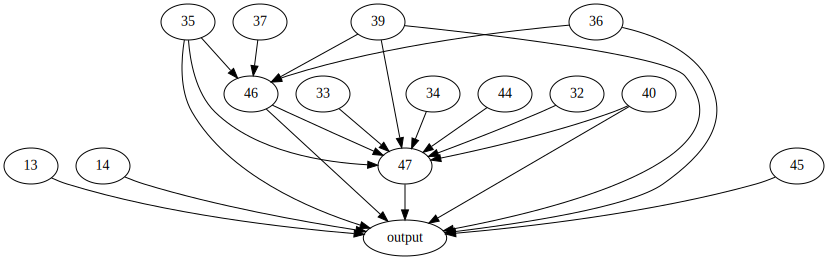

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 2.pkl
patching 123 edges, keeping 21 edges, 1081 remain
patching 123 edges, keeping 21 edges, 1081 remain
baseline score 2.730192184448242
[46] sized edge sets remaining
got scores tensor([2.6950], device='cuda:0')
splitting 46 edges into two edge sets, as they have score 2.695035457611084 which has diff 0.0351567268371582 > 1e-05
patching 123 edges, keeping 21 edges, 1081 remain
baseline score 2.730192184448242
[23, 23] sized edge sets remaining
got scores tensor([2.7299, 2.6955], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 2.7298717498779297 which has diff 0.0003204345703125 > 1e-05
splitting 23 edges into two edge sets, as they have score 2.695518732070923 which has diff 0.034673452377319336 > 1e-05
patching 123 edges, keeping 21 edges, 1081 remain
baseline score 2.730192184448242
[11, 12, 11, 12] sized edge sets remaining
got scores tensor([2.7304, 2.7297, 2.7301, 2.6954], device='cuda:0')
split

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7304, 2.7308, 2.7305, 2.7305, 2.7302, 2.7209, 2.7089, 2.7286],
       device='cuda:0')
splitting 3 edges into two edge sets, as they have score 2.7303872108459473 which has diff 0.00038433074951171875 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.7305409908294678 which has diff 0.00023055076599121094 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7304766178131104 which has diff 0.0002949237823486328 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7302398681640625 which has diff 0.0005316734313964844 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.720851182937622 which has diff 0.009920358657836914 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7088823318481445 which has diff 0.021889209747314453 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7286040782928467 which has diff 0.0021674633026123047 > 1e-05
doing rollback test with score 2.7308218479156

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.7308, 2.7304, 2.7307, 2.7306, 2.7306, 2.7307, 2.7307, 2.7303, 2.7290,
        2.7226, 2.7079, 2.7304, 2.7329, 2.7264], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.730363130569458 which has diff 0.00040411949157714844 > 1e-05
keeping edge edge  22 -> 45 (('blocks.22.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7307021617889404 which has diff 6.508827209472656e-05 > 1e-05
keeping edge edge  23 -> 45 (('blocks.23.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7306480407714844 which has diff 0.00011920928955078125 > 1e-05
keeping edge edge  24 -> 45 (('blocks.24.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7326, 2.7329, 2.7329, 2.7329, 2.7334, 2.7319, 2.7319, 2.7258, 2.7323,
        2.7330, 2.7307, 2.7309], device='cuda:0')
keeping edge edge  17 -> 45 (('blocks.17.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7325551509857178 which has diff 0.0003559589385986328 > 1e-05
keeping edge edge  35 -> 45 (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.731937885284424 which has diff 0.0009732246398925781 > 1e-05
keeping edge edge  37 -> 45 (('blocks.37.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.731912851333618 which has diff 0.0009982585906982422 > 1e-05
keeping edge edge  38 -> 45 (('blocks.38.hook_out_proj', <function storage_hoo

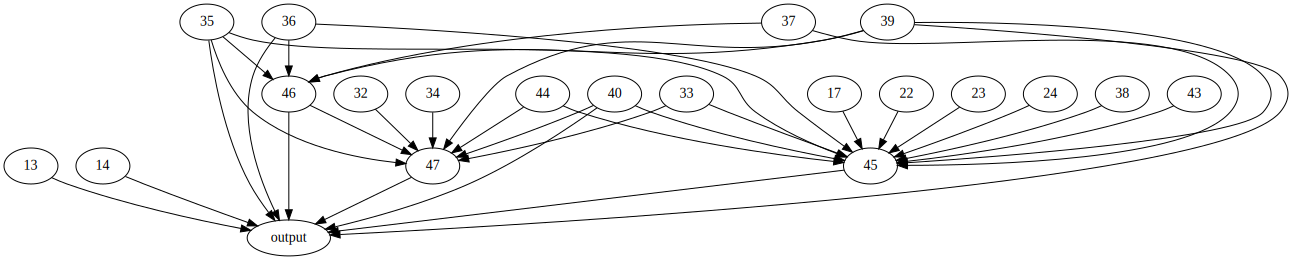

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 3.pkl
patching 156 edges, keeping 34 edges, 1035 remain
patching 156 edges, keeping 34 edges, 1035 remain
baseline score 2.7333104610443115
[45] sized edge sets remaining
got scores tensor([2.7272], device='cuda:0')
splitting 45 edges into two edge sets, as they have score 2.727161407470703 which has diff 0.0061490535736083984 > 1e-05
patching 156 edges, keeping 34 edges, 1035 remain
baseline score 2.7333104610443115
[22, 23] sized edge sets remaining
got scores tensor([2.7337, 2.7268], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 2.72684383392334 which has diff 0.00646662712097168 > 1e-05
doing rollback test with score 2.7336599826812744 and score_lost_by_edge_set -0.0003495216369628906 with edge set of size 22
rolling back with pivot 1
patching 22 edges with score 2.7336599826812744 with diff of -0.0003495216369628906
but patching with others at the same time, overall they have score 2.733613014221

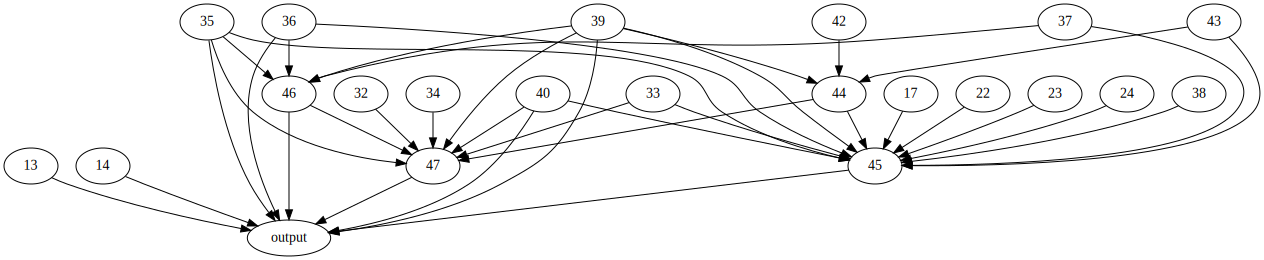

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 4.pkl
patching 198 edges, keeping 37 edges, 990 remain
patching 198 edges, keeping 37 edges, 990 remain
baseline score 2.7411577701568604
[44] sized edge sets remaining
got scores tensor([2.7378], device='cuda:0')
splitting 44 edges into two edge sets, as they have score 2.737790822982788 which has diff 0.0033669471740722656 > 1e-05
patching 198 edges, keeping 37 edges, 990 remain
baseline score 2.7411577701568604
[22, 22] sized edge sets remaining
got scores tensor([2.7414, 2.7376], device='cuda:0')
splitting 22 edges into two edge sets, as they have score 2.737604856491089 which has diff 0.0035529136657714844 > 1e-05
doing rollback test with score 2.741441011428833 and score_lost_by_edge_set -0.00028324127197265625 with edge set of size 22
rolling back with pivot 1
patching 22 edges with score 2.741441011428833 with diff of -0.00028324127197265625
but patching with others at the same time, overall they have score 2.741394042968

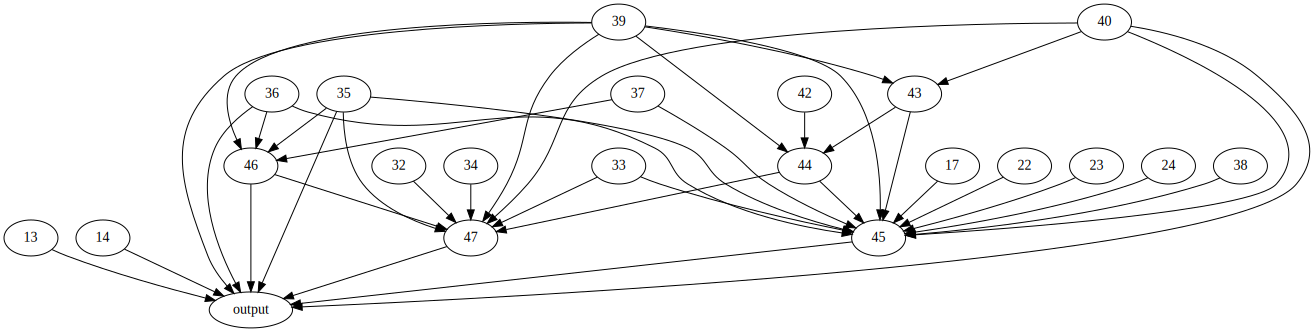

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 5.pkl
patching 240 edges, keeping 39 edges, 946 remain
patching 240 edges, keeping 39 edges, 946 remain
baseline score 2.7439935207366943
[43] sized edge sets remaining
got scores tensor([2.7429], device='cuda:0')
splitting 43 edges into two edge sets, as they have score 2.742877721786499 which has diff 0.0011157989501953125 > 1e-05
patching 240 edges, keeping 39 edges, 946 remain
baseline score 2.7439935207366943
[21, 22] sized edge sets remaining
got scores tensor([2.7440, 2.7430], device='cuda:0')
splitting 21 edges into two edge sets, as they have score 2.7439653873443604 which has diff 2.8133392333984375e-05 > 1e-05
splitting 22 edges into two edge sets, as they have score 2.742985486984253 which has diff 0.0010080337524414062 > 1e-05
patching 240 edges, keeping 39 edges, 946 remain
baseline score 2.7439935207366943
[10, 11, 11, 11] sized edge sets remaining
got scores tensor([2.7441, 2.7440, 2.7443, 2.7427], device='cuda:0'

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7442, 2.7442, 2.7444, 2.7438, 2.7442, 2.7438, 2.7448, 2.7433, 2.7443,
        2.7442], device='cuda:0')
keeping edge edge  32 -> 42 (('blocks.32.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.744208574295044 which has diff 1.3589859008789062e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.743786573410034 which has diff 0.0004355907440185547 > 1e-05
keeping edge edge  36 -> 42 (('blocks.36.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7441935539245605 which has diff 2.86102294921875e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.743791341781616 which has diff 0.00043082237243652344 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.7433128356933594 which has diff 0.0009093284606933594 

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7448, 2.7446, 2.7447, 2.7446, 2.7444, 2.7444, 2.7449, 2.7448],
       device='cuda:0')
keeping edge edge  34 -> 42 (('blocks.34.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7447755336761475 which has diff 5.507469177246094e-05 > 1e-05
keeping edge edge  35 -> 42 (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.744565725326538 which has diff 0.00026488304138183594 > 1e-05
keeping edge edge  37 -> 42 (('blocks.37.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7447381019592285 which has diff 9.250640869140625e-05 > 1e-05
keeping edge edge  38 -> 42 (('blocks.38.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('bloc

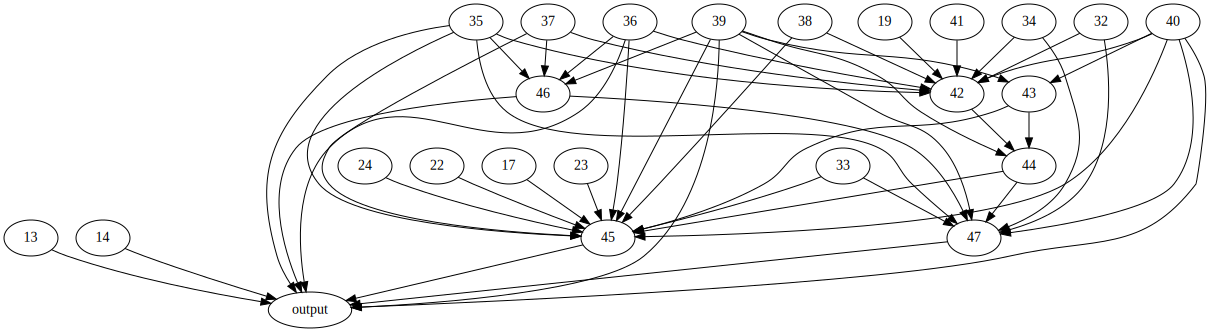

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 6.pkl
patching 274 edges, keeping 48 edges, 903 remain
patching 274 edges, keeping 48 edges, 903 remain
baseline score 2.7448134422302246
[42] sized edge sets remaining
got scores tensor([2.7444], device='cuda:0')
splitting 42 edges into two edge sets, as they have score 2.744372606277466 which has diff 0.00044083595275878906 > 1e-05
patching 274 edges, keeping 48 edges, 903 remain
baseline score 2.7448134422302246
[21, 21] sized edge sets remaining
got scores tensor([2.7449, 2.7444], device='cuda:0')
splitting 21 edges into two edge sets, as they have score 2.744415521621704 which has diff 0.0003979206085205078 > 1e-05
doing rollback test with score 2.7448692321777344 and score_lost_by_edge_set -5.5789947509765625e-05 with edge set of size 21
rolling back with pivot 1
patching 21 edges with score 2.7448692321777344 with diff of -5.5789947509765625e-05
but patching with others at the same time, overall they have score 2.744823217

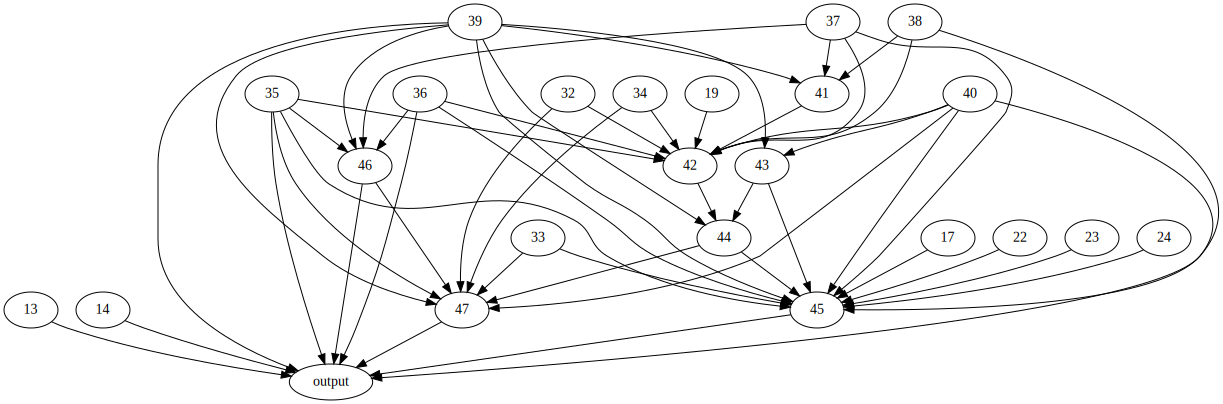

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 7.pkl
patching 313 edges, keeping 51 edges, 861 remain
patching 313 edges, keeping 51 edges, 861 remain
baseline score 2.744816541671753
[41] sized edge sets remaining
got scores tensor([2.6931], device='cuda:0')
splitting 41 edges into two edge sets, as they have score 2.693138360977173 which has diff 0.05167818069458008 > 1e-05
patching 313 edges, keeping 51 edges, 861 remain
baseline score 2.744816541671753
[20, 21] sized edge sets remaining
got scores tensor([2.7297, 2.7095], device='cuda:0')
splitting 20 edges into two edge sets, as they have score 2.729722738265991 which has diff 0.015093803405761719 > 1e-05
splitting 21 edges into two edge sets, as they have score 2.709479331970215 which has diff 0.035337209701538086 > 1e-05
patching 313 edges, keeping 51 edges, 861 remain
baseline score 2.744816541671753
[10, 10, 10, 11] sized edge sets remaining
got scores tensor([2.7342, 2.7415, 2.7464, 2.7087], device='cuda:0')
splitti

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7361, 2.7462, 2.7461, 2.7456, 2.7461, 2.7457, 2.7458, 2.7442, 2.7457,
        2.7457, 2.7438, 2.7173], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.736055612564087 which has diff 0.01028895378112793 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7461671829223633 which has diff 0.0001773834228515625 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.746053457260132 which has diff 0.0002911090850830078 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7456445693969727 which has diff 0.0006999969482421875 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.746096134185791 which has diff 0.0002484321594238281 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.745737314224243 which has diff 0.0006072521209716797 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.745789051055908 which has diff 0.0005555152893066406 > 1e-05
splitting 3 edges i

  0%|          | 0/8 [00:00<?, ?it/s]

got scores tensor([2.7421, 2.7405, 2.7464, 2.7462, 2.7465, 2.7460, 2.7461, 2.7459, 2.7463,
        2.7462, 2.7462, 2.7459, 2.7465, 2.7457, 2.7455, 2.7450, 2.7459, 2.7462,
        2.7468, 2.7454, 2.7462, 2.7441, 2.7434, 2.7208], device='cuda:0')
keeping edge edge  input -> 40 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7420942783355713 which has diff 0.004250288009643555 > 1e-05
keeping edge edge  0 -> 40 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.740471124649048 which has diff 0.005873441696166992 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.746166229248047 which has diff 0.00017833709716796875 > 1e-05
keeping edge edge  5 -> 40 (('blocks.5.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.40.hook_layer_inp

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.7469, 2.7466, 2.7466, 2.7466, 2.7464, 2.7468, 2.7464, 2.7459, 2.7476,
        2.7450, 2.7464, 2.7451, 2.7420, 2.7265], device='cuda:0')
keeping edge edge  3 -> 40 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.746560573577881 which has diff 0.00023674964904785156 > 1e-05
keeping edge edge  7 -> 40 (('blocks.7.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7466235160827637 which has diff 0.00017380714416503906 > 1e-05
keeping edge edge  8 -> 40 (('blocks.8.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7465856075286865 which has diff 0.0002117156982421875 > 1e-05
keeping edge edge  12 -> 40 (('blocks.12.hook_out_proj', <functio

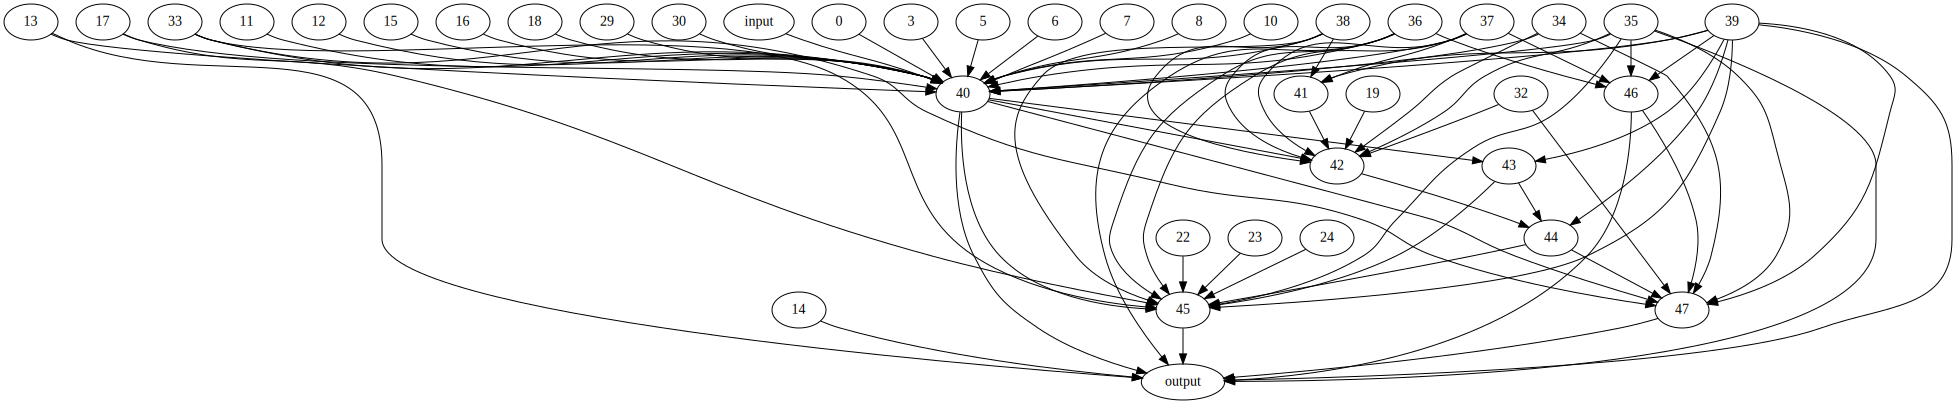

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 8.pkl
patching 330 edges, keeping 75 edges, 820 remain
patching 330 edges, keeping 75 edges, 820 remain
baseline score 2.7475554943084717
[40] sized edge sets remaining
got scores tensor([0.1671], device='cuda:0')
splitting 40 edges into two edge sets, as they have score 0.16707563400268555 which has diff 2.580479860305786 > 1e-05
patching 330 edges, keeping 75 edges, 820 remain
baseline score 2.7475554943084717
[20, 20] sized edge sets remaining
got scores tensor([1.1470, 1.7907], device='cuda:0')
splitting 20 edges into two edge sets, as they have score 1.1469563245773315 which has diff 1.6005991697311401 > 1e-05
splitting 20 edges into two edge sets, as they have score 1.790650486946106 which has diff 0.9569050073623657 > 1e-05
patching 330 edges, keeping 75 edges, 820 remain
baseline score 2.7475554943084717
[10, 10, 10, 10] sized edge sets remaining
got scores tensor([1.5278, 2.4543, 2.2248, 2.3200], device='cuda:0')
splitti

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([1.5949, 2.6974, 2.6334, 2.5792, 2.4437, 2.5709, 2.4612, 2.5925],
       device='cuda:0')
splitting 5 edges into two edge sets, as they have score 1.5948952436447144 which has diff 1.1526602506637573 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.697418451309204 which has diff 0.05013704299926758 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.6333584785461426 which has diff 0.1141970157623291 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.5792012214660645 which has diff 0.16835427284240723 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.443661689758301 which has diff 0.3038938045501709 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.57089900970459 which has diff 0.17665648460388184 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.4612131118774414 which has diff 0.2863423824310303 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.59246206

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([1.6125, 2.7460, 2.7330, 2.7125, 2.7097, 2.6724, 2.6591, 2.6718, 2.5480,
        2.6581, 2.6922, 2.6369, 2.6405, 2.5704, 2.6612, 2.6771],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 1.6124743223190308 which has diff 1.135081171989441 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7459983825683594 which has diff 0.0015571117401123047 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.733025550842285 which has diff 0.014529943466186523 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7124884128570557 which has diff 0.035067081451416016 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.7096621990203857 which has diff 0.03789329528808594 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.6723780632019043 which has diff 0.07517743110656738 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.659050464630127 which has diff 0.0885050296783

  0%|          | 0/11 [00:00<?, ?it/s]

got scores tensor([2.4945, 1.8864, 2.7531, 2.7404, 2.7401, 2.7406, 2.7367, 2.7235, 2.7348,
        2.7225, 2.7217, 2.6995, 2.7333, 2.6744, 2.7281, 2.6919, 2.6783, 2.6213,
        2.7242, 2.6826, 2.6991, 2.7416, 2.6890, 2.7000, 2.6850, 2.7045, 2.7227,
        2.6175, 2.7363, 2.6712, 2.7365, 2.6910], device='cuda:0')
keeping edge edge  input -> 39 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.494497060775757 which has diff 0.25305843353271484 > 1e-05
keeping edge edge  0 -> 39 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 1.8863701820373535 which has diff 0.8611853122711182 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.740424156188965 which has diff 0.007131338119506836 > 1e-05
keeping edge edge  4 -> 39 (('blocks.4.hook_out_proj', <func

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.7484, 2.7508, 2.7333, 2.7487, 2.7281, 2.7295, 2.7268, 2.7232, 2.7218,
        2.7204, 2.7309, 2.7282, 2.7460, 2.6327, 2.6666, 2.7851],
       device='cuda:0')
keeping edge edge  2 -> 39 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.748361825942993 which has diff 0.004714488983154297 > 1e-05
keeping edge edge  3 -> 39 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7508201599121094 which has diff 0.002256155014038086 > 1e-05
keeping edge edge  7 -> 39 (('blocks.7.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.733342170715332 which has diff 0.01973414421081543 > 1e-05
keeping edge edge  8 -> 39 (('blocks.8.hook_out_p

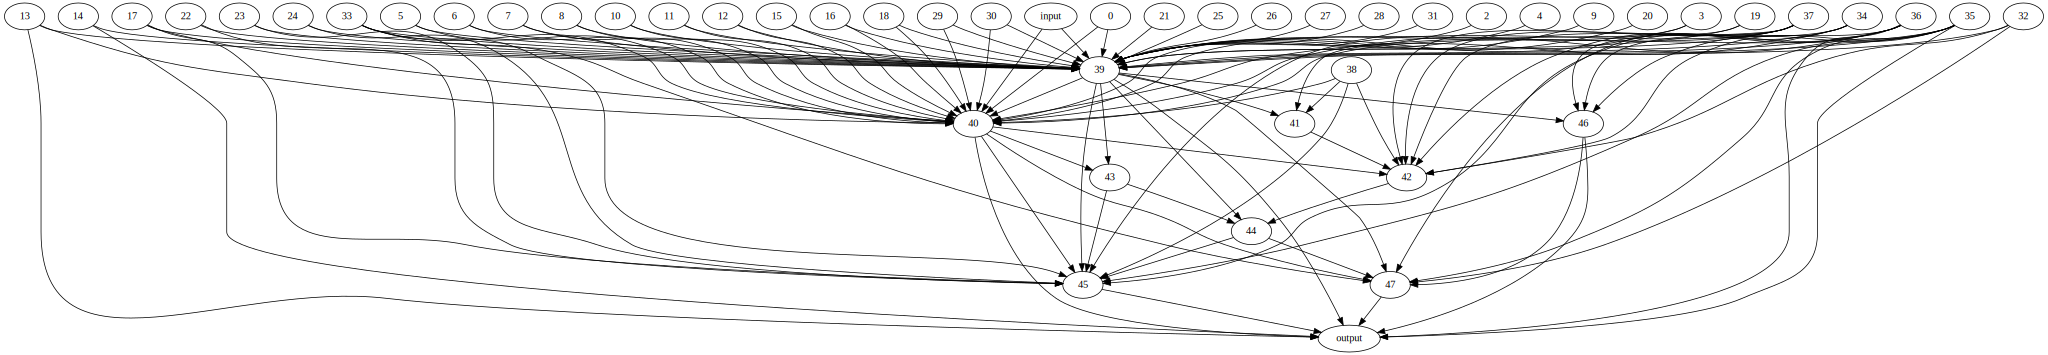

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 9.pkl
patching 332 edges, keeping 113 edges, 780 remain
patching 332 edges, keeping 113 edges, 780 remain
baseline score 2.785144329071045
[39] sized edge sets remaining
got scores tensor([2.7722], device='cuda:0')
splitting 39 edges into two edge sets, as they have score 2.772157907485962 which has diff 0.012986421585083008 > 1e-05
patching 332 edges, keeping 113 edges, 780 remain
baseline score 2.785144329071045
[19, 20] sized edge sets remaining
got scores tensor([2.7847, 2.7729], device='cuda:0')
splitting 19 edges into two edge sets, as they have score 2.78466796875 which has diff 0.0004763603210449219 > 1e-05
splitting 20 edges into two edge sets, as they have score 2.772876501083374 which has diff 0.012267827987670898 > 1e-05
patching 332 edges, keeping 113 edges, 780 remain
baseline score 2.785144329071045
[9, 10, 10, 10] sized edge sets remaining
got scores tensor([2.7849, 2.7850, 2.7844, 2.7736], device='cuda:0')
splitt

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7851, 2.7851, 2.7853, 2.7849, 2.7847, 2.7850, 2.7846, 2.7744],
       device='cuda:0')
splitting 4 edges into two edge sets, as they have score 2.7850914001464844 which has diff 5.2928924560546875e-05 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7850518226623535 which has diff 9.250640869140625e-05 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7849388122558594 which has diff 0.00020551681518554688 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7846744060516357 which has diff 0.0004699230194091797 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7850072383880615 which has diff 0.00013709068298339844 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.784572124481201 which has diff 0.00057220458984375 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7744438648223877 which has diff 0.010700464248657227 > 1e-05
doing rollback test with score 2.7853319644927

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.7851, 2.7854, 2.7853, 2.7852, 2.7851, 2.7853, 2.7855, 2.7847, 2.7852,
        2.7853, 2.7849, 2.7853, 2.7782, 2.7814], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.7851388454437256 which has diff 0.0001285076141357422 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7851884365081787 which has diff 7.891654968261719e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.785079002380371 which has diff 0.00018835067749023438 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.784654140472412 which has diff 0.0006132125854492188 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.785189390182495 which has diff 7.796287536621094e-05 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.785252571105957 which has diff 1.4781951904296875e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.784885883331299 which has diff 0.0003814697265625 > 1e-05
sp

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.7854, 2.7854, 2.7854, 2.7854, 2.7855, 2.7852, 2.7853, 2.7850, 2.7854,
        2.7854, 2.7853, 2.7856, 2.7858, 2.7845, 2.7788, 2.7848, 2.7850, 2.7816],
       device='cuda:0')
keeping edge edge  input -> 38 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.38.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.785388946533203 which has diff 2.5987625122070312e-05 > 1e-05
keeping edge edge  0 -> 38 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.38.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7854013442993164 which has diff 1.3589859008789062e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.785367965698242 which has diff 4.696846008300781e-05 > 1e-05
keeping edge edge  14 -> 38 (('blocks.14.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.38.hook_layer_input', <function resid_patching_hook at 0x7fb5

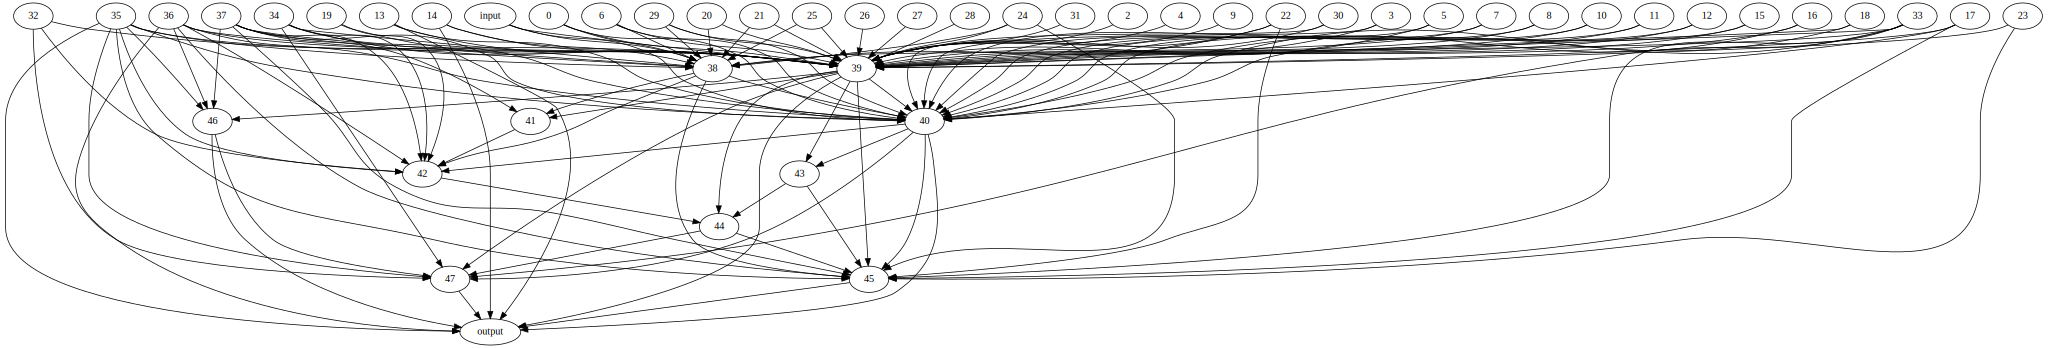

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 10.pkl
patching 356 edges, keeping 128 edges, 741 remain
patching 356 edges, keeping 128 edges, 741 remain
baseline score 2.7857682704925537
[38] sized edge sets remaining
got scores tensor([2.6870], device='cuda:0')
splitting 38 edges into two edge sets, as they have score 2.6870315074920654 which has diff 0.09873676300048828 > 1e-05
patching 356 edges, keeping 128 edges, 741 remain
baseline score 2.7857682704925537
[19, 19] sized edge sets remaining
got scores tensor([2.7552, 2.7184], device='cuda:0')
splitting 19 edges into two edge sets, as they have score 2.755228281021118 which has diff 0.030539989471435547 > 1e-05
splitting 19 edges into two edge sets, as they have score 2.7183661460876465 which has diff 0.06740212440490723 > 1e-05
patching 356 edges, keeping 128 edges, 741 remain
baseline score 2.7857682704925537
[9, 10, 9, 10] sized edge sets remaining
got scores tensor([2.7609, 2.7808, 2.7684, 2.7291], device='cuda:0')


  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7645, 2.7827, 2.7844, 2.7818, 2.7762, 2.7789, 2.7816, 2.7318],
       device='cuda:0')
splitting 4 edges into two edge sets, as they have score 2.764486312866211 which has diff 0.021281957626342773 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.782674551010132 which has diff 0.003093719482421875 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7844457626342773 which has diff 0.0013225078582763672 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7817723751068115 which has diff 0.0039958953857421875 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.7761857509613037 which has diff 0.00958251953125 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7789297103881836 which has diff 0.006838560104370117 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7815542221069336 which has diff 0.004214048385620117 > 1e-05
splitting 5 edges into two edge sets, as they have score

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.7654, 2.7849, 2.7844, 2.7841, 2.7848, 2.7854, 2.7849, 2.7828, 2.7805,
        2.7810, 2.7866, 2.7781, 2.7844, 2.7825, 2.7551, 2.7639],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.7653844356536865 which has diff 0.020383834838867188 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.784893035888672 which has diff 0.0008752346038818359 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.7843692302703857 which has diff 0.0013990402221679688 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7840890884399414 which has diff 0.0016791820526123047 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.784846782684326 which has diff 0.0009214878082275391 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7853503227233887 which has diff 0.00041794776916503906 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.784895896911621 which has diff 0.0008

  0%|          | 0/10 [00:00<?, ?it/s]

got scores tensor([2.7798, 2.7728, 2.7857, 2.7866, 2.7858, 2.7859, 2.7859, 2.7855, 2.7854,
        2.7869, 2.7870, 2.7853, 2.7856, 2.7866, 2.7841, 2.7861, 2.7870, 2.7804,
        2.7834, 2.7849, 2.7863, 2.7795, 2.7881, 2.7842, 2.7841, 2.7855, 2.7894,
        2.7526, 2.7788, 2.7724], device='cuda:0')
keeping edge edge  input -> 37 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.779815196990967 which has diff 0.006719112396240234 > 1e-05
keeping edge edge  0 -> 37 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.772763729095459 which has diff 0.013770580291748047 > 1e-05
keeping edge edge  1 -> 37 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with scor

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7903, 2.7917, 2.7892, 2.7927, 2.7919, 2.7910, 2.7882, 2.7886, 2.7897,
        2.7925, 2.7924, 2.7784], device='cuda:0')
keeping edge edge  6 -> 37 (('blocks.6.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7903411388397217 which has diff 0.0011937618255615234 > 1e-05
keeping edge edge  11 -> 37 (('blocks.11.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7892494201660156 which has diff 0.002285480499267578 > 1e-05
keeping edge edge  17 -> 37 (('blocks.17.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7910492420196533 which has diff 0.0004856586456298828 > 1e-05
keeping edge edge  25 -> 37 (('blocks.25.hook_out_proj', <function storage_hook

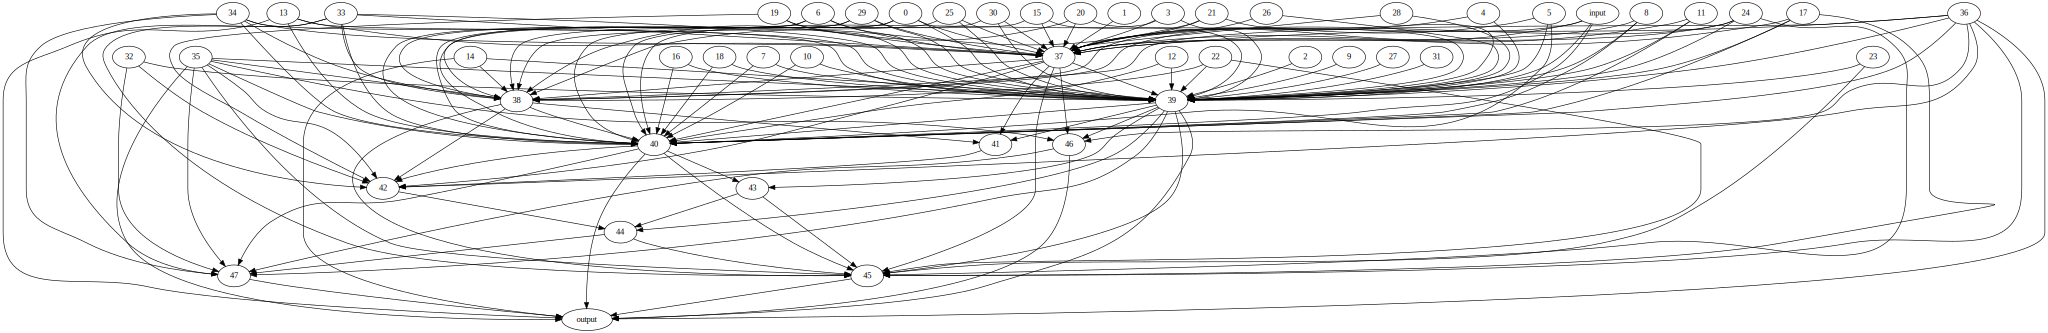

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 11.pkl
patching 370 edges, keeping 152 edges, 703 remain
patching 370 edges, keeping 152 edges, 703 remain
baseline score 2.794861078262329
[37] sized edge sets remaining
got scores tensor([2.7325], device='cuda:0')
splitting 37 edges into two edge sets, as they have score 2.7325210571289062 which has diff 0.06234002113342285 > 1e-05
patching 370 edges, keeping 152 edges, 703 remain
baseline score 2.794861078262329
[18, 19] sized edge sets remaining
got scores tensor([2.7661, 2.7668], device='cuda:0')
splitting 18 edges into two edge sets, as they have score 2.7661218643188477 which has diff 0.028739213943481445 > 1e-05
splitting 19 edges into two edge sets, as they have score 2.766768455505371 which has diff 0.028092622756958008 > 1e-05
patching 370 edges, keeping 152 edges, 703 remain
baseline score 2.794861078262329
[9, 9, 9, 10] sized edge sets remaining
got scores tensor([2.7702, 2.7920, 2.7851, 2.7777], device='cuda:0')
spl

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7735, 2.7923, 2.7978, 2.7888, 2.7889, 2.7928, 2.7839, 2.7841],
       device='cuda:0')
splitting 4 edges into two edge sets, as they have score 2.773533344268799 which has diff 0.021327733993530273 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7922723293304443 which has diff 0.0025887489318847656 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.788825035095215 which has diff 0.006036043167114258 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.7888524532318115 which has diff 0.006008625030517578 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.792757272720337 which has diff 0.0021038055419921875 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7839195728302 which has diff 0.010941505432128906 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.784104824066162 which has diff 0.010756254196166992 > 1e-05
doing rollback test with score 2.7977986335754395 and sco

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.7738, 2.8001, 2.7973, 2.7956, 2.7949, 2.7950, 2.7993, 2.7897, 2.7957,
        2.7975, 2.7902, 2.7928, 2.8009, 2.7810], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.7738256454467773 which has diff 0.023908138275146484 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.7972776889801025 which has diff 0.00045609474182128906 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7956130504608154 which has diff 0.0021207332611083984 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.794908285140991 which has diff 0.002825498580932617 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7949562072753906 which has diff 0.002777576446533203 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.78971004486084 which has diff 0.008023738861083984 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.795665740966797 which has diff 0.002068042755126953 > 1e-05
spli

  0%|          | 0/8 [00:00<?, ?it/s]

got scores tensor([2.7996, 2.7871, 2.8047, 2.8050, 2.8051, 2.8038, 2.8039, 2.8037, 2.8036,
        2.8045, 2.7997, 2.8020, 2.8047, 2.8038, 2.8068, 2.8023, 2.7968, 2.8035,
        2.8033, 2.8006, 2.8075, 2.7866], device='cuda:0')
keeping edge edge  input -> 36 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.799581289291382 which has diff 0.005519390106201172 > 1e-05
keeping edge edge  0 -> 36 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.787050724029541 which has diff 0.018049955368041992 > 1e-05
keeping edge edge  3 -> 36 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8047075271606445 which has diff 0.00039315223693847656 > 1e-05
keepi

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.8086, 2.8092, 2.8081, 2.8102, 2.8069, 2.8062, 2.8044, 2.8085, 2.7990,
        2.8006], device='cuda:0')
keeping edge edge  6 -> 36 (('blocks.6.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8085784912109375 which has diff 0.0009124279022216797 > 1e-05
keeping edge edge  7 -> 36 (('blocks.7.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.809173583984375 which has diff 0.0003173351287841797 > 1e-05
keeping edge edge  15 -> 36 (('blocks.15.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.808091878890991 which has diff 0.0013990402221679688 > 1e-05
keeping edge edge  24 -> 36 (('blocks.24.hook_out_proj', <function storage_hook at 0x7fb524c0a440>

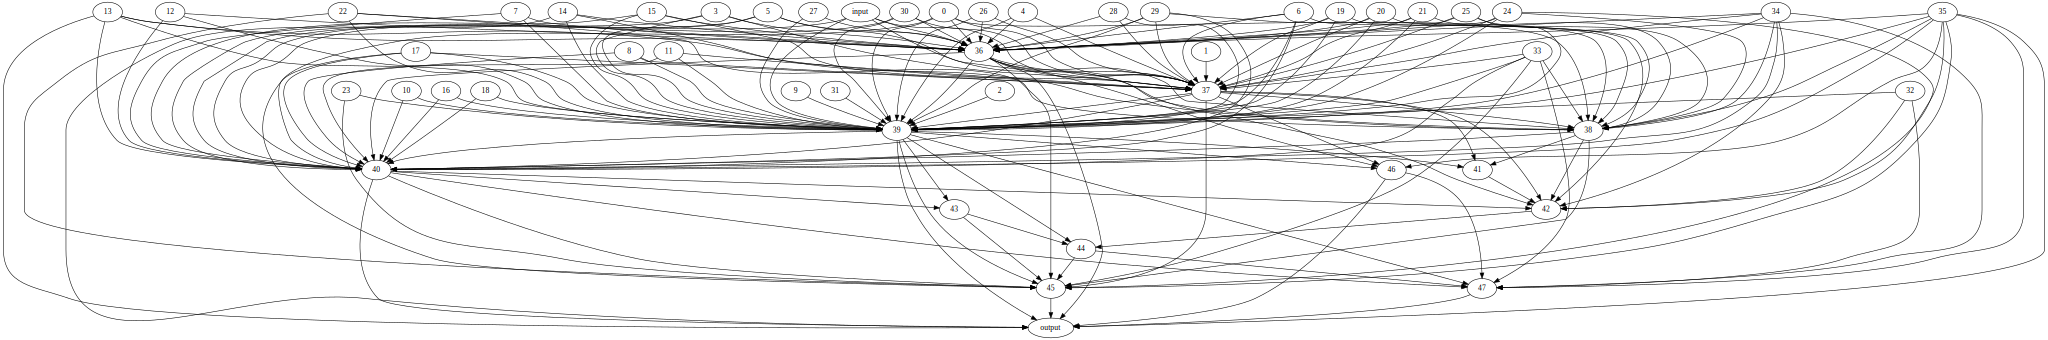

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 12.pkl
patching 383 edges, keeping 176 edges, 666 remain
patching 383 edges, keeping 176 edges, 666 remain
baseline score 2.8101069927215576
[36] sized edge sets remaining
got scores tensor([2.6142], device='cuda:0')
splitting 36 edges into two edge sets, as they have score 2.614208221435547 which has diff 0.19589877128601074 > 1e-05
patching 383 edges, keeping 176 edges, 666 remain
baseline score 2.8101069927215576
[18, 18] sized edge sets remaining
got scores tensor([2.7353, 2.6972], device='cuda:0')
splitting 18 edges into two edge sets, as they have score 2.735335111618042 which has diff 0.07477188110351562 > 1e-05
splitting 18 edges into two edge sets, as they have score 2.6971957683563232 which has diff 0.11291122436523438 > 1e-05
patching 383 edges, keeping 176 edges, 666 remain
baseline score 2.8101069927215576
[9, 9, 9, 9] sized edge sets remaining
got scores tensor([2.7542, 2.7992, 2.7696, 2.7395], device='cuda:0')
spli

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7581, 2.8070, 2.8041, 2.8064, 2.7889, 2.7935, 2.7777, 2.7716],
       device='cuda:0')
splitting 4 edges into two edge sets, as they have score 2.758126735687256 which has diff 0.05198025703430176 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.807037591934204 which has diff 0.0030694007873535156 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.8041086196899414 which has diff 0.005998373031616211 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.8063714504241943 which has diff 0.0037355422973632812 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.788923978805542 which has diff 0.021183013916015625 > 1e-05
splitting 5 edges into two edge sets, as they have score 2.7934656143188477 which has diff 0.01664137840270996 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.777702569961548 which has diff 0.032404422760009766 > 1e-05
splitting 5 edges into two edge sets, as they have score

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.7565, 2.8118, 2.8096, 2.8077, 2.8075, 2.8068, 2.8110, 2.8062, 2.8035,
        2.7959, 2.8003, 2.8034, 2.7948, 2.7909, 2.7933, 2.7830],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.756455421447754 which has diff 0.05365157127380371 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.809561014175415 which has diff 0.0005459785461425781 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.8077142238616943 which has diff 0.0023927688598632812 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.807492971420288 which has diff 0.0026140213012695312 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.806752920150757 which has diff 0.0033540725708007812 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.806150436401367 which has diff 0.00395655632019043 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8034582138061523 which has diff 0.0066487789

  0%|          | 0/10 [00:00<?, ?it/s]

got scores tensor([2.8023, 2.7711, 2.8122, 2.8120, 2.8114, 2.8114, 2.8118, 2.8102, 2.8098,
        2.8120, 2.8131, 2.8072, 2.8095, 2.8085, 2.8095, 2.8018, 2.8093, 2.8056,
        2.8106, 2.8075, 2.8014, 2.8091, 2.8081, 2.7969, 2.8125, 2.7952, 2.8083,
        2.7927], device='cuda:0')
keeping edge edge  input -> 35 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.35.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8023087978363037 which has diff 0.010065317153930664 > 1e-05
keeping edge edge  0 -> 35 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.35.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7711117267608643 which has diff 0.04126238822937012 > 1e-05
keeping edge edge  3 -> 35 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.35.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.81222200393

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.8114, 2.8138, 2.8070, 2.8139, 2.8083, 2.8128, 2.7855, 2.8200],
       device='cuda:0')
keeping edge edge  6 -> 35 (('blocks.6.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.35.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8113996982574463 which has diff 0.0016889572143554688 > 1e-05
keeping edge edge  15 -> 35 (('blocks.15.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.35.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8069980144500732 which has diff 0.006090641021728516 > 1e-05
keeping edge edge  24 -> 35 (('blocks.24.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.35.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8082847595214844 which has diff 0.004803895950317383 > 1e-05
keeping edge edge  25 -> 35 (('blocks.25.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.3

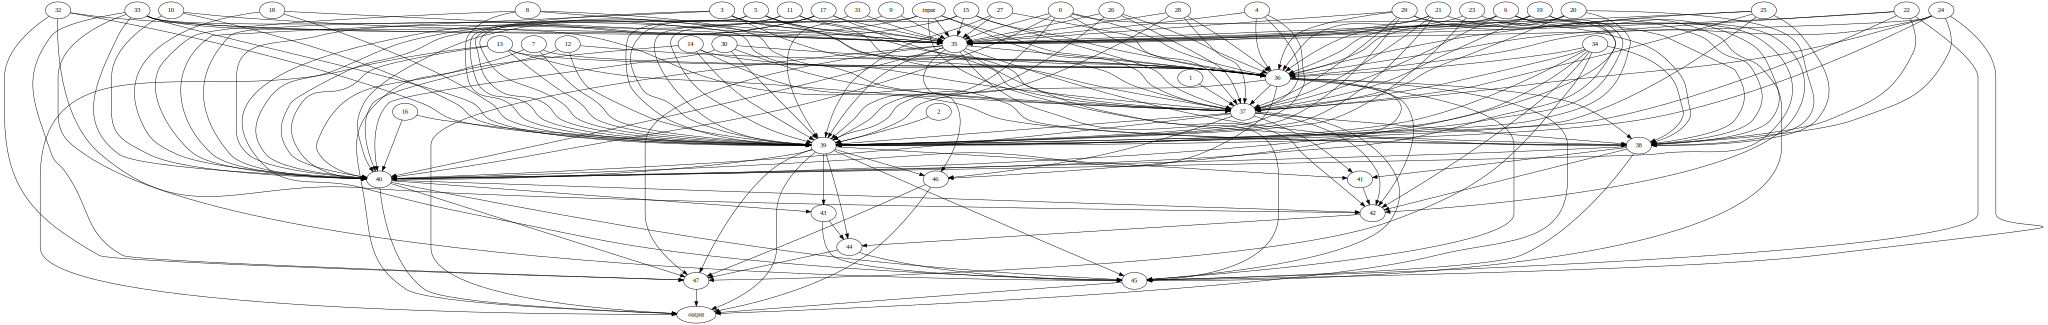

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 13.pkl
patching 392 edges, keeping 203 edges, 630 remain
patching 392 edges, keeping 203 edges, 630 remain
baseline score 2.8215630054473877
[35] sized edge sets remaining
got scores tensor([2.7899], device='cuda:0')
splitting 35 edges into two edge sets, as they have score 2.789870262145996 which has diff 0.0316927433013916 > 1e-05
patching 392 edges, keeping 203 edges, 630 remain
baseline score 2.8215630054473877
[17, 18] sized edge sets remaining
got scores tensor([2.8203, 2.7934], device='cuda:0')
splitting 17 edges into two edge sets, as they have score 2.820265769958496 which has diff 0.0012972354888916016 > 1e-05
splitting 18 edges into two edge sets, as they have score 2.793386220932007 which has diff 0.02817678451538086 > 1e-05
patching 392 edges, keeping 203 edges, 630 remain
baseline score 2.8215630054473877
[8, 9, 9, 9] sized edge sets remaining
got scores tensor([2.8134, 2.8286, 2.8135, 2.7981], device='cuda:0')
spli

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.8213, 2.8273, 2.8245, 2.8287, 2.8260, 2.8273, 2.8274, 2.8221, 2.8259,
        2.8118], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.8212544918060303 which has diff 0.0073699951171875 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.827285051345825 which has diff 0.0013394355773925781 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.824469566345215 which has diff 0.00415492057800293 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8259541988372803 which has diff 0.0026702880859375 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.8273041248321533 which has diff 0.0013203620910644531 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8274483680725098 which has diff 0.0011761188507080078 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.822099447250366 which has diff 0.0065250396728515625 > 1e-05
splitting 2 edges into two edge sets, a

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.8291, 2.8199, 2.8273, 2.8283, 2.8264, 2.8270, 2.8253, 2.8297, 2.8288,
        2.8277, 2.8247, 2.8308, 2.8330, 2.8205, 2.8223, 2.8312, 2.8286, 2.8109],
       device='cuda:0')
keeping edge edge  0 -> 34 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8199052810668945 which has diff 0.00870513916015625 > 1e-05
keeping edge edge  1 -> 34 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.827331066131592 which has diff 0.0012793540954589844 > 1e-05
keeping edge edge  2 -> 34 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8283421993255615 which has diff 0.0002682209014892578 > 1e-05
keeping edge edge  16 -> 34 ((

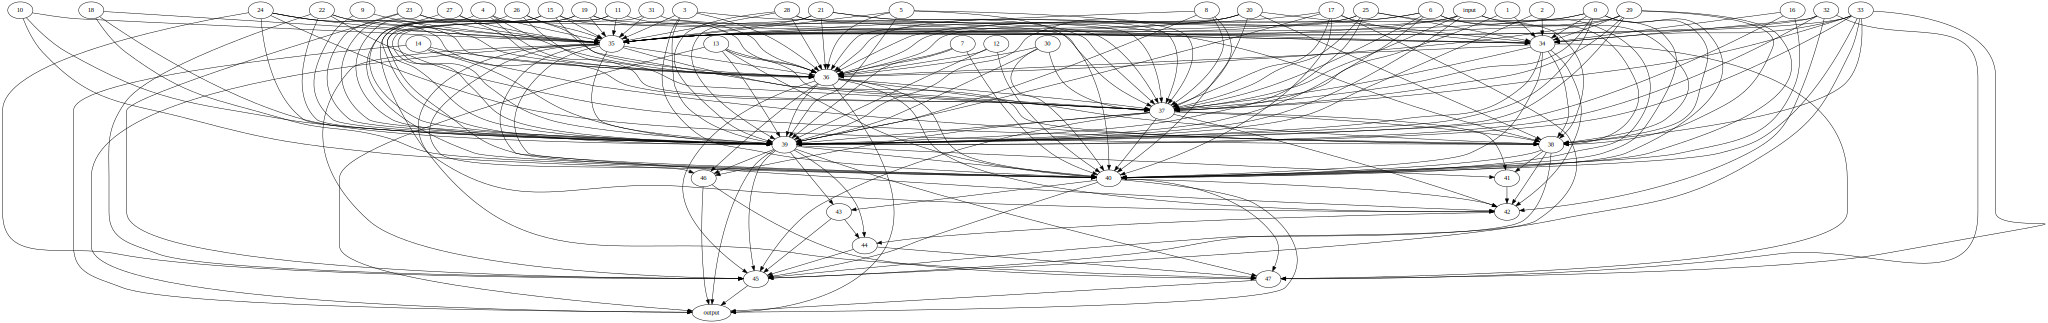

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 14.pkl
patching 414 edges, keeping 216 edges, 595 remain
patching 414 edges, keeping 216 edges, 595 remain
baseline score 2.8425872325897217
[34] sized edge sets remaining
got scores tensor([2.6379], device='cuda:0')
splitting 34 edges into two edge sets, as they have score 2.6378767490386963 which has diff 0.2047104835510254 > 1e-05
patching 414 edges, keeping 216 edges, 595 remain
baseline score 2.8425872325897217
[17, 17] sized edge sets remaining
got scores tensor([2.8261, 2.6763], device='cuda:0')
splitting 17 edges into two edge sets, as they have score 2.8261380195617676 which has diff 0.0164492130279541 > 1e-05
splitting 17 edges into two edge sets, as they have score 2.6763343811035156 which has diff 0.16625285148620605 > 1e-05
patching 414 edges, keeping 216 edges, 595 remain
baseline score 2.8425872325897217
[8, 9, 8, 9] sized edge sets remaining
got scores tensor([2.8260, 2.8482, 2.8247, 2.7053], device='cuda:0')
spli

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.8185, 2.8563, 2.8512, 2.8447, 2.8406, 2.8484, 2.8408, 2.8432, 2.8326,
        2.8164, 2.8630, 2.7341], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.818481922149658 which has diff 0.029679298400878906 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8447442054748535 which has diff 0.0034170150756835938 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8406054973602295 which has diff 0.007555723190307617 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8407537937164307 which has diff 0.007407426834106445 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8432457447052 which has diff 0.004915475845336914 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8326237201690674 which has diff 0.015537500381469727 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.816434621810913 which has diff 0.03172659873962402 > 1e-05
splitting 3 edges into t

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.8563, 2.8583, 2.8702, 2.8716, 2.8737, 2.8642, 2.8691, 2.8666, 2.8645,
        2.8762, 2.8697, 2.8605, 2.8329, 2.8728, 2.8791, 2.7449],
       device='cuda:0')
keeping edge edge  input -> 33 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.33.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.85632061958313 which has diff 0.016025304794311523 > 1e-05
keeping edge edge  0 -> 33 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.33.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8583123683929443 which has diff 0.01403355598449707 > 1e-05
keeping edge edge  5 -> 33 (('blocks.5.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.33.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8702218532562256 which has diff 0.0021240711212158203 > 1e-05
keeping edge edge  6 -> 33 (('blocks.6.hook_out_proj', <

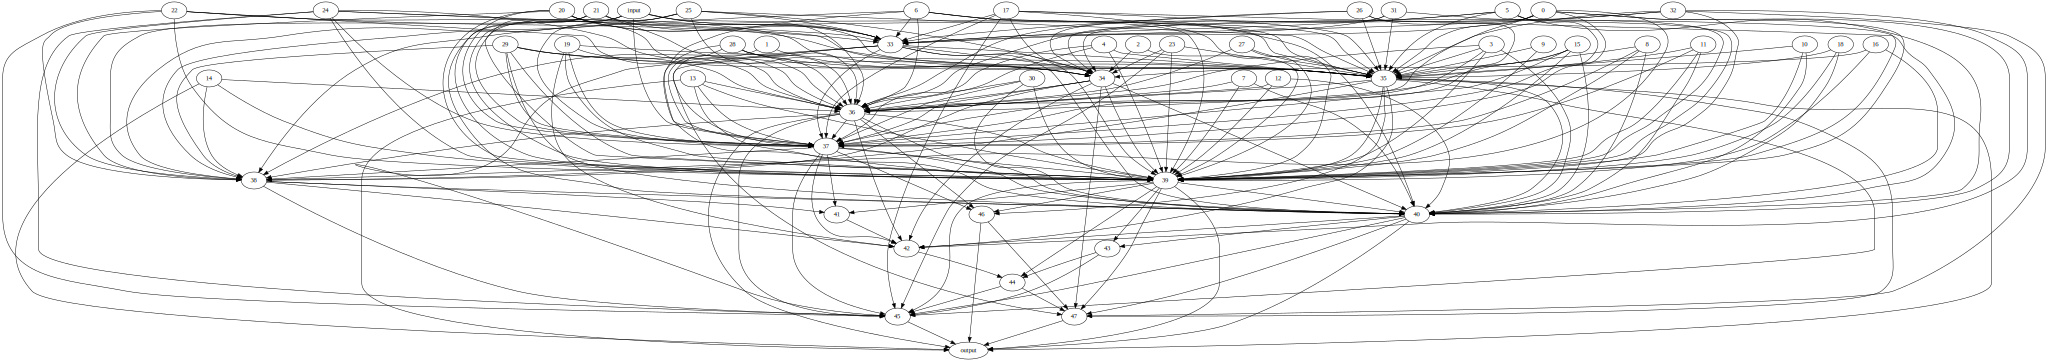

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 15.pkl
patching 435 edges, keeping 229 edges, 561 remain
patching 435 edges, keeping 229 edges, 561 remain
baseline score 2.8832333087921143
[33] sized edge sets remaining
got scores tensor([2.8473], device='cuda:0')
splitting 33 edges into two edge sets, as they have score 2.8472704887390137 which has diff 0.035962820053100586 > 1e-05
patching 435 edges, keeping 229 edges, 561 remain
baseline score 2.8832333087921143
[16, 17] sized edge sets remaining
got scores tensor([2.8856, 2.8706], device='cuda:0')
splitting 17 edges into two edge sets, as they have score 2.8705620765686035 which has diff 0.012671232223510742 > 1e-05
doing rollback test with score 2.885632276535034 and score_lost_by_edge_set -0.002398967742919922 with edge set of size 16
rolling back with pivot 1
patching 16 edges with score 2.885632276535034 with diff of -0.002398967742919922
but patching with others at the same time, overall they have score 2.885576725006

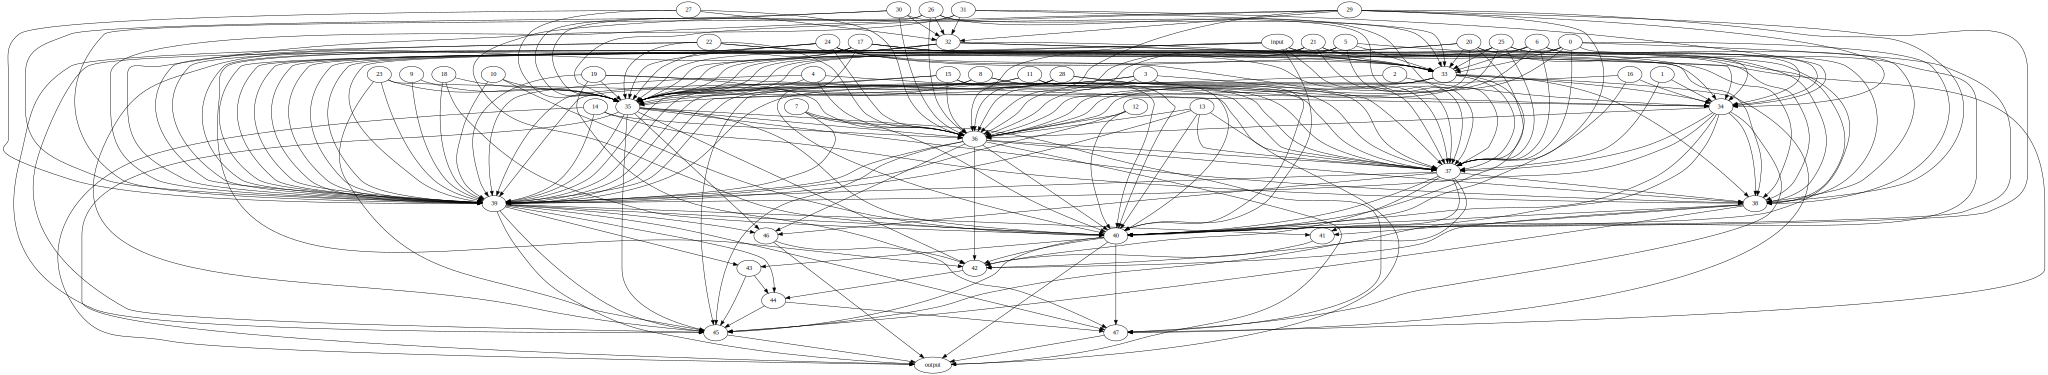

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 16.pkl
patching 463 edges, keeping 234 edges, 528 remain
patching 463 edges, keeping 234 edges, 528 remain
baseline score 2.8986315727233887
[32] sized edge sets remaining
got scores tensor([2.7089], device='cuda:0')
splitting 32 edges into two edge sets, as they have score 2.7088820934295654 which has diff 0.18974947929382324 > 1e-05
patching 463 edges, keeping 234 edges, 528 remain
baseline score 2.8986315727233887
[16, 16] sized edge sets remaining
got scores tensor([2.8642, 2.7563], device='cuda:0')
splitting 16 edges into two edge sets, as they have score 2.864182949066162 which has diff 0.03444862365722656 > 1e-05
splitting 16 edges into two edge sets, as they have score 2.7562761306762695 which has diff 0.14235544204711914 > 1e-05
patching 463 edges, keeping 234 edges, 528 remain
baseline score 2.8986315727233887
[8, 8, 8, 8] sized edge sets remaining
got scores tensor([2.8789, 2.8878, 2.8747, 2.7998], device='cuda:0')
spl

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.8775, 2.9001, 2.8996, 2.8876, 2.8873, 2.8910, 2.8262, 2.8652],
       device='cuda:0')
splitting 4 edges into two edge sets, as they have score 2.8775415420532227 which has diff 0.021090030670166016 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.887598752975464 which has diff 0.011032819747924805 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.8872926235198975 which has diff 0.011338949203491211 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.890995502471924 which has diff 0.007636070251464844 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.826200485229492 which has diff 0.07243108749389648 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.8651721477508545 which has diff 0.03345942497253418 > 1e-05
doing rollback test with score 2.900074005126953 and score_lost_by_edge_set -0.0014424324035644531 with edge set of size 4
doing rollback test with score 2.899604320526123 and s

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.8818, 2.9002, 2.8918, 2.8984, 2.8956, 2.8938, 2.8927, 2.9021, 2.8829,
        2.8630, 2.8951, 2.8663], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.881784677505493 which has diff 0.01901841163635254 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9002041816711426 which has diff 0.000598907470703125 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8917529582977295 which has diff 0.009050130844116211 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.898395299911499 which has diff 0.0024077892303466797 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8955578804016113 which has diff 0.005245208740234375 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8937554359436035 which has diff 0.0070476531982421875 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8926568031311035 which has diff 0.008146286010742188 > 1e-05
splitting 2 edges in

  0%|          | 0/8 [00:00<?, ?it/s]

got scores tensor([2.9048, 2.8825, 2.9019, 2.9016, 2.9043, 2.8912, 2.8964, 2.9053, 2.8938,
        2.9042, 2.8966, 2.8999, 2.9053, 2.8902, 2.8851, 2.9016, 2.8985, 2.8731,
        2.8965, 2.9006, 2.8736, 2.8962], device='cuda:0')
keeping edge edge  0 -> 31 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8825185298919678 which has diff 0.019523143768310547 > 1e-05
keeping edge edge  1 -> 31 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9019482135772705 which has diff 9.34600830078125e-05 > 1e-05
keeping edge edge  2 -> 31 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.901557445526123 which has diff 0.00048422813415527344 > 1e

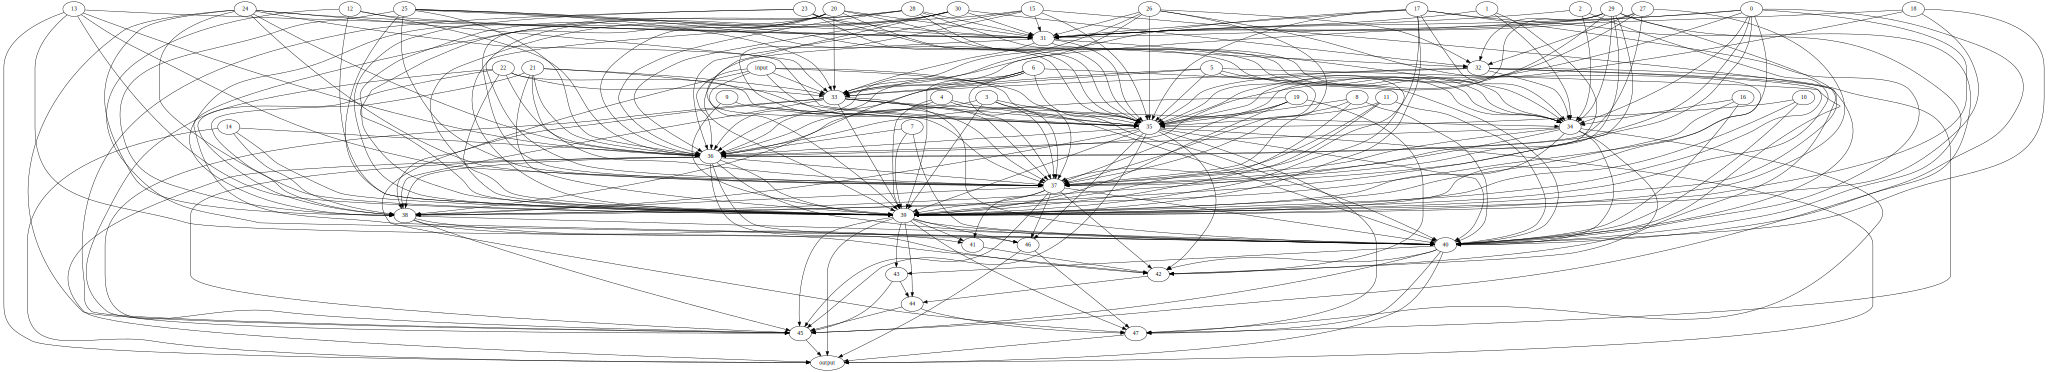

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 17.pkl
patching 478 edges, keeping 251 edges, 496 remain
patching 478 edges, keeping 251 edges, 496 remain
baseline score 2.911768674850464
[31] sized edge sets remaining
got scores tensor([2.8513], device='cuda:0')
splitting 31 edges into two edge sets, as they have score 2.8512954711914062 which has diff 0.06047320365905762 > 1e-05
patching 478 edges, keeping 251 edges, 496 remain
baseline score 2.911768674850464
[15, 16] sized edge sets remaining
got scores tensor([2.8970, 2.8786], device='cuda:0')
splitting 15 edges into two edge sets, as they have score 2.896981954574585 which has diff 0.014786720275878906 > 1e-05
splitting 16 edges into two edge sets, as they have score 2.8785533905029297 which has diff 0.03321528434753418 > 1e-05
patching 478 edges, keeping 251 edges, 496 remain
baseline score 2.911768674850464
[7, 8, 8, 8] sized edge sets remaining
got scores tensor([2.8915, 2.9181, 2.9127, 2.8822], device='cuda:0')
split

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.9049, 2.9211, 2.9116, 2.9163, 2.9202, 2.9119, 2.9033, 2.9234, 2.9287,
        2.9058], device='cuda:0')
keeping edge edge  0 -> 30 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9049127101898193 which has diff 0.015262365341186523 > 1e-05
keeping edge edge  22 -> 30 (('blocks.22.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9115681648254395 which has diff 0.008606910705566406 > 1e-05
keeping edge edge  23 -> 30 (('blocks.23.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9163060188293457 which has diff 0.0038690567016601562 > 1e-05
keeping edge edge  25 -> 30 (('blocks.25.hook_out_proj', <function storage_hook at 0x7fb524c0a44

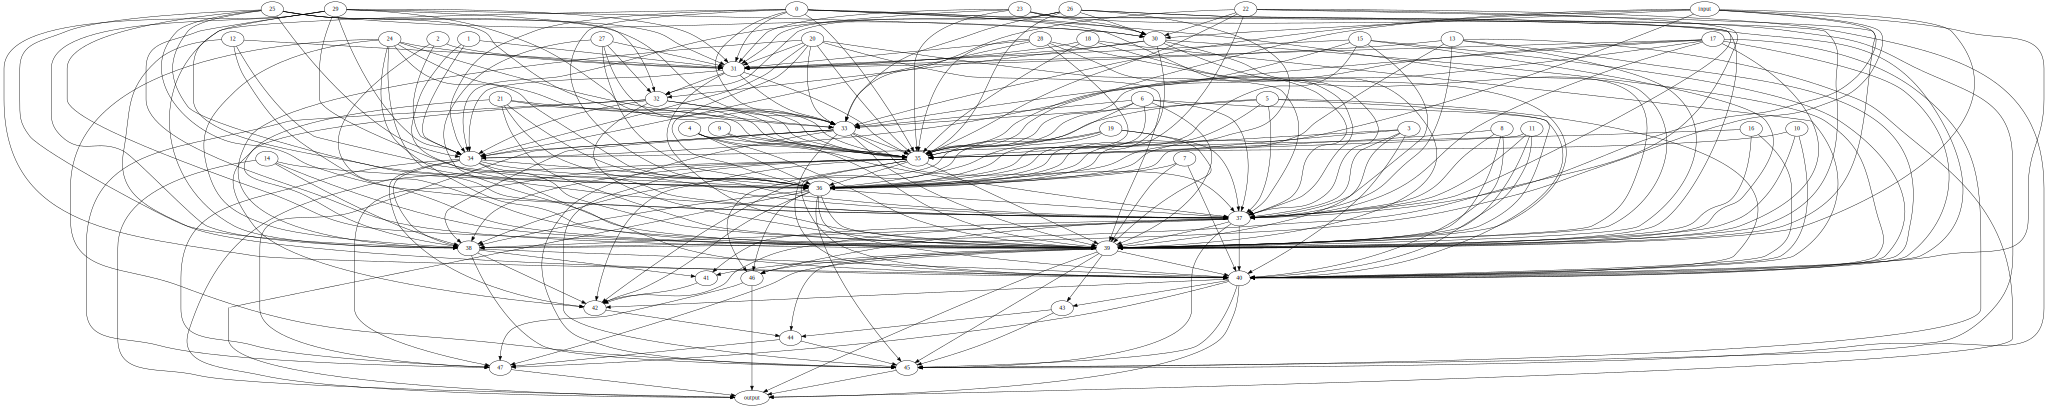

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 18.pkl
patching 502 edges, keeping 258 edges, 465 remain
patching 502 edges, keeping 258 edges, 465 remain
baseline score 2.9318225383758545
[30] sized edge sets remaining
got scores tensor([2.7717], device='cuda:0')
splitting 30 edges into two edge sets, as they have score 2.7717318534851074 which has diff 0.16009068489074707 > 1e-05
patching 502 edges, keeping 258 edges, 465 remain
baseline score 2.9318225383758545
[15, 15] sized edge sets remaining
got scores tensor([2.8702, 2.8411], device='cuda:0')
splitting 15 edges into two edge sets, as they have score 2.870227575302124 which has diff 0.06159496307373047 > 1e-05
splitting 15 edges into two edge sets, as they have score 2.841142416000366 which has diff 0.09068012237548828 > 1e-05
patching 502 edges, keeping 258 edges, 465 remain
baseline score 2.9318225383758545
[7, 8, 7, 8] sized edge sets remaining
got scores tensor([2.8840, 2.9206, 2.9028, 2.8729], device='cuda:0')
spli

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.8869, 2.9296, 2.9292, 2.9228, 2.9225, 2.9140, 2.9254, 2.8847],
       device='cuda:0')
splitting 3 edges into two edge sets, as they have score 2.8868682384490967 which has diff 0.04495429992675781 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.929594039916992 which has diff 0.0022284984588623047 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.9292352199554443 which has diff 0.0025873184204101562 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.922841787338257 which has diff 0.008980751037597656 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.922492027282715 which has diff 0.009330511093139648 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.914010524749756 which has diff 0.017812013626098633 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.9254422187805176 which has diff 0.006380319595336914 > 1e-05
splitting 4 edges into two edge sets, as they have scor

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.9246, 2.8960, 2.9308, 2.9307, 2.9321, 2.9290, 2.9281, 2.9257, 2.9306,
        2.9237, 2.9284, 2.9171, 2.9233, 2.9350, 2.9088, 2.9064],
       device='cuda:0')
keeping edge edge  input -> 29 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.29.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9246037006378174 which has diff 0.007218837738037109 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.8960468769073486 which has diff 0.03577566146850586 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9307806491851807 which has diff 0.0010418891906738281 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9307479858398438 which has diff 0.0010745525360107422 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9290003776550293 which has diff 0.0028221607208251953 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9281466007232666 which has di

  0%|          | 0/8 [00:00<?, ?it/s]

got scores tensor([2.8938, 2.9340, 2.9348, 2.9345, 2.9344, 2.9345, 2.9347, 2.9332, 2.9352,
        2.9325, 2.9293, 2.9311, 2.9302, 2.9296, 2.9358, 2.9310, 2.9307, 2.9239,
        2.9332, 2.9274, 2.9309, 2.9110, 2.9260, 2.9172], device='cuda:0')
keeping edge edge  0 -> 29 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.29.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.8937714099884033 which has diff 0.04141998291015625 > 1e-05
keeping edge edge  1 -> 29 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.29.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9339630603790283 which has diff 0.00122833251953125 > 1e-05
keeping edge edge  2 -> 29 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.29.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9348204135894775 which has diff 0.0003709793

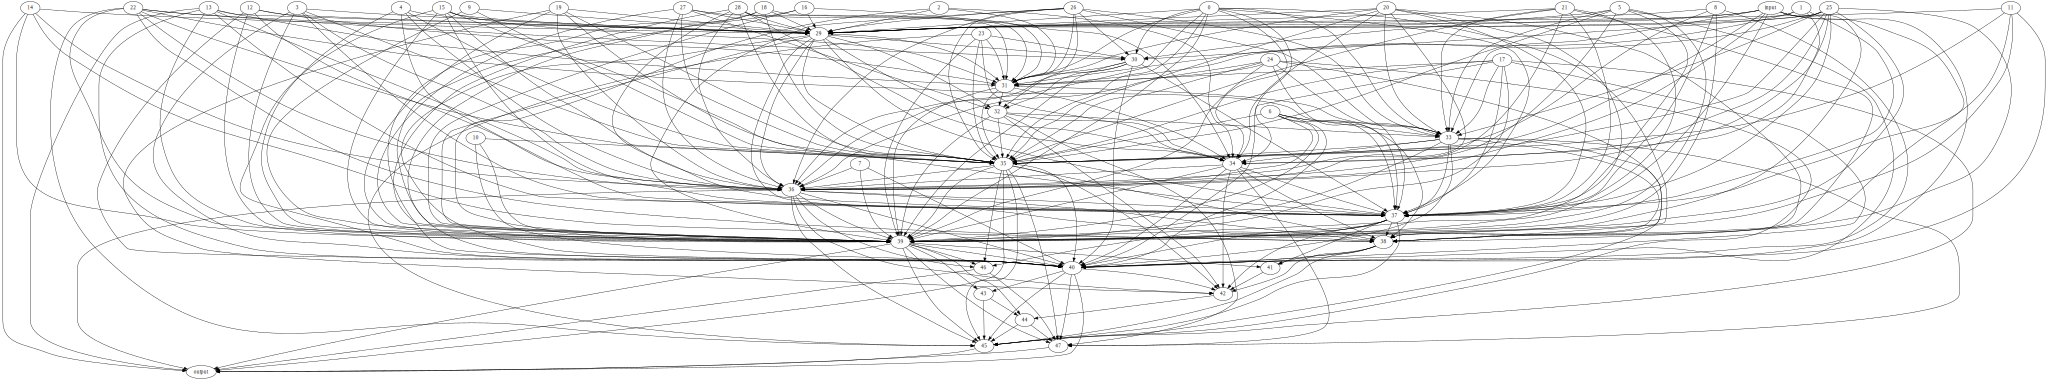

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 19.pkl
patching 508 edges, keeping 282 edges, 435 remain
patching 508 edges, keeping 282 edges, 435 remain
baseline score 2.935534715652466
[29] sized edge sets remaining
got scores tensor([2.8774], device='cuda:0')
splitting 29 edges into two edge sets, as they have score 2.877445936203003 which has diff 0.05808877944946289 > 1e-05
patching 508 edges, keeping 282 edges, 435 remain
baseline score 2.935534715652466
[14, 15] sized edge sets remaining
got scores tensor([2.8942, 2.8697], device='cuda:0')
splitting 14 edges into two edge sets, as they have score 2.894232749938965 which has diff 0.04130196571350098 > 1e-05
splitting 15 edges into two edge sets, as they have score 2.869657516479492 which has diff 0.06587719917297363 > 1e-05
patching 508 edges, keeping 282 edges, 435 remain
baseline score 2.935534715652466
[7, 7, 7, 8] sized edge sets remaining
got scores tensor([2.9000, 2.9246, 2.9222, 2.8745], device='cuda:0')
splittin

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9034, 2.9310, 2.9333, 2.9267, 2.9258, 2.9312, 2.9099, 2.8906],
       device='cuda:0')
splitting 3 edges into two edge sets, as they have score 2.903446912765503 which has diff 0.03208780288696289 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.931022882461548 which has diff 0.004511833190917969 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.9332714080810547 which has diff 0.002263307571411133 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.9267361164093018 which has diff 0.008798599243164062 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.9257524013519287 which has diff 0.00978231430053711 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.931154727935791 which has diff 0.004379987716674805 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.9098620414733887 which has diff 0.02567267417907715 > 1e-05
splitting 4 edges into two edge sets, as they have score 2

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.9335, 2.9056, 2.9343, 2.9323, 2.9371, 2.9317, 2.9355, 2.9269, 2.9336,
        2.9276, 2.9375, 2.9289, 2.9212, 2.9245, 2.9220, 2.9040],
       device='cuda:0')
keeping edge edge  input -> 28 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.28.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.933537483215332 which has diff 0.001997232437133789 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9055633544921875 which has diff 0.02997136116027832 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9343068599700928 which has diff 0.0012278556823730469 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9323387145996094 which has diff 0.0031960010528564453 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.93172025680542 which has diff 0.0038144588470458984 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9268858432769775 which has diff 

  0%|          | 0/8 [00:00<?, ?it/s]

got scores tensor([2.9085, 2.9394, 2.9387, 2.9375, 2.9370, 2.9373, 2.9363, 2.9374, 2.9339,
        2.9352, 2.9402, 2.9298, 2.9332, 2.9378, 2.9289, 2.9349, 2.9326, 2.9334,
        2.9317, 2.9326, 2.9185, 2.9276], device='cuda:0')
keeping edge edge  0 -> 28 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.28.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9084506034851074 which has diff 0.030222415924072266 > 1e-05
keeping edge edge  3 -> 28 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.28.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.937525987625122 which has diff 0.0011470317840576172 > 1e-05
keeping edge edge  4 -> 28 (('blocks.4.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.28.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9369988441467285 which has diff 0.0016741752624511719 > 1e

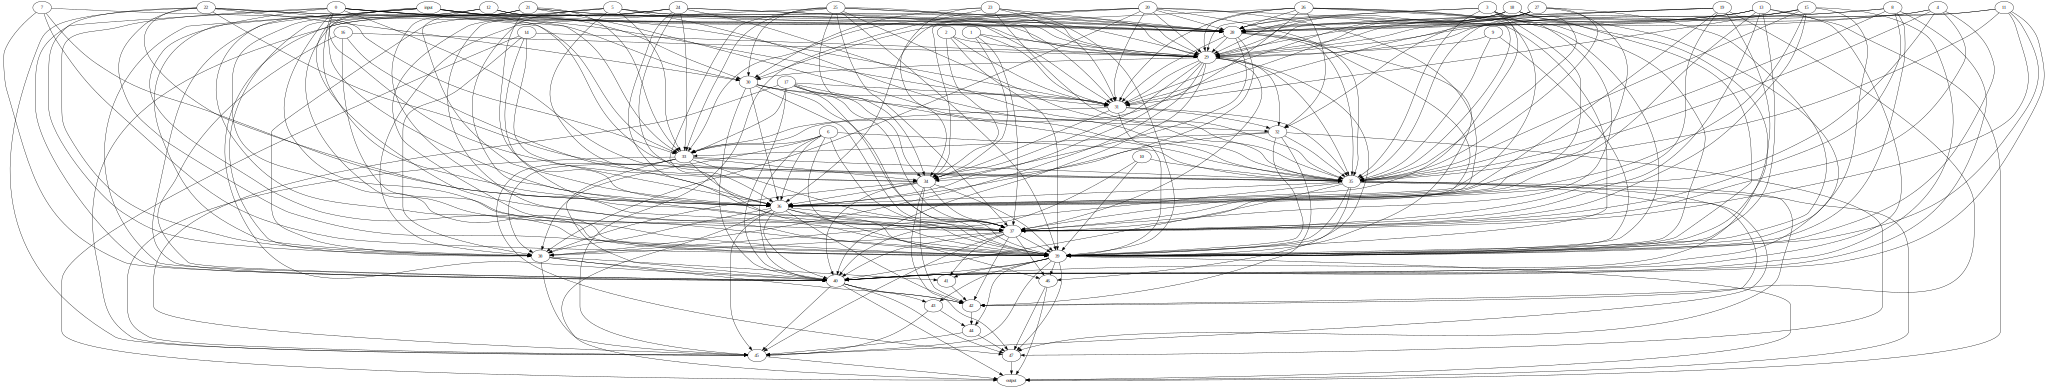

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 20.pkl
patching 516 edges, keeping 303 edges, 406 remain
patching 516 edges, keeping 303 edges, 406 remain
baseline score 2.940627336502075
[28] sized edge sets remaining
got scores tensor([2.8772], device='cuda:0')
splitting 28 edges into two edge sets, as they have score 2.8771824836730957 which has diff 0.06344485282897949 > 1e-05
patching 516 edges, keeping 303 edges, 406 remain
baseline score 2.940627336502075
[14, 14] sized edge sets remaining
got scores tensor([2.9108, 2.9226], device='cuda:0')
splitting 14 edges into two edge sets, as they have score 2.9107635021209717 which has diff 0.029863834381103516 > 1e-05
splitting 14 edges into two edge sets, as they have score 2.922640562057495 which has diff 0.017986774444580078 > 1e-05
patching 516 edges, keeping 303 edges, 406 remain
baseline score 2.940627336502075
[7, 7, 7, 7] sized edge sets remaining
got scores tensor([2.9099, 2.9438, 2.9520, 2.9216], device='cuda:0')
spli

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9348, 2.9571, 2.9556, 2.9549, 2.9440, 2.9572, 2.9585, 2.9339],
       device='cuda:0')
keeping edge edge  0 -> 27 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9347965717315674 which has diff 0.02157449722290039 > 1e-05
keeping edge edge  2 -> 27 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.95560622215271 which has diff 0.0007648468017578125 > 1e-05
keeping edge edge  3 -> 27 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9548792839050293 which has diff 0.0014917850494384766 > 1e-05
keeping edge edge  23 -> 27 (('blocks.23.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.27.hook

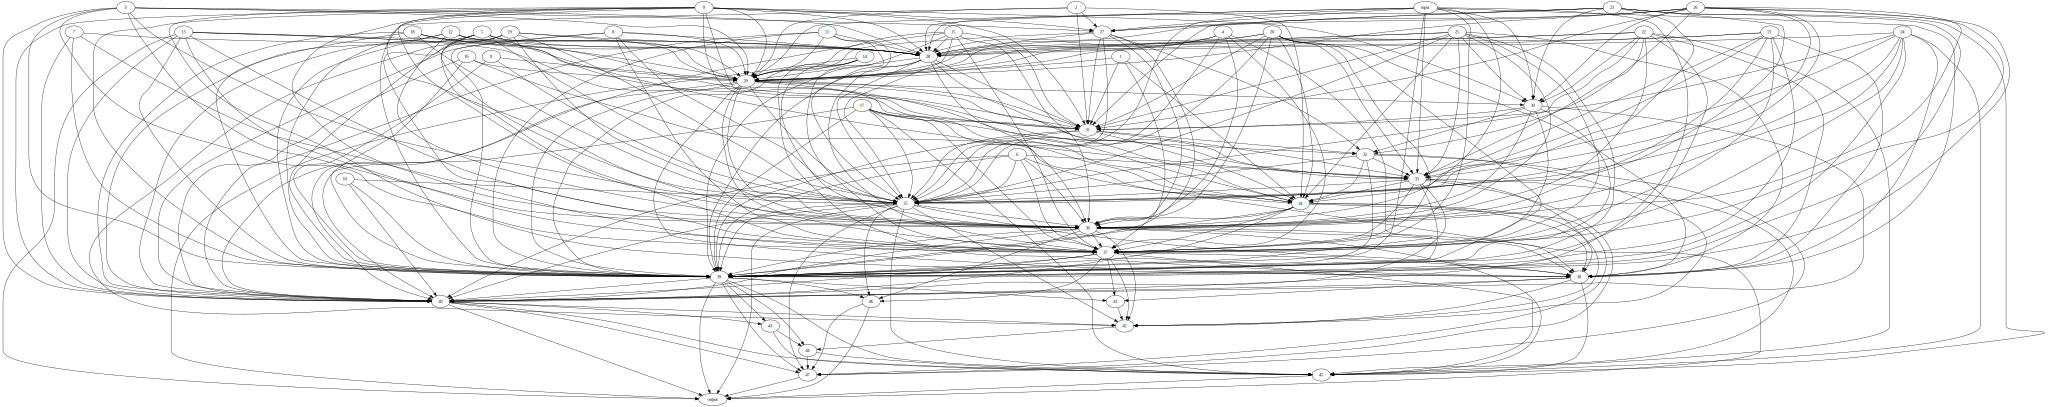

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 21.pkl
patching 538 edges, keeping 309 edges, 378 remain
patching 538 edges, keeping 309 edges, 378 remain
baseline score 2.9598803520202637
[27] sized edge sets remaining
got scores tensor([2.6681], device='cuda:0')
splitting 27 edges into two edge sets, as they have score 2.668133497238159 which has diff 0.2917468547821045 > 1e-05
patching 538 edges, keeping 309 edges, 378 remain
baseline score 2.9598803520202637
[13, 14] sized edge sets remaining
got scores tensor([2.8674, 2.7950], device='cuda:0')
splitting 13 edges into two edge sets, as they have score 2.867382764816284 which has diff 0.09249758720397949 > 1e-05
splitting 14 edges into two edge sets, as they have score 2.794977903366089 which has diff 0.1649024486541748 > 1e-05
patching 538 edges, keeping 309 edges, 378 remain
baseline score 2.9598803520202637
[6, 7, 7, 7] sized edge sets remaining
got scores tensor([2.8864, 2.9481, 2.9364, 2.8370], device='cuda:0')
splitti

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.8908, 2.9558, 2.9621, 2.9462, 2.9467, 2.9491, 2.8983, 2.9060],
       device='cuda:0')
splitting 3 edges into two edge sets, as they have score 2.8908236026763916 which has diff 0.06905674934387207 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.9557976722717285 which has diff 0.004082679748535156 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.9462056159973145 which has diff 0.013674736022949219 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.9466896057128906 which has diff 0.013190746307373047 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.9490957260131836 which has diff 0.010784626007080078 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.8983190059661865 which has diff 0.06156134605407715 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.906026601791382 which has diff 0.053853750228881836 > 1e-05
doing rollback test with score 2.9621059894561768 and s

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.9415, 2.9120, 2.9589, 2.9612, 2.9607, 2.9493, 2.9536, 2.9571, 2.9442,
        2.9692, 2.9403, 2.9230, 2.9632, 2.9108], device='cuda:0')
keeping edge edge  input -> 26 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.26.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.94146466255188 which has diff 0.020559310913085938 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9119653701782227 which has diff 0.050058603286743164 > 1e-05
keeping edge edge  2 -> 26 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.26.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.958892345428467 which has diff 0.0031316280364990234 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9611642360687256 which has diff 0.0008597373962402344 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.960679292678833 which has diff 0.0013

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([2.8994, 2.9722, 2.9661, 2.9671, 2.9667, 2.9657, 2.9640, 2.9554, 2.9580,
        2.9722, 2.9490, 2.9641, 2.9350, 2.9596, 2.9558, 2.9205],
       device='cuda:0')
keeping edge edge  0 -> 26 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.26.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.899442672729492 which has diff 0.06756472587585449 > 1e-05
keeping edge edge  3 -> 26 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.26.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.966134786605835 which has diff 0.0008726119995117188 > 1e-05
keeping edge edge  8 -> 26 (('blocks.8.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.26.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.966683864593506 which has diff 0.0003235340118408203 > 1e-05
keeping edge edge  9 -> 26 (('blocks.9.hook_out_

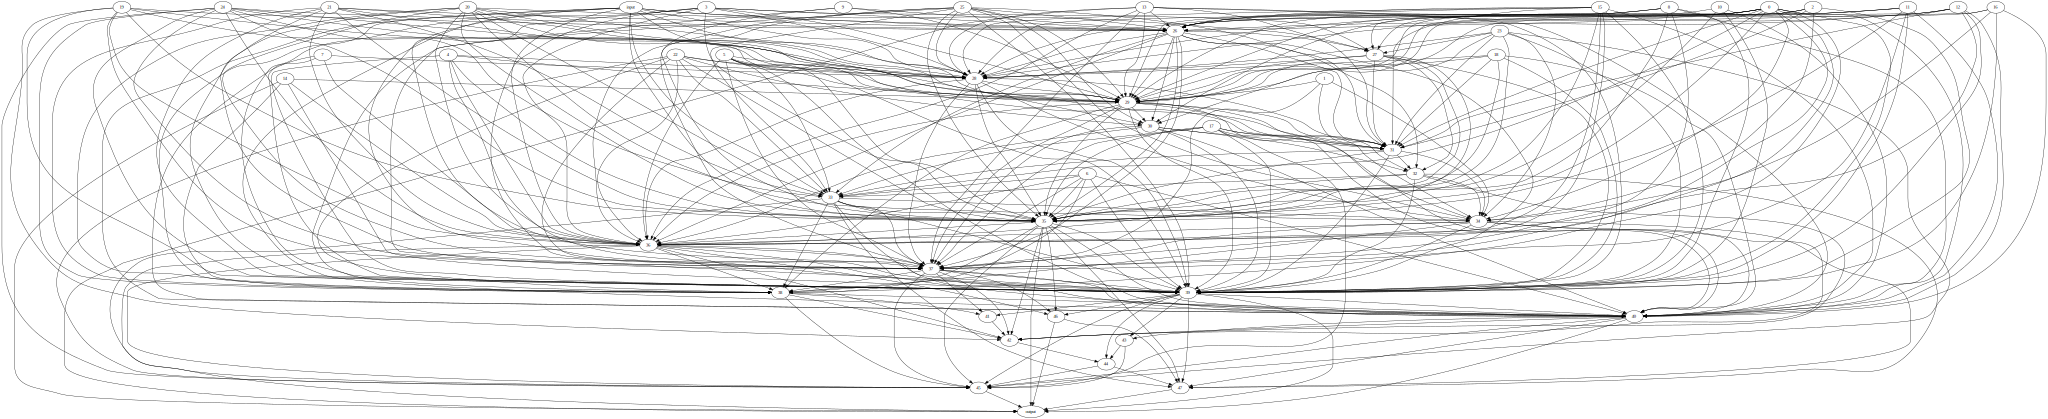

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 22.pkl
patching 548 edges, keeping 326 edges, 351 remain
patching 548 edges, keeping 326 edges, 351 remain
baseline score 2.9773380756378174
[26] sized edge sets remaining
got scores tensor([2.8598], device='cuda:0')
splitting 26 edges into two edge sets, as they have score 2.859849214553833 which has diff 0.11748886108398438 > 1e-05
patching 548 edges, keeping 326 edges, 351 remain
baseline score 2.9773380756378174
[13, 13] sized edge sets remaining
got scores tensor([2.9151, 2.9410], device='cuda:0')
splitting 13 edges into two edge sets, as they have score 2.9150683879852295 which has diff 0.06226968765258789 > 1e-05
splitting 13 edges into two edge sets, as they have score 2.9410173892974854 which has diff 0.03632068634033203 > 1e-05
patching 548 edges, keeping 326 edges, 351 remain
baseline score 2.9773380756378174
[6, 7, 6, 7] sized edge sets remaining
got scores tensor([2.9217, 2.9719, 2.9518, 2.9701], device='cuda:0')
spl

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9180, 2.9806, 2.9824, 2.9677, 2.9758, 2.9540, 2.9811, 2.9681],
       device='cuda:0')
splitting 3 edges into two edge sets, as they have score 2.9180498123168945 which has diff 0.05928826332092285 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.96770977973938 which has diff 0.0096282958984375 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.9758365154266357 which has diff 0.0015015602111816406 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.953997850418091 which has diff 0.023340225219726562 > 1e-05
splitting 4 edges into two edge sets, as they have score 2.968132257461548 which has diff 0.009205818176269531 > 1e-05
doing rollback test with score 2.9823672771453857 and score_lost_by_edge_set -0.005029201507568359 with edge set of size 3
doing rollback test with score 2.981132745742798 and score_lost_by_edge_set -0.0037946701049804688 with edge set of size 3
doing rollback test with score 2.980599880218506 and

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.9783, 2.9428, 2.9893, 2.9761, 2.9838, 2.9919, 2.9657, 2.9836, 2.9824,
        2.9833], device='cuda:0')
keeping edge edge  input -> 25 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.978341579437256 which has diff 0.010097265243530273 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9427733421325684 which has diff 0.04566550254821777 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.976050853729248 which has diff 0.012387990951538086 > 1e-05
keeping edge edge  12 -> 25 (('blocks.12.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.983842372894287 which has diff 0.0045964717864990234 > 1e-05
keeping edge edge  15 -> 25 (('blocks.15.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.25.hook_layer_in

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.9498, 2.9923, 2.9896, 2.9811, 2.9849, 2.9957, 2.9913, 2.9873, 2.9876,
        2.9924], device='cuda:0')
keeping edge edge  0 -> 25 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9497597217559814 which has diff 0.04286527633666992 > 1e-05
keeping edge edge  1 -> 25 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.992330312728882 which has diff 0.00029468536376953125 > 1e-05
keeping edge edge  10 -> 25 (('blocks.10.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.98956036567688 which has diff 0.0030646324157714844 > 1e-05
keeping edge edge  11 -> 25 (('blocks.11.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) 

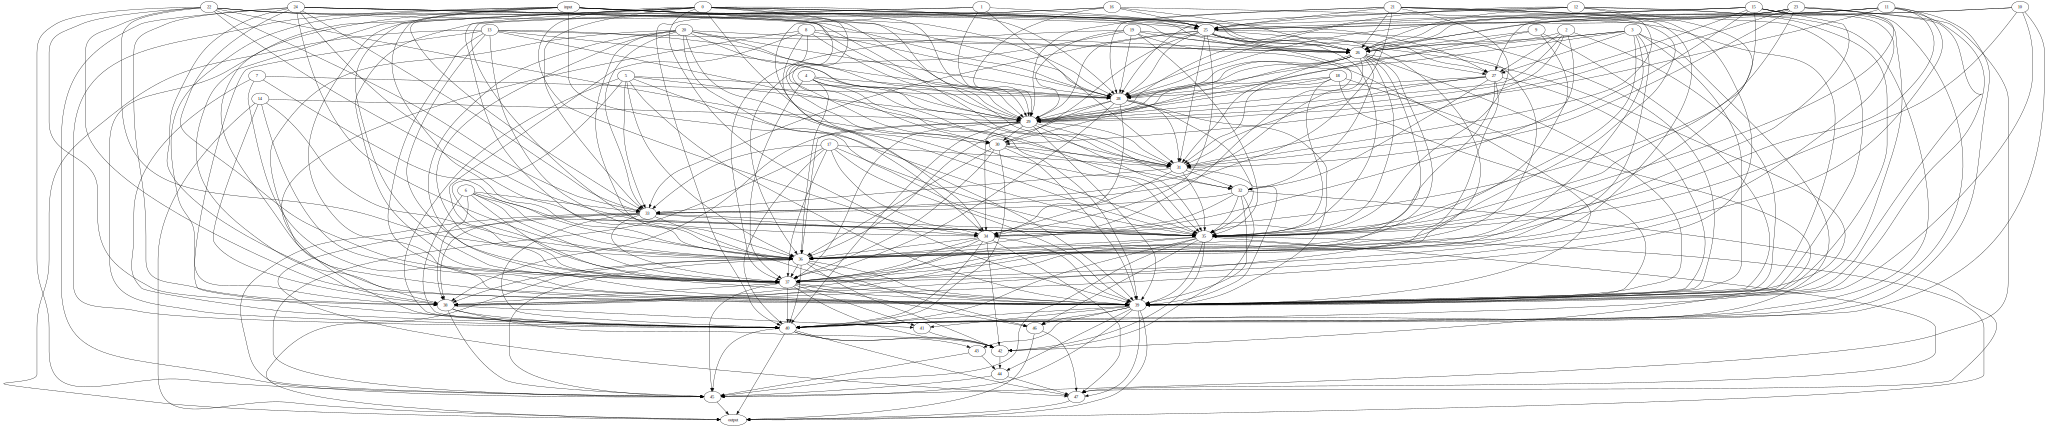

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 23.pkl
patching 562 edges, keeping 338 edges, 325 remain
patching 562 edges, keeping 338 edges, 325 remain
baseline score 2.9956512451171875
[25] sized edge sets remaining
got scores tensor([2.8860], device='cuda:0')
splitting 25 edges into two edge sets, as they have score 2.8859829902648926 which has diff 0.10966825485229492 > 1e-05
patching 562 edges, keeping 338 edges, 325 remain
baseline score 2.9956512451171875
[12, 13] sized edge sets remaining
got scores tensor([2.9537, 2.9568], device='cuda:0')
splitting 12 edges into two edge sets, as they have score 2.9536547660827637 which has diff 0.04199647903442383 > 1e-05
splitting 13 edges into two edge sets, as they have score 2.9567809104919434 which has diff 0.03887033462524414 > 1e-05
patching 562 edges, keeping 338 edges, 325 remain
baseline score 2.9956512451171875
[6, 6, 6, 7] sized edge sets remaining
got scores tensor([2.9534, 2.9980, 2.9889, 2.9681], device='cuda:0')
sp

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.9890, 2.9691, 2.9975, 2.9971, 2.9943, 2.9951, 2.9962, 2.9963, 3.0028,
        2.9706], device='cuda:0')
keeping edge edge  input -> 24 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.24.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9890379905700684 which has diff 0.009763479232788086 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.969133138656616 which has diff 0.029668331146240234 > 1e-05
keeping edge edge  2 -> 24 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.24.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.997453451156616 which has diff 0.0013480186462402344 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.9971115589141846 which has diff 0.001689910888671875 > 1e-05
keeping edge edge  14 -> 24 (('blocks.14.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.24.hook_layer_in

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.9717, 2.9995, 3.0018, 3.0022, 2.9999, 3.0015, 3.0052, 2.9970, 2.9920,
        2.9841], device='cuda:0')
keeping edge edge  0 -> 24 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.24.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9717278480529785 which has diff 0.03102731704711914 > 1e-05
keeping edge edge  1 -> 24 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.24.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9994735717773438 which has diff 0.0032815933227539062 > 1e-05
keeping edge edge  3 -> 24 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.24.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.001845598220825 which has diff 0.0009095668792724609 > 1e-05
keeping edge edge  4 -> 24 (('blocks.4.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> 

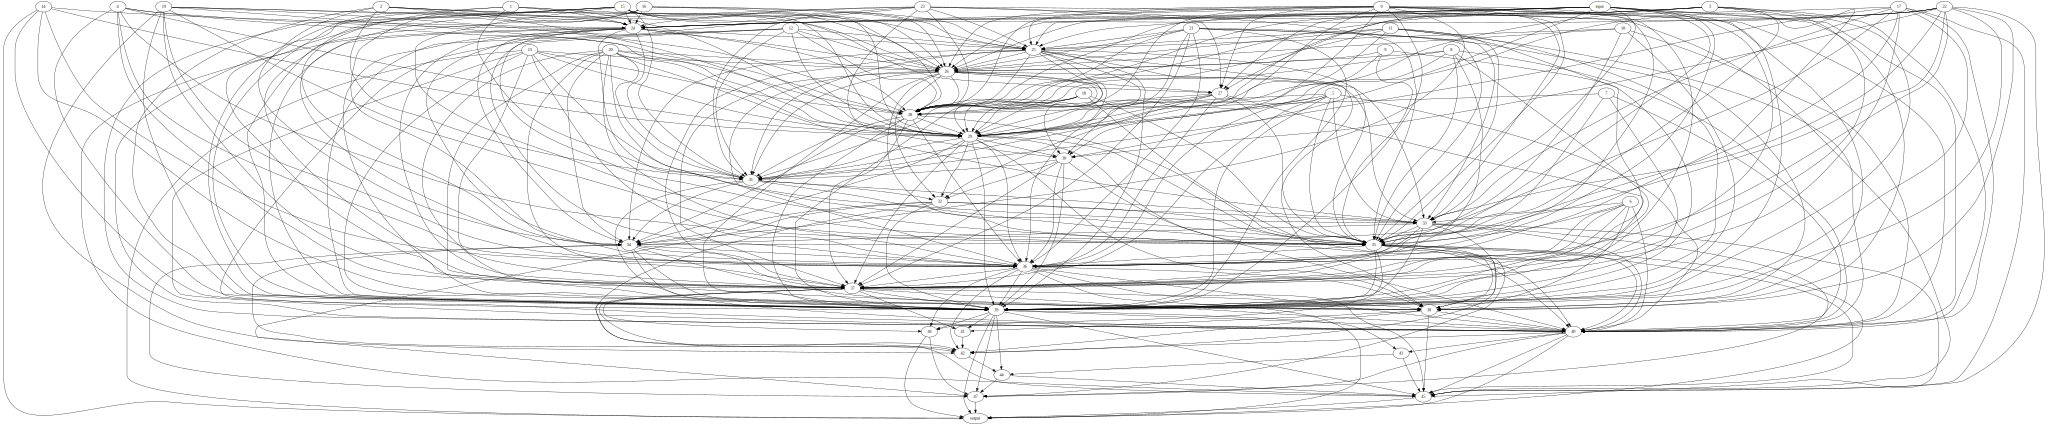

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 24.pkl
patching 574 edges, keeping 351 edges, 300 remain
patching 574 edges, keeping 351 edges, 300 remain
baseline score 3.0051395893096924
[24] sized edge sets remaining
got scores tensor([2.8769], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.8769237995147705 which has diff 0.12821578979492188 > 1e-05
patching 574 edges, keeping 351 edges, 300 remain
baseline score 3.0051395893096924
[12, 12] sized edge sets remaining
got scores tensor([2.9427, 2.9305], device='cuda:0')
splitting 12 edges into two edge sets, as they have score 2.942673683166504 which has diff 0.06246590614318848 > 1e-05
splitting 12 edges into two edge sets, as they have score 2.9305150508880615 which has diff 0.07462453842163086 > 1e-05
patching 574 edges, keeping 351 edges, 300 remain
baseline score 3.0051395893096924
[6, 6, 6, 6] sized edge sets remaining
got scores tensor([2.9417, 3.0063, 2.9448, 2.9934], device='cuda:0')
spl

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.9785, 2.9710, 3.0051, 3.0089, 3.0044, 2.9721, 3.0027, 2.9877, 2.9997,
        3.0012], device='cuda:0')
keeping edge edge  input -> 23 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.978482246398926 which has diff 0.028743743896484375 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.97104549407959 which has diff 0.03618049621582031 > 1e-05
keeping edge edge  2 -> 23 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0050735473632812 which has diff 0.0021524429321289062 > 1e-05
keeping edge edge  11 -> 23 (('blocks.11.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.004380464553833 which has diff 0.002845525741577148

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9671, 3.0139, 2.9831, 3.0002, 2.9892, 3.0098, 3.0134, 2.9976],
       device='cuda:0')
keeping edge edge  0 -> 23 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9671266078948975 which has diff 0.04166245460510254 > 1e-05
keeping edge edge  12 -> 23 (('blocks.12.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9830620288848877 which has diff 0.025727033615112305 > 1e-05
keeping edge edge  13 -> 23 (('blocks.13.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.000249147415161 which has diff 0.008539915084838867 > 1e-05
keeping edge edge  15 -> 23 (('blocks.15.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.23.h

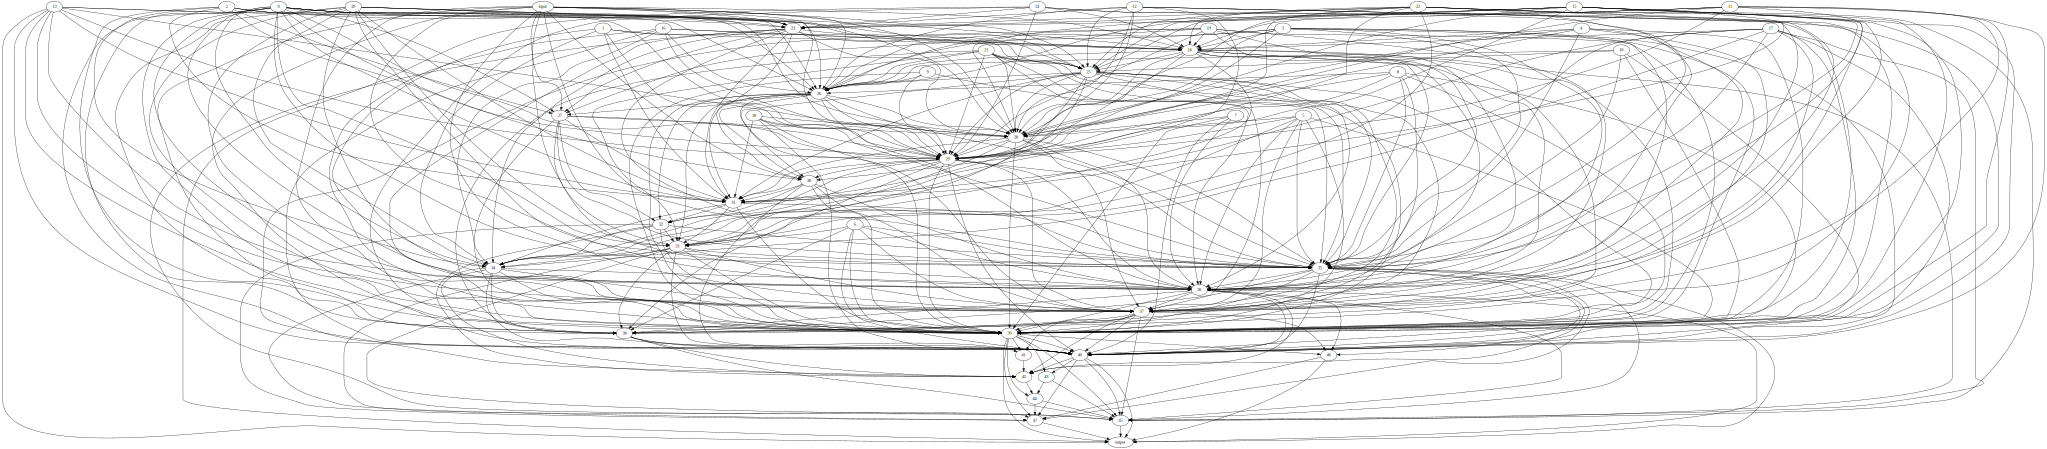

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 25.pkl
patching 588 edges, keeping 361 edges, 276 remain
patching 588 edges, keeping 361 edges, 276 remain
baseline score 3.0197978019714355
[23] sized edge sets remaining
got scores tensor([2.9116], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 2.9115865230560303 which has diff 0.10821127891540527 > 1e-05
patching 588 edges, keeping 361 edges, 276 remain
baseline score 3.0197978019714355
[11, 12] sized edge sets remaining
got scores tensor([2.9767, 2.9679], device='cuda:0')
splitting 11 edges into two edge sets, as they have score 2.9767041206359863 which has diff 0.04309368133544922 > 1e-05
splitting 12 edges into two edge sets, as they have score 2.967940092086792 which has diff 0.051857709884643555 > 1e-05
patching 588 edges, keeping 361 edges, 276 remain
baseline score 3.0197978019714355
[5, 6, 6, 6] sized edge sets remaining
got scores tensor([2.9810, 3.0148, 2.9999, 2.9902], device='cuda:0')
sp

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9831, 3.0167, 3.0194, 3.0154, 3.0064, 3.0126, 3.0204, 2.9881],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.9830610752105713 which has diff 0.03673672676086426 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.016737699508667 which has diff 0.0030601024627685547 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0193755626678467 which has diff 0.0004222393035888672 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0153603553771973 which has diff 0.004437446594238281 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0064289569854736 which has diff 0.013368844985961914 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0125885009765625 which has diff 0.007209300994873047 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.9880878925323486 which has diff 0.031709909439086914 > 1e-05
doing rollback test with score 3.020437002182007 and

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([3.0053, 2.9994, 3.0194, 3.0183, 3.0210, 3.0201, 3.0222, 3.0143, 3.0191,
        3.0094, 3.0224, 3.0100, 3.0103, 2.9999], device='cuda:0')
keeping edge edge  input -> 22 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0052733421325684 which has diff 0.015093326568603516 > 1e-05
keeping edge edge  0 -> 22 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.999354124069214 which has diff 0.021012544631958008 > 1e-05
keeping edge edge  1 -> 22 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.019364595413208 which has diff 0.0010020732879638672 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0183141231536865 wh

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([3.0256, 3.0214, 3.0243, 3.0245, 3.0195, 3.0238, 3.0145, 3.0240, 3.0268,
        3.0106, 3.0157, 3.0104], device='cuda:0')
keeping edge edge  3 -> 22 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0214290618896484 which has diff 0.00312042236328125 > 1e-05
keeping edge edge  5 -> 22 (('blocks.5.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0243217945098877 which has diff 0.0002276897430419922 > 1e-05
keeping edge edge  6 -> 22 (('blocks.6.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0245156288146973 which has diff 3.3855438232421875e-05 > 1e-05
keeping edge edge  8 -> 22 (('blocks.8.hook_out_proj', <function storage_hook at 0x

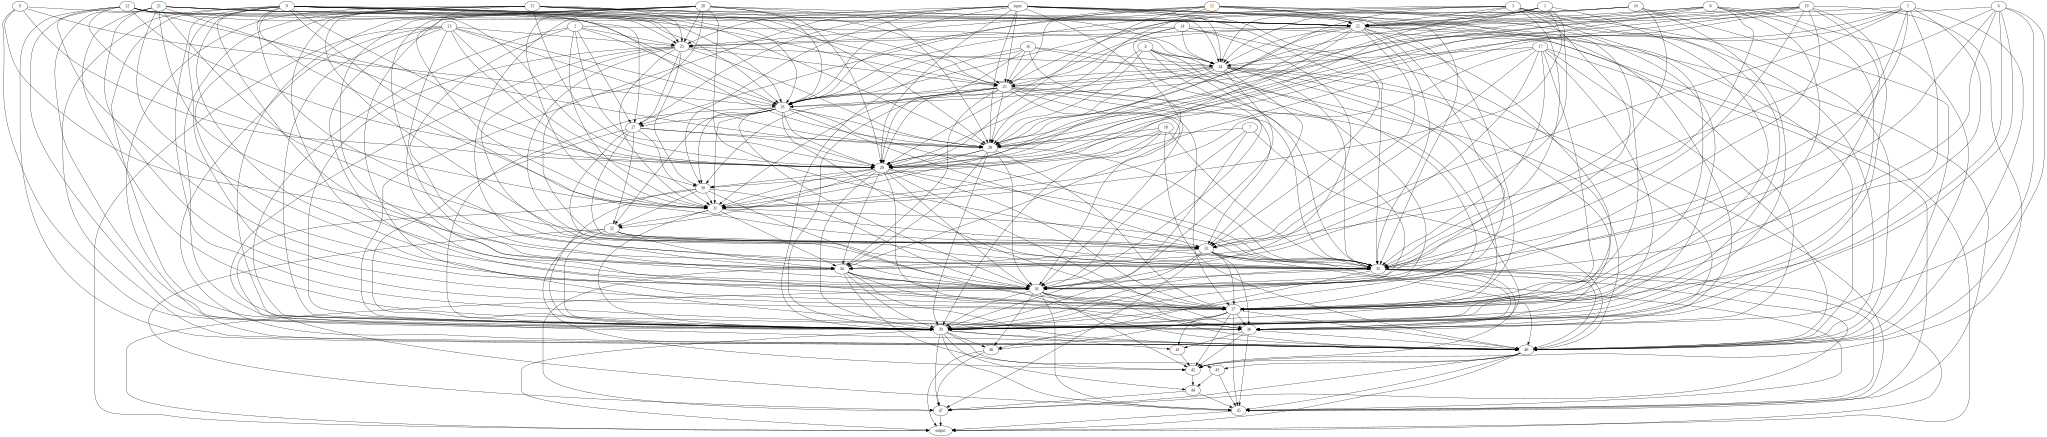

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 26.pkl
patching 596 edges, keeping 376 edges, 253 remain
patching 596 edges, keeping 376 edges, 253 remain
baseline score 3.0275542736053467
[22] sized edge sets remaining
got scores tensor([2.9605], device='cuda:0')
splitting 22 edges into two edge sets, as they have score 2.9604668617248535 which has diff 0.06708741188049316 > 1e-05
patching 596 edges, keeping 376 edges, 253 remain
baseline score 3.0275542736053467
[11, 11] sized edge sets remaining
got scores tensor([3.0071, 2.9909], device='cuda:0')
splitting 11 edges into two edge sets, as they have score 3.00712251663208 which has diff 0.0204317569732666 > 1e-05
splitting 11 edges into two edge sets, as they have score 2.9908905029296875 which has diff 0.03666377067565918 > 1e-05
patching 596 edges, keeping 376 edges, 253 remain
baseline score 3.0275542736053467
[5, 6, 5, 6] sized edge sets remaining
got scores tensor([3.0110, 3.0235, 3.0282, 2.9920], device='cuda:0')
split

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([3.0122, 3.0280, 3.0283, 3.0260, 3.0272, 3.0316, 3.0373, 3.0194, 3.0276,
        2.9988], device='cuda:0')
keeping edge edge  input -> 21 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.21.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0121700763702393 which has diff 0.017853736877441406 > 1e-05
keeping edge edge  0 -> 21 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.21.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.027974843978882 which has diff 0.002048969268798828 > 1e-05
keeping edge edge  4 -> 21 (('blocks.4.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.21.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0282909870147705 which has diff 0.0017328262329101562 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0259861946105957 which has diff 0.0040376186370849

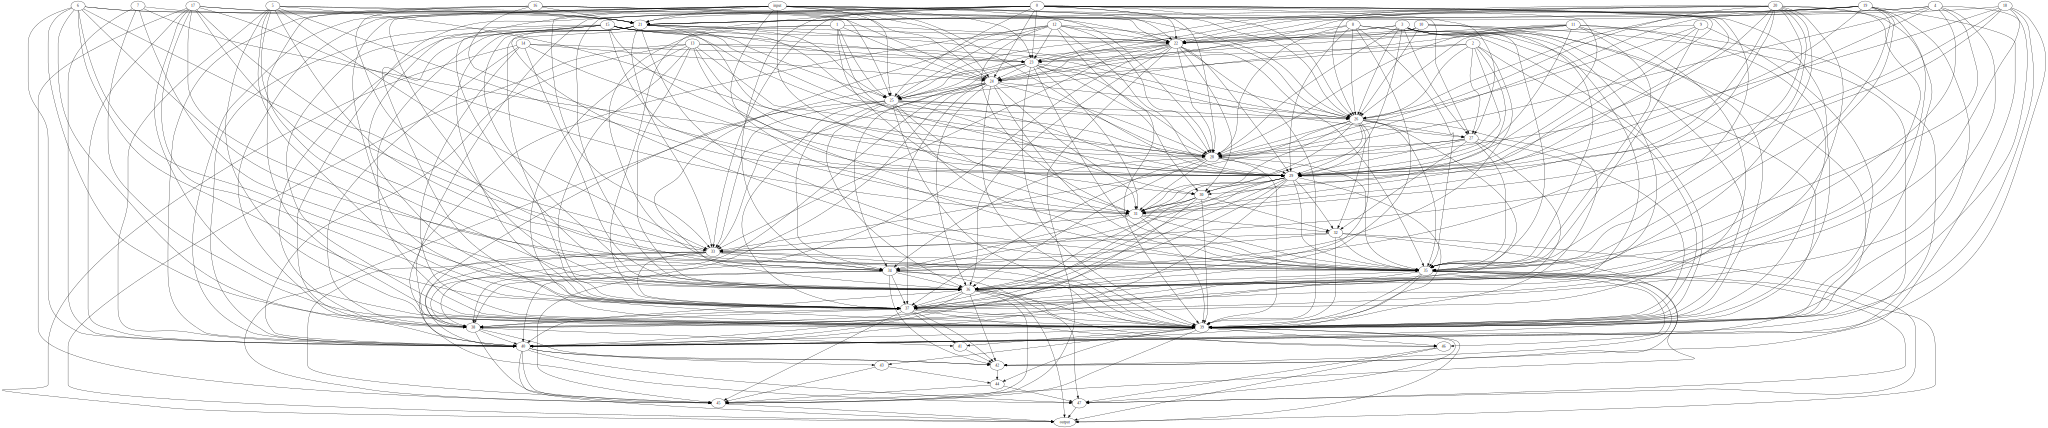

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 27.pkl
patching 607 edges, keeping 387 edges, 231 remain
patching 607 edges, keeping 387 edges, 231 remain
baseline score 3.037947654724121
[21] sized edge sets remaining
got scores tensor([2.7171], device='cuda:0')
splitting 21 edges into two edge sets, as they have score 2.717055559158325 which has diff 0.3208920955657959 > 1e-05
patching 607 edges, keeping 387 edges, 231 remain
baseline score 3.037947654724121
[10, 11] sized edge sets remaining
got scores tensor([2.8081, 2.9708], device='cuda:0')
splitting 10 edges into two edge sets, as they have score 2.8080835342407227 which has diff 0.22986412048339844 > 1e-05
splitting 11 edges into two edge sets, as they have score 2.9707531929016113 which has diff 0.06719446182250977 > 1e-05
patching 607 edges, keeping 387 edges, 231 remain
baseline score 3.037947654724121
[5, 5, 5, 6] sized edge sets remaining
got scores tensor([2.8311, 3.0210, 3.0175, 2.9923], device='cuda:0')
splitti

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.8445, 3.0299, 3.0345, 3.0251, 3.0403, 3.0163, 3.0232, 3.0092],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.8444859981536865 which has diff 0.19346165657043457 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0298798084259033 which has diff 0.008067846298217773 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.034456968307495 which has diff 0.0034906864166259766 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.025090217590332 which has diff 0.012857437133789062 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0163066387176514 which has diff 0.021641016006469727 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.023232936859131 which has diff 0.014714717864990234 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.009172201156616 which has diff 0.028775453567504883 > 1e-05
doing rollback test with score 3.0403409004211426 and sc

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.9917, 2.9166, 3.0354, 3.0377, 3.0375, 3.0394, 3.0381, 3.0289, 3.0219,
        3.0359, 3.0398, 3.0245, 3.0316, 3.0196], device='cuda:0')
keeping edge edge  input -> 20 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.20.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.991694211959839 which has diff 0.04855537414550781 > 1e-05
keeping edge edge  0 -> 20 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.20.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.916614294052124 which has diff 0.12363529205322266 > 1e-05
keeping edge edge  1 -> 20 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.20.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0353856086730957 which has diff 0.0048639774322509766 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0377485752105713 whic

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([3.0405, 3.0375, 3.0345, 3.0348, 3.0376, 3.0387, 3.0258, 3.0382, 3.0380,
        3.0206], device='cuda:0')
keeping edge edge  3 -> 20 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.20.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0375468730926514 which has diff 0.0027027130126953125 > 1e-05
keeping edge edge  7 -> 20 (('blocks.7.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.20.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.034499168395996 which has diff 0.005750417709350586 > 1e-05
keeping edge edge  8 -> 20 (('blocks.8.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.20.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.034846067428589 which has diff 0.0054035186767578125 > 1e-05
keeping edge edge  12 -> 20 (('blocks.12.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -

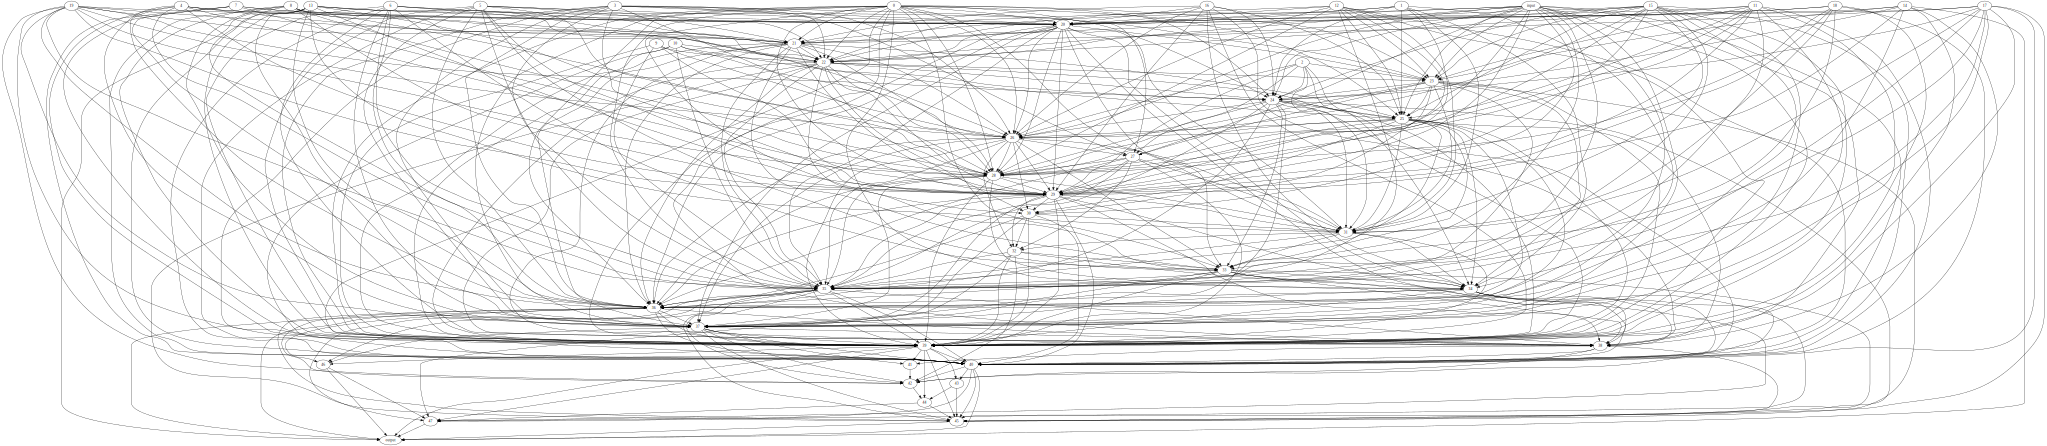

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 28.pkl
patching 610 edges, keeping 405 edges, 210 remain
patching 610 edges, keeping 405 edges, 210 remain
baseline score 3.0404043197631836
[20] sized edge sets remaining
got scores tensor([2.8660], device='cuda:0')
splitting 20 edges into two edge sets, as they have score 2.8659584522247314 which has diff 0.17444586753845215 > 1e-05
patching 610 edges, keeping 405 edges, 210 remain
baseline score 3.0404043197631836
[10, 10] sized edge sets remaining
got scores tensor([2.9279, 3.0016], device='cuda:0')
splitting 10 edges into two edge sets, as they have score 2.927886962890625 which has diff 0.1125173568725586 > 1e-05
splitting 10 edges into two edge sets, as they have score 3.001575231552124 which has diff 0.03882908821105957 > 1e-05
patching 610 edges, keeping 405 edges, 210 remain
baseline score 3.0404043197631836
[5, 5, 5, 5] sized edge sets remaining
got scores tensor([2.9399, 3.0298, 3.0219, 3.0209], device='cuda:0')
split

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9434, 3.0384, 3.0363, 3.0342, 3.0376, 3.0270, 3.0410, 3.0204],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.9434282779693604 which has diff 0.09697604179382324 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.038409948348999 which has diff 0.0019943714141845703 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.036280870437622 which has diff 0.0041234493255615234 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0341567993164062 which has diff 0.006247520446777344 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.037614345550537 which has diff 0.0027899742126464844 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.027029275894165 which has diff 0.013375043869018555 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0204341411590576 which has diff 0.019970178604125977 > 1e-05
doing rollback test with score 3.040971517562866 and s

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([3.0079, 2.9610, 3.0376, 3.0424, 3.0380, 3.0399, 3.0383, 3.0363, 3.0384,
        3.0395, 3.0349, 3.0321, 3.0386, 3.0229], device='cuda:0')
keeping edge edge  input -> 19 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0078682899475098 which has diff 0.03303074836730957 > 1e-05
keeping edge edge  0 -> 19 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.9609878063201904 which has diff 0.0799112319946289 > 1e-05
keeping edge edge  1 -> 19 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0376455783843994 which has diff 0.003253459930419922 > 1e-05
keeping edge edge  4 -> 19 (('blocks.4.hook_out_proj', <function storage_hook at

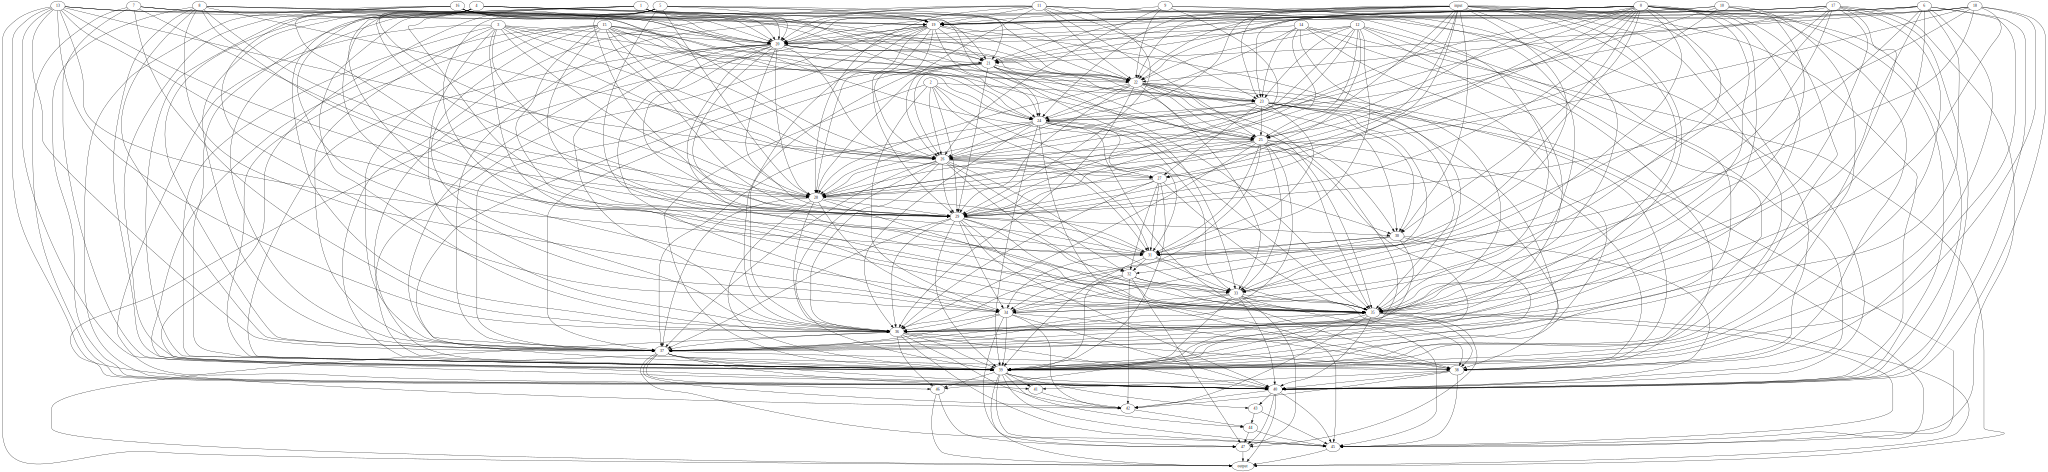

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 29.pkl
patching 615 edges, keeping 420 edges, 190 remain
patching 615 edges, keeping 420 edges, 190 remain
baseline score 3.0433995723724365
[19] sized edge sets remaining
got scores tensor([2.9691], device='cuda:0')
splitting 19 edges into two edge sets, as they have score 2.9691476821899414 which has diff 0.07425189018249512 > 1e-05
patching 615 edges, keeping 420 edges, 190 remain
baseline score 3.0433995723724365
[9, 10] sized edge sets remaining
got scores tensor([3.0113, 3.0069], device='cuda:0')
splitting 9 edges into two edge sets, as they have score 3.011277437210083 which has diff 0.032122135162353516 > 1e-05
splitting 10 edges into two edge sets, as they have score 3.0069420337677 which has diff 0.03645753860473633 > 1e-05
patching 615 edges, keeping 420 edges, 190 remain
baseline score 3.0433995723724365
[4, 5, 5, 5] sized edge sets remaining
got scores tensor([3.0091, 3.0501, 3.0296, 3.0226], device='cuda:0')
splitti

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.0462, 3.0205, 3.0485, 3.0411, 3.0492, 3.0438, 3.0467, 3.0414],
       device='cuda:0')
keeping edge edge  input -> 18 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.18.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0461905002593994 which has diff 0.005148649215698242 > 1e-05
keeping edge edge  0 -> 18 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.18.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0204594135284424 which has diff 0.030879735946655273 > 1e-05
keeping edge edge  10 -> 18 (('blocks.10.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.18.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.048468589782715 which has diff 0.0028705596923828125 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.041064977645874 which has diff 0.010274171829223633 > 1e-05
keepi

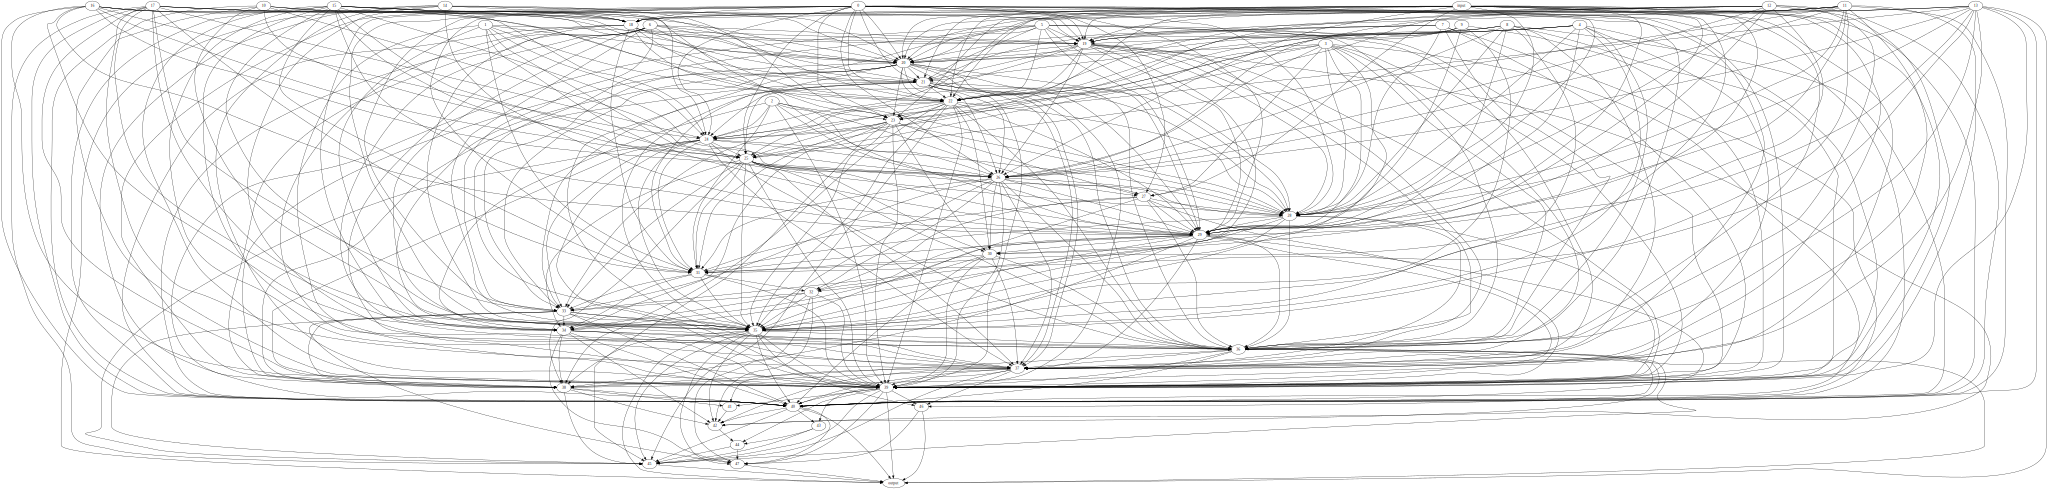

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 30.pkl
patching 624 edges, keeping 430 edges, 171 remain
patching 624 edges, keeping 430 edges, 171 remain
baseline score 3.0513391494750977
[18] sized edge sets remaining
got scores tensor([2.9665], device='cuda:0')
splitting 18 edges into two edge sets, as they have score 2.9664931297302246 which has diff 0.08484601974487305 > 1e-05
patching 624 edges, keeping 430 edges, 171 remain
baseline score 3.0513391494750977
[9, 9] sized edge sets remaining
got scores tensor([2.9769, 3.0442], device='cuda:0')
splitting 9 edges into two edge sets, as they have score 2.976893901824951 which has diff 0.07444524765014648 > 1e-05
splitting 9 edges into two edge sets, as they have score 3.0441863536834717 which has diff 0.0071527957916259766 > 1e-05
patching 624 edges, keeping 430 edges, 171 remain
baseline score 3.0513391494750977
[4, 5, 4, 5] sized edge sets remaining
got scores tensor([2.9807, 3.0462, 3.0467, 3.0490], device='cuda:0')
split

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.9832, 3.0485, 3.0548, 3.0427, 3.0506, 3.0478, 3.0476, 3.0523],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.983215808868408 which has diff 0.06812334060668945 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.048521041870117 which has diff 0.0028181076049804688 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.0426547527313232 which has diff 0.008684396743774414 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0505897998809814 which has diff 0.0007493495941162109 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0478453636169434 which has diff 0.003493785858154297 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.047606945037842 which has diff 0.0037322044372558594 > 1e-05
doing rollback test with score 3.0548312664031982 and score_lost_by_edge_set -0.003492116928100586 with edge set of size 2
doing rollback test with score 3.0522823333740234 

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([3.0172, 3.0358, 3.0516, 3.0549, 3.0541, 3.0477, 3.0538, 3.0548, 3.0532,
        3.0526, 3.0536, 3.0521], device='cuda:0')
keeping edge edge  input -> 17 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0172200202941895 which has diff 0.037625789642333984 > 1e-05
keeping edge edge  0 -> 17 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0358378887176514 which has diff 0.01900792121887207 > 1e-05
keeping edge edge  1 -> 17 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.051579713821411 which has diff 0.0032660961151123047 > 1e-05
keeping edge edge  5 -> 17 (('blocks.5.hook_out_proj', <function storage_hook at 0x7fb524c0a44

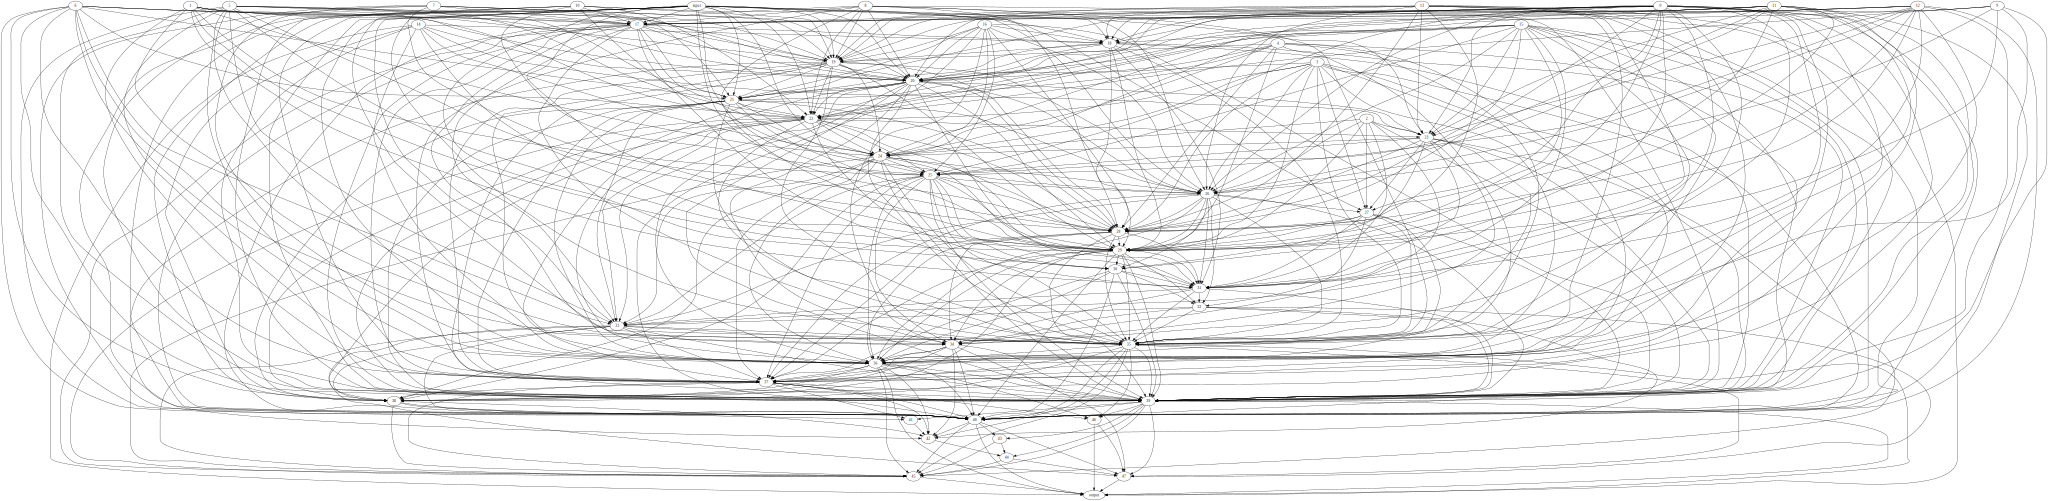

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 31.pkl
patching 630 edges, keeping 442 edges, 153 remain
patching 630 edges, keeping 442 edges, 153 remain
baseline score 3.054823637008667
[17] sized edge sets remaining
got scores tensor([2.9950], device='cuda:0')
splitting 17 edges into two edge sets, as they have score 2.995032787322998 which has diff 0.059790849685668945 > 1e-05
patching 630 edges, keeping 442 edges, 153 remain
baseline score 3.054823637008667
[8, 9] sized edge sets remaining
got scores tensor([3.0156, 3.0334], device='cuda:0')
splitting 8 edges into two edge sets, as they have score 3.015568733215332 which has diff 0.03925490379333496 > 1e-05
splitting 9 edges into two edge sets, as they have score 3.0333683490753174 which has diff 0.02145528793334961 > 1e-05
patching 630 edges, keeping 442 edges, 153 remain
baseline score 3.054823637008667
[4, 4, 4, 5] sized edge sets remaining
got scores tensor([3.0160, 3.0547, 3.0501, 3.0412], device='cuda:0')
splitting 

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.0168, 3.0543, 3.0549, 3.0547, 3.0494, 3.0564, 3.0458, 3.0503],
       device='cuda:0')
splitting 2 edges into two edge sets, as they have score 3.0168418884277344 which has diff 0.03798174858093262 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0542638301849365 which has diff 0.0005598068237304688 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.054748058319092 which has diff 7.557868957519531e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.049407482147217 which has diff 0.005416154861450195 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.045774459838867 which has diff 0.009049177169799805 > 1e-05
splitting 3 edges into two edge sets, as they have score 3.05029034614563 which has diff 0.004533290863037109 > 1e-05
doing rollback test with score 3.056443929672241 and score_lost_by_edge_set -0.0016202926635742188 with edge set of size 2
doing rollback test with score 3.054901123046875 and 

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([3.0497, 3.0229, 3.0540, 3.0570, 3.0562, 3.0553, 3.0497, 3.0560, 3.0533,
        3.0497, 3.0536, 3.0520], device='cuda:0')
keeping edge edge  input -> 16 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.16.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.049705743789673 which has diff 0.006140708923339844 > 1e-05
keeping edge edge  0 -> 16 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.16.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.022911310195923 which has diff 0.032935142517089844 > 1e-05
keeping edge edge  1 -> 16 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.16.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.054042339324951 which has diff 0.0018041133880615234 > 1e-05
keeping edge edge  6 -> 16 (('blocks.6.hook_out_proj', <function storage_hook at 0x7fb524c0a440

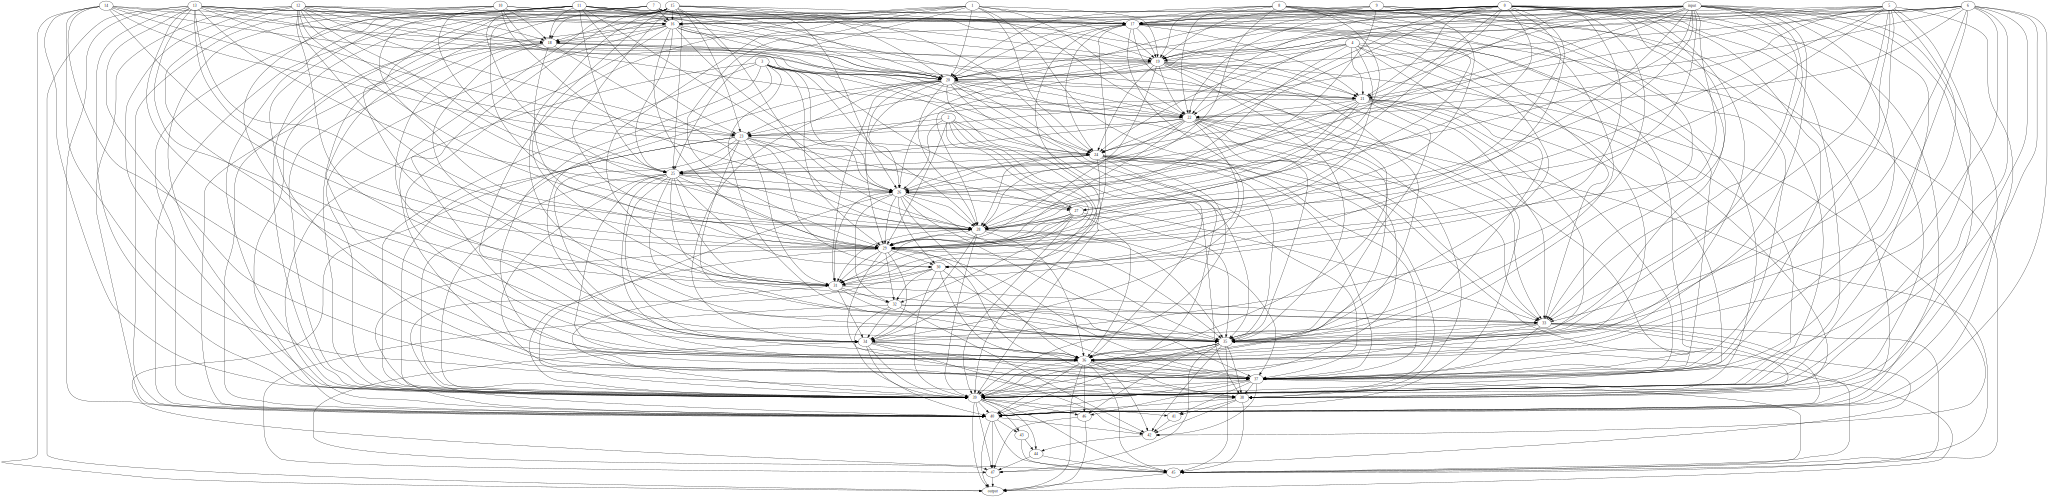

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 32.pkl
patching 637 edges, keeping 452 edges, 136 remain
patching 637 edges, keeping 452 edges, 136 remain
baseline score 3.05715274810791
[16] sized edge sets remaining
got scores tensor([2.7807], device='cuda:0')
splitting 16 edges into two edge sets, as they have score 2.7806994915008545 which has diff 0.27645325660705566 > 1e-05
patching 637 edges, keeping 452 edges, 136 remain
baseline score 3.05715274810791
[8, 8] sized edge sets remaining
got scores tensor([2.8247, 3.0214], device='cuda:0')
splitting 8 edges into two edge sets, as they have score 2.824662446975708 which has diff 0.23249030113220215 > 1e-05
splitting 8 edges into two edge sets, as they have score 3.021379232406616 which has diff 0.035773515701293945 > 1e-05
patching 637 edges, keeping 452 edges, 136 remain
baseline score 3.05715274810791
[4, 4, 4, 4] sized edge sets remaining
got scores tensor([2.8300, 3.0598, 3.0496, 3.0233], device='cuda:0')
splitting 4 e

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([3.0199, 2.9079, 3.0572, 3.0571, 3.0629, 3.0559, 3.0552, 3.0563, 3.0354,
        3.0579, 3.0701, 3.0470], device='cuda:0')
keeping edge edge  input -> 15 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.019897937774658 which has diff 0.039772987365722656 > 1e-05
keeping edge edge  0 -> 15 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.907949686050415 which has diff 0.15172123908996582 > 1e-05
keeping edge edge  1 -> 15 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.05715274810791 which has diff 0.002518177032470703 > 1e-05
keeping edge edge  2 -> 15 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) 

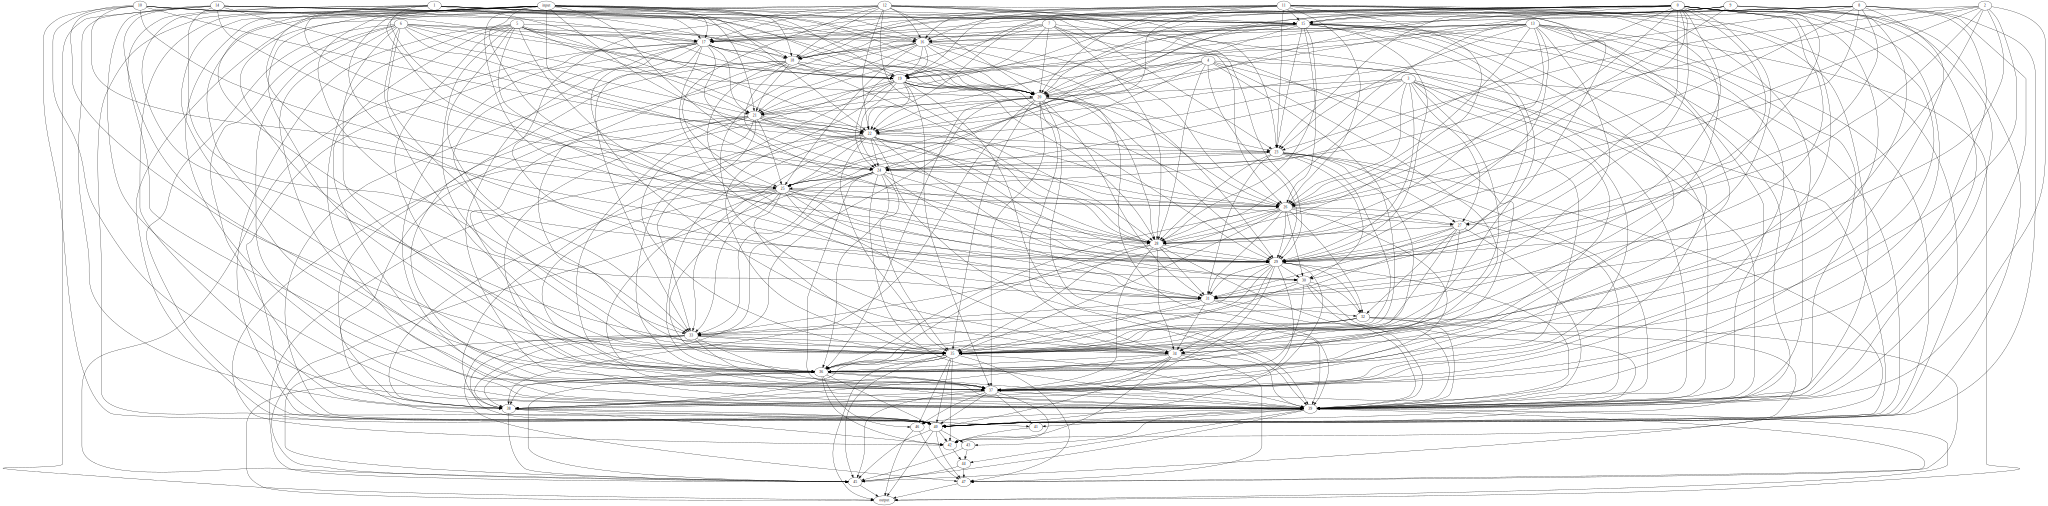

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 33.pkl
patching 643 edges, keeping 462 edges, 120 remain
patching 643 edges, keeping 462 edges, 120 remain
baseline score 3.0733425617218018
[15] sized edge sets remaining
got scores tensor([3.0178], device='cuda:0')
splitting 15 edges into two edge sets, as they have score 3.017824649810791 which has diff 0.05551791191101074 > 1e-05
patching 643 edges, keeping 462 edges, 120 remain
baseline score 3.0733425617218018
[7, 8] sized edge sets remaining
got scores tensor([3.0335, 3.0587], device='cuda:0')
splitting 7 edges into two edge sets, as they have score 3.03350567817688 which has diff 0.039836883544921875 > 1e-05
splitting 8 edges into two edge sets, as they have score 3.058697462081909 which has diff 0.014645099639892578 > 1e-05
patching 643 edges, keeping 462 edges, 120 remain
baseline score 3.0733425617218018
[3, 4, 4, 4] sized edge sets remaining
got scores tensor([3.0358, 3.0693, 3.0667, 3.0659], device='cuda:0')
splittin

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.0493, 3.0600, 3.0733, 3.0695, 3.0715, 3.0686, 3.0691, 3.0706],
       device='cuda:0')
keeping edge edge  input -> 14 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.14.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.049251079559326 which has diff 0.024091482162475586 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.059950590133667 which has diff 0.013391971588134766 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.073277473449707 which has diff 6.508827209472656e-05 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.069476842880249 which has diff 0.0038657188415527344 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.071476697921753 which has diff 0.0018658638000488281 > 1e-05
splitting 2 edges into two edge sets, as they have score 3.0686447620391846 which has diff 0.0046977996826171875 > 1e-05
splitting 2 edges into two edge sets, as th

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([3.0607, 3.0729, 3.0745, 3.0722, 3.0703, 3.0726, 3.0707, 3.0741, 3.0725,
        3.0698, 3.0744, 3.0683, 3.0744, 3.0694], device='cuda:0')
keeping edge edge  0 -> 14 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.14.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.06070613861084 which has diff 0.012636423110961914 > 1e-05
keeping edge edge  1 -> 14 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.14.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.072899341583252 which has diff 0.0004432201385498047 > 1e-05
keeping edge edge  3 -> 14 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.14.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0722362995147705 which has diff 0.00110626220703125 > 1e-05
keeping edge edge  4 -> 14 (('blocks.4.hook_out_proj', <function storage

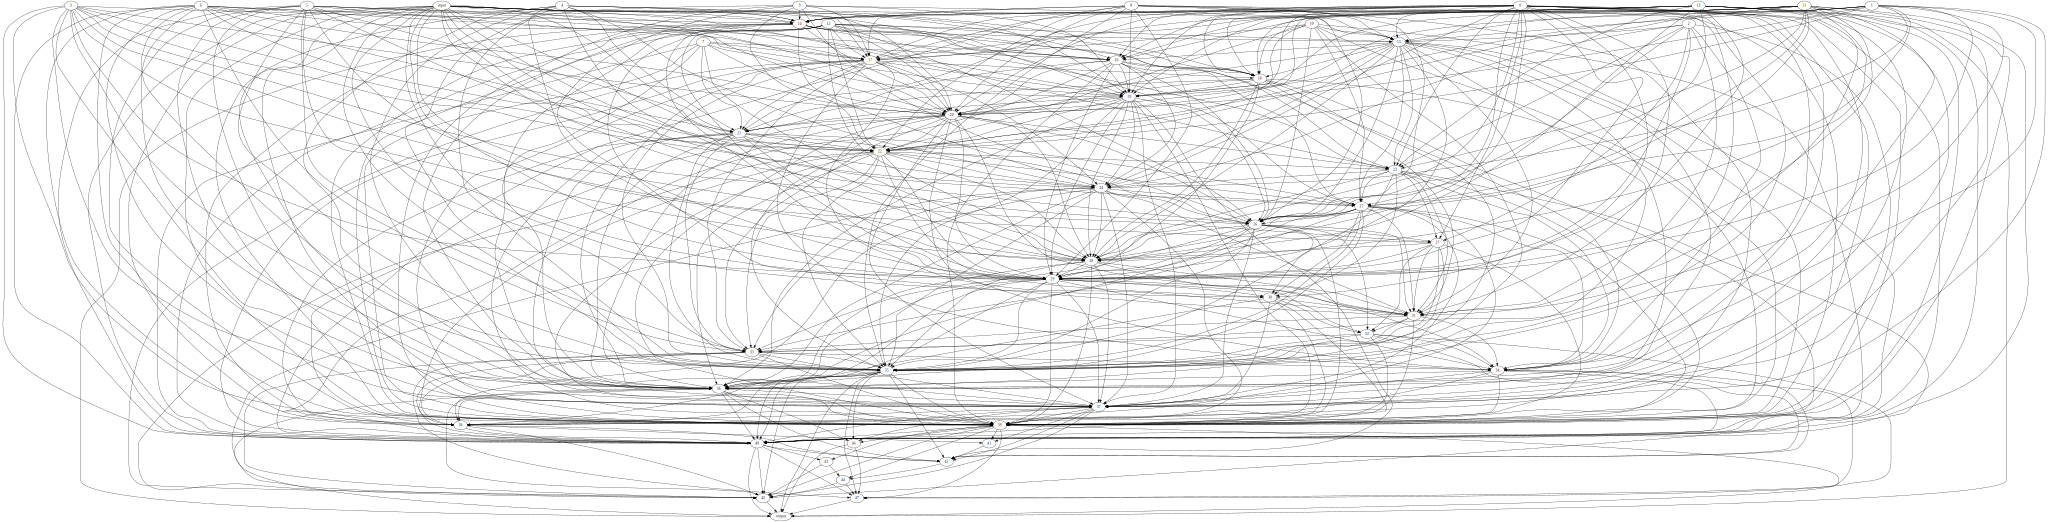

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 34.pkl
patching 647 edges, keeping 473 edges, 105 remain
patching 647 edges, keeping 473 edges, 105 remain
baseline score 3.0768532752990723
[14] sized edge sets remaining
got scores tensor([2.9853], device='cuda:0')
splitting 14 edges into two edge sets, as they have score 2.9852757453918457 which has diff 0.09157752990722656 > 1e-05
patching 647 edges, keeping 473 edges, 105 remain
baseline score 3.0768532752990723
[7, 7] sized edge sets remaining
got scores tensor([3.0125, 3.0447], device='cuda:0')
splitting 7 edges into two edge sets, as they have score 3.0125436782836914 which has diff 0.06430959701538086 > 1e-05
splitting 7 edges into two edge sets, as they have score 3.0447399616241455 which has diff 0.03211331367492676 > 1e-05
patching 647 edges, keeping 473 edges, 105 remain
baseline score 3.0768532752990723
[3, 4, 3, 4] sized edge sets remaining
got scores tensor([3.0107, 3.0742, 3.0778, 3.0422], device='cuda:0')
splitt

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.0328, 3.0748, 3.0882, 3.0742, 3.0835, 3.0802, 3.0611, 3.0802],
       device='cuda:0')
keeping edge edge  0 -> 13 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0328450202941895 which has diff 0.0533452033996582 > 1e-05
keeping edge edge  1 -> 13 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0747599601745605 which has diff 0.01143026351928711 > 1e-05
keeping edge edge  3 -> 13 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0742244720458984 which has diff 0.011965751647949219 > 1e-05
keeping edge edge  9 -> 13 (('blocks.9.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.13.hook_lay

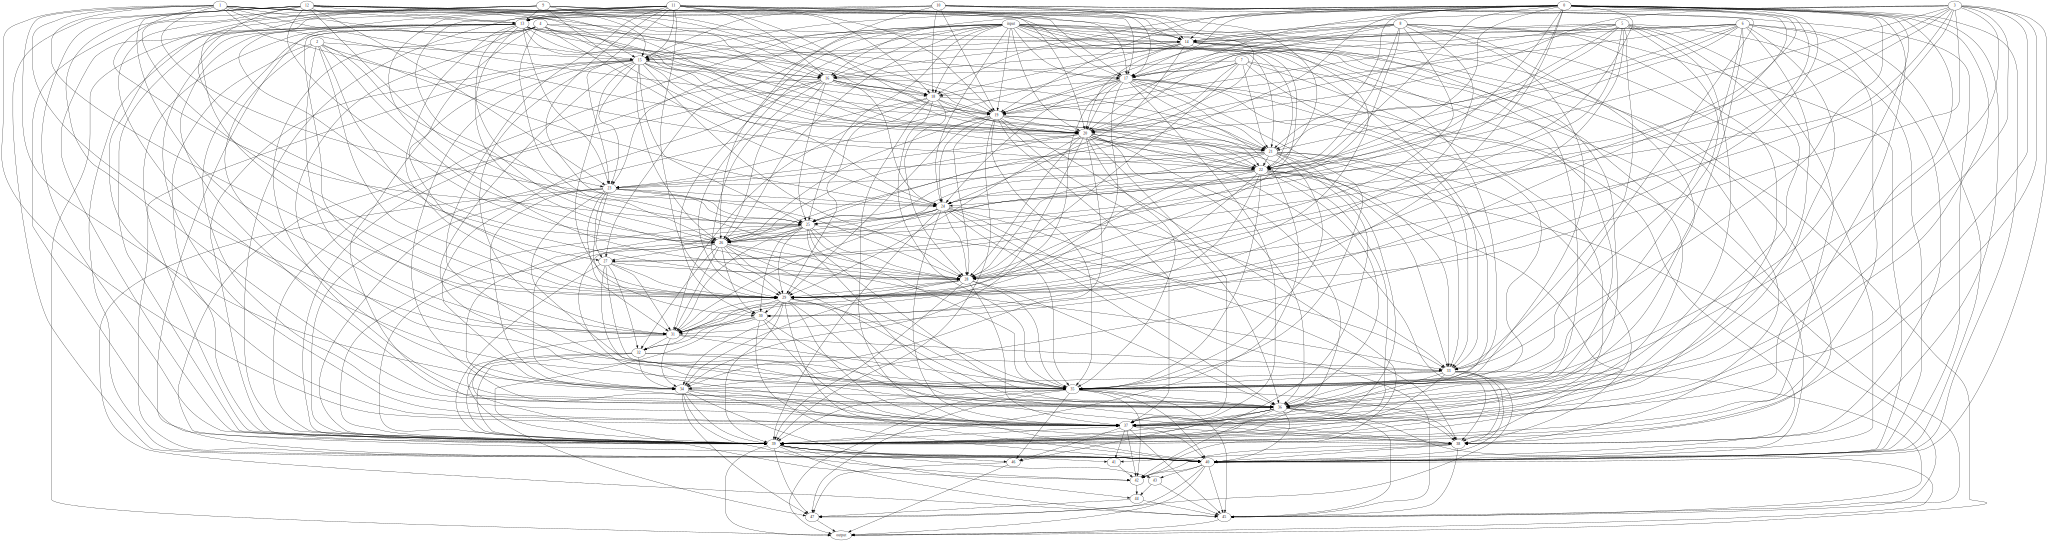

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 35.pkl
patching 654 edges, keeping 480 edges, 91 remain
patching 654 edges, keeping 480 edges, 91 remain
baseline score 3.0881102085113525
[13] sized edge sets remaining
got scores tensor([2.9426], device='cuda:0')
splitting 13 edges into two edge sets, as they have score 2.9426116943359375 which has diff 0.14549851417541504 > 1e-05
patching 654 edges, keeping 480 edges, 91 remain
baseline score 3.0881102085113525
[6, 7] sized edge sets remaining
got scores tensor([2.9657, 3.0691], device='cuda:0')
splitting 6 edges into two edge sets, as they have score 2.9656970500946045 which has diff 0.12241315841674805 > 1e-05
splitting 7 edges into two edge sets, as they have score 3.069077491760254 which has diff 0.019032716751098633 > 1e-05
patching 654 edges, keeping 480 edges, 91 remain
baseline score 3.0881102085113525
[3, 3, 3, 4] sized edge sets remaining
got scores tensor([2.9630, 3.0931, 3.0955, 3.0585], device='cuda:0')
splitting 

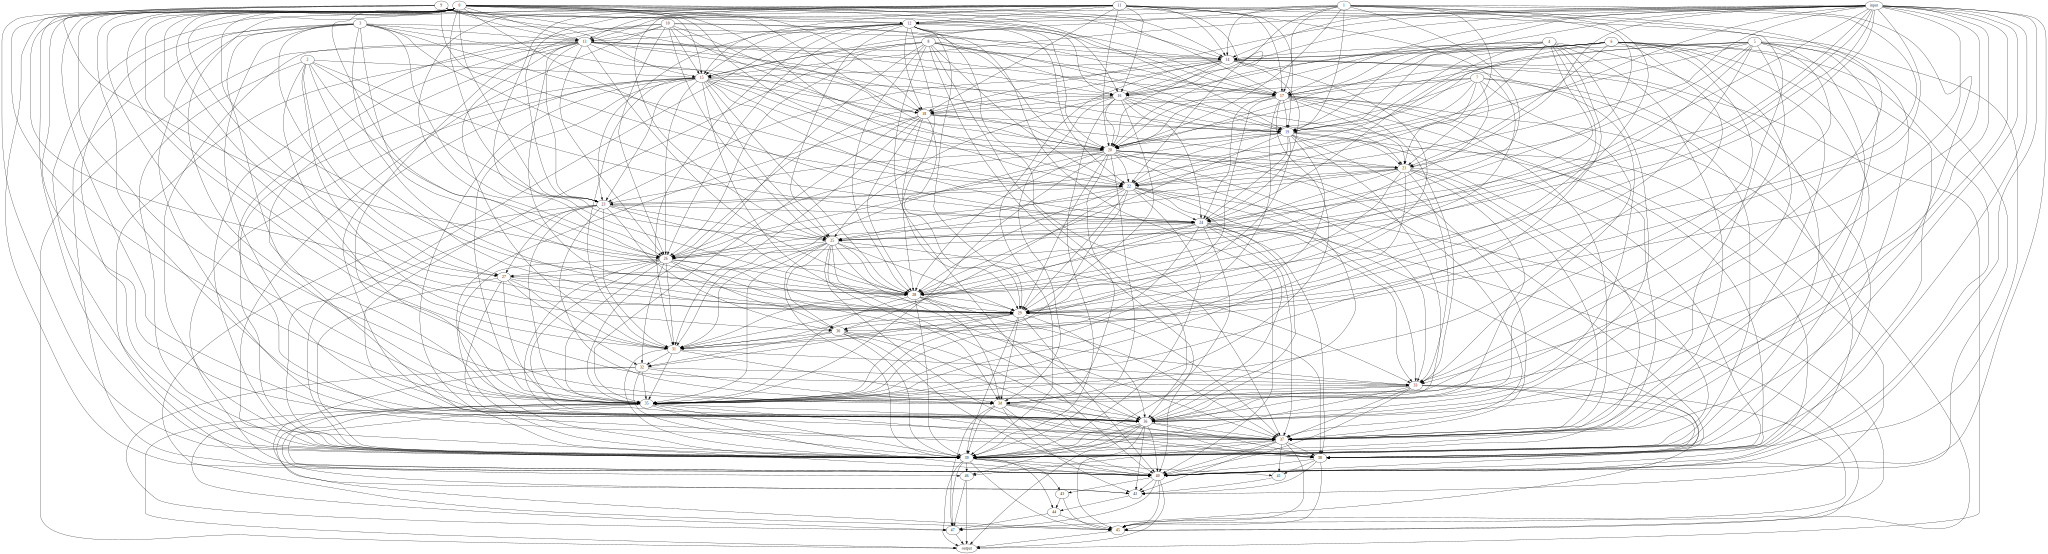

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 36.pkl
patching 662 edges, keeping 485 edges, 78 remain
patching 662 edges, keeping 485 edges, 78 remain
baseline score 3.1064257621765137
[12] sized edge sets remaining
got scores tensor([2.9226], device='cuda:0')
splitting 12 edges into two edge sets, as they have score 2.922607421875 which has diff 0.18381834030151367 > 1e-05
patching 662 edges, keeping 485 edges, 78 remain
baseline score 3.1064257621765137
[6, 6] sized edge sets remaining
got scores tensor([2.9766, 3.1031], device='cuda:0')
splitting 6 edges into two edge sets, as they have score 2.9766478538513184 which has diff 0.1297779083251953 > 1e-05
splitting 6 edges into two edge sets, as they have score 3.103125810623169 which has diff 0.0032999515533447266 > 1e-05
patching 662 edges, keeping 485 edges, 78 remain
baseline score 3.1064257621765137
[3, 3, 3, 3] sized edge sets remaining
got scores tensor([2.9856, 3.1128, 3.0987, 3.1105], device='cuda:0')
splitting 3 ed

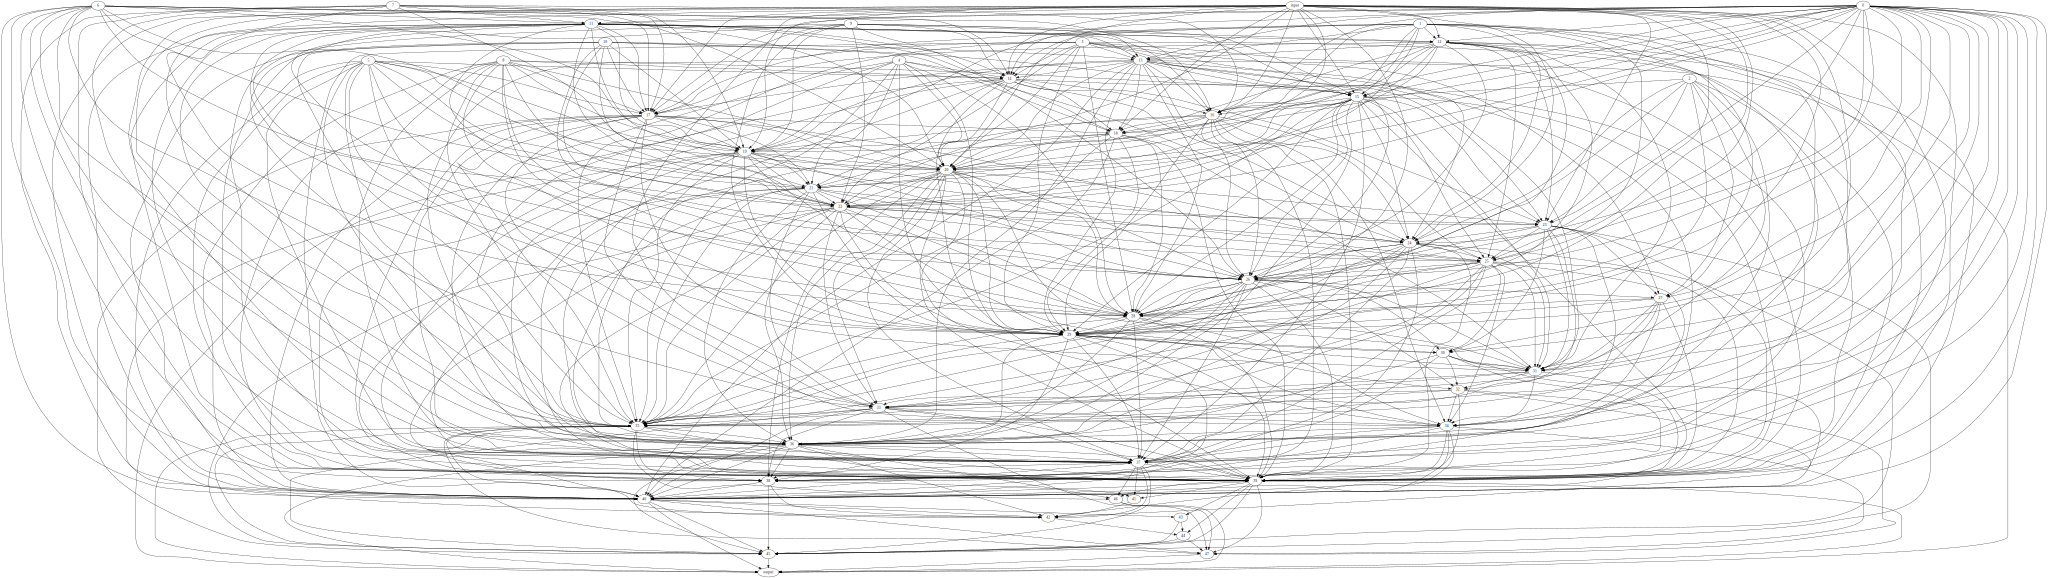

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 37.pkl
patching 670 edges, keeping 489 edges, 66 remain
patching 670 edges, keeping 489 edges, 66 remain
baseline score 3.121746778488159
[11] sized edge sets remaining
got scores tensor([3.0616], device='cuda:0')
splitting 11 edges into two edge sets, as they have score 3.0615880489349365 which has diff 0.060158729553222656 > 1e-05
patching 670 edges, keeping 489 edges, 66 remain
baseline score 3.121746778488159
[5, 6] sized edge sets remaining
got scores tensor([3.0696, 3.1194], device='cuda:0')
splitting 5 edges into two edge sets, as they have score 3.069570779800415 which has diff 0.05217599868774414 > 1e-05
splitting 6 edges into two edge sets, as they have score 3.1193950176239014 which has diff 0.0023517608642578125 > 1e-05
patching 670 edges, keeping 489 edges, 66 remain
baseline score 3.121746778488159
[2, 3, 3, 3] sized edge sets remaining
got scores tensor([3.0742, 3.1191, 3.1196, 3.1228], device='cuda:0')
splitting 2

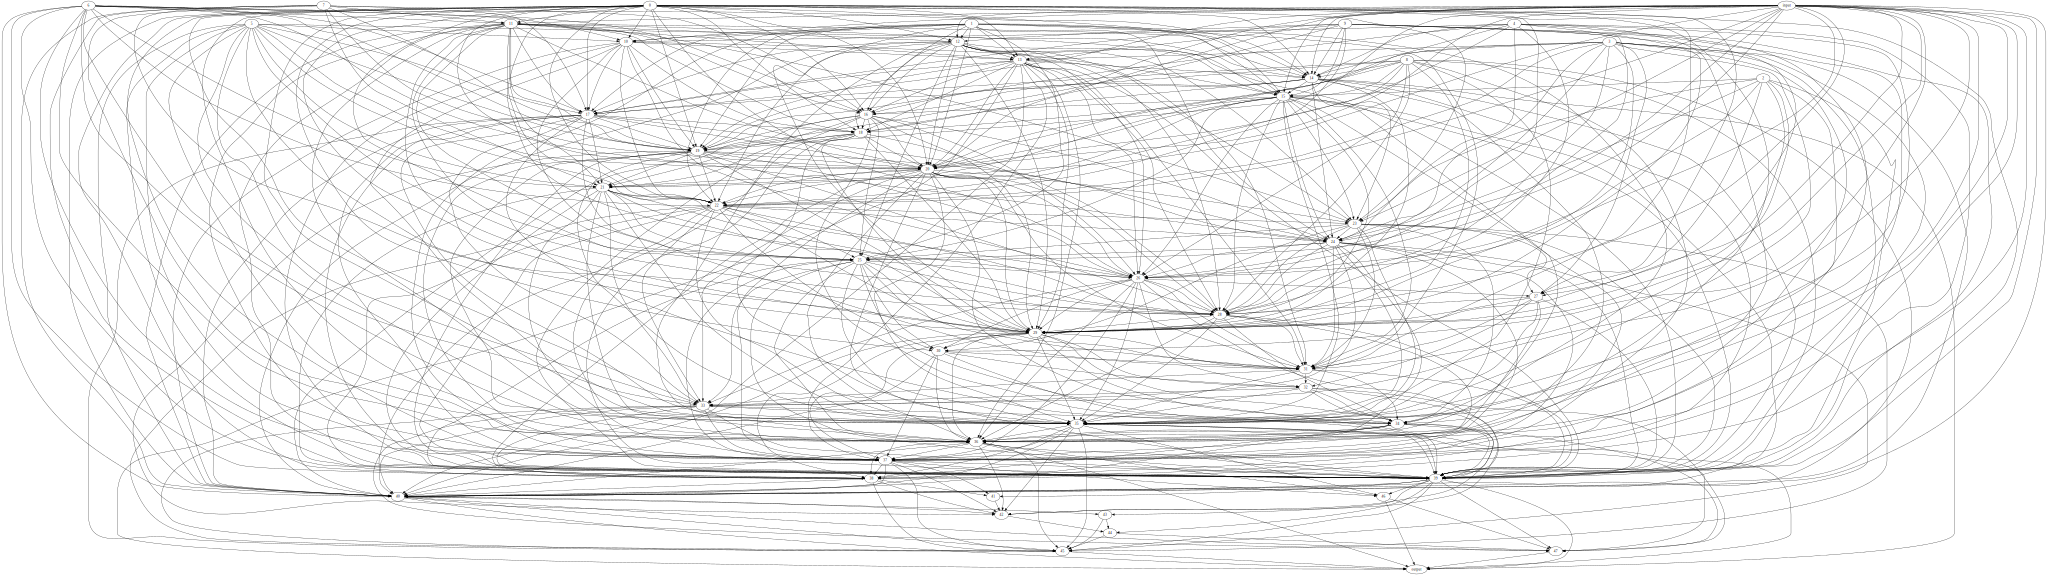

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 38.pkl
patching 675 edges, keeping 495 edges, 55 remain
patching 675 edges, keeping 495 edges, 55 remain
baseline score 3.1238107681274414
[10] sized edge sets remaining
got scores tensor([3.0713], device='cuda:0')
splitting 10 edges into two edge sets, as they have score 3.071275234222412 which has diff 0.0525355339050293 > 1e-05
patching 675 edges, keeping 495 edges, 55 remain
baseline score 3.1238107681274414
[5, 5] sized edge sets remaining
got scores tensor([3.0805, 3.1214], device='cuda:0')
splitting 5 edges into two edge sets, as they have score 3.0804595947265625 which has diff 0.043351173400878906 > 1e-05
splitting 5 edges into two edge sets, as they have score 3.1214349269866943 which has diff 0.0023758411407470703 > 1e-05
patching 675 edges, keeping 495 edges, 55 remain
baseline score 3.1238107681274414
[2, 3, 2, 3] sized edge sets remaining
got scores tensor([3.0796, 3.1263, 3.1239, 3.1218], device='cuda:0')
splitting

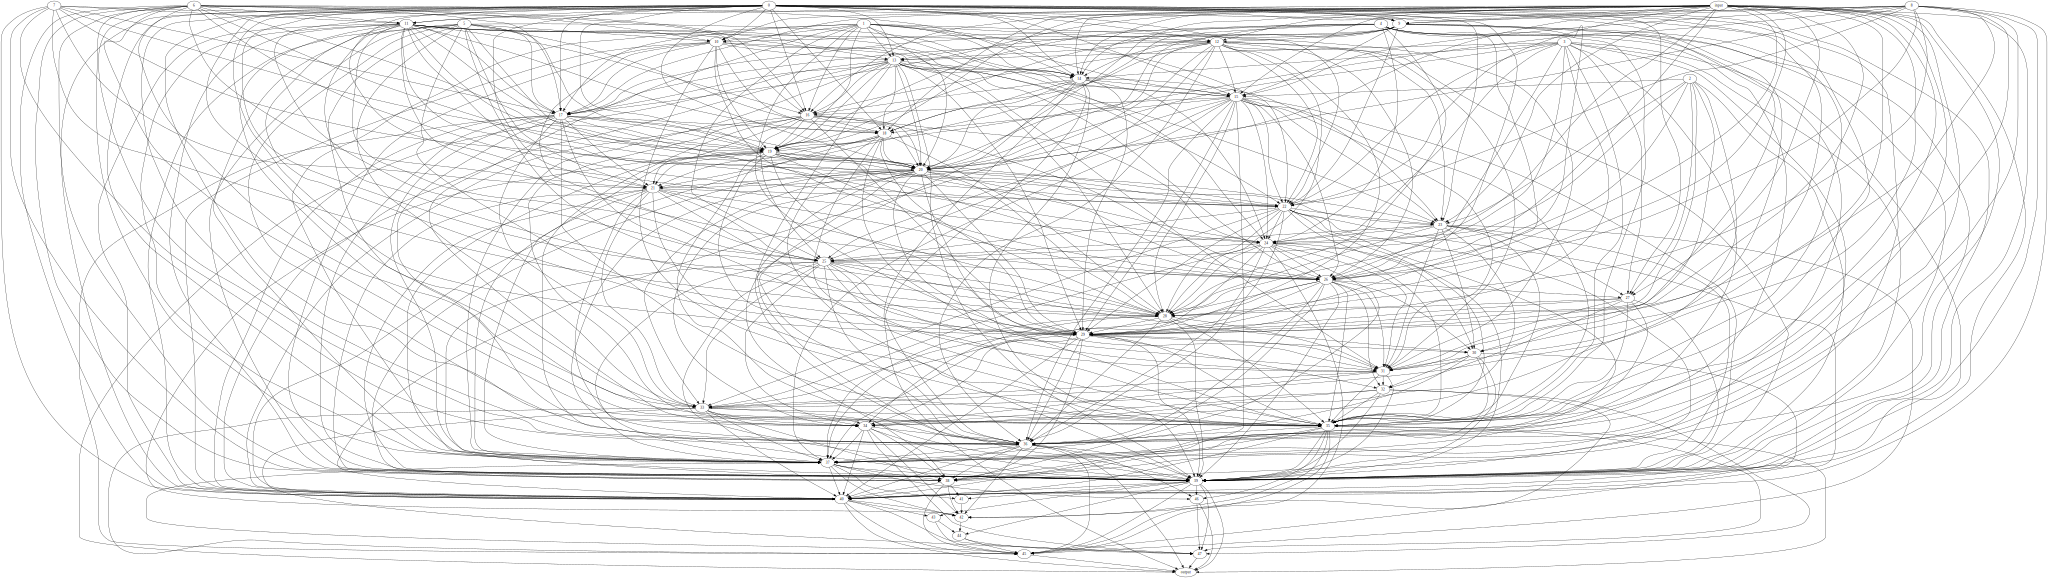

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 39.pkl
patching 681 edges, keeping 499 edges, 45 remain
patching 681 edges, keeping 499 edges, 45 remain
baseline score 3.1273467540740967
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining


  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.1145, 3.1057, 3.1247, 3.1254, 3.1289, 3.1263, 3.1276, 3.1289, 3.1301],
       device='cuda:0')
keeping edge edge  input -> 8 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.8.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.11452579498291 which has diff 0.012820959091186523 > 1e-05
keeping edge edge  0 -> 8 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.8.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.105674982070923 which has diff 0.021671772003173828 > 1e-05
keeping edge edge  1 -> 8 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.8.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1246609687805176 which has diff 0.0026857852935791016 > 1e-05
keeping edge edge  2 -> 8 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.8.hook_layer_inpu

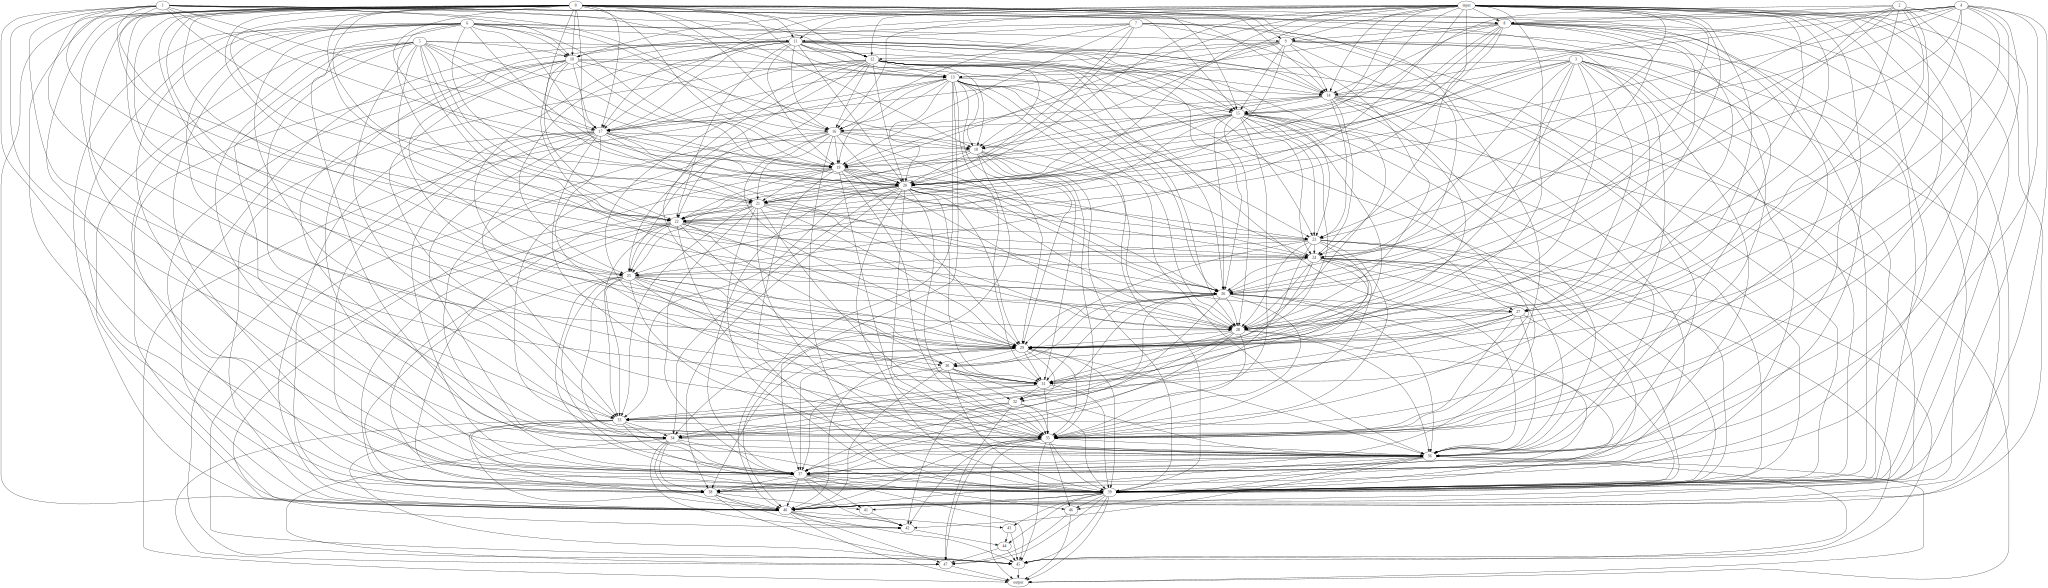

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 40.pkl
patching 685 edges, keeping 504 edges, 36 remain
patching 685 edges, keeping 504 edges, 36 remain
baseline score 3.133573532104492
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining


  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.1170, 3.0993, 3.1342, 3.1320, 3.1328, 3.1311, 3.1337, 3.1340],
       device='cuda:0')
keeping edge edge  input -> 7 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.7.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1170475482940674 which has diff 0.016525983810424805 > 1e-05
keeping edge edge  0 -> 7 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.7.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.0992839336395264 which has diff 0.03428959846496582 > 1e-05
keeping edge edge  2 -> 7 (('blocks.2.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.7.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1319668292999268 which has diff 0.0016067028045654297 > 1e-05
keeping edge edge  3 -> 7 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.7.hook_layer_input', <f

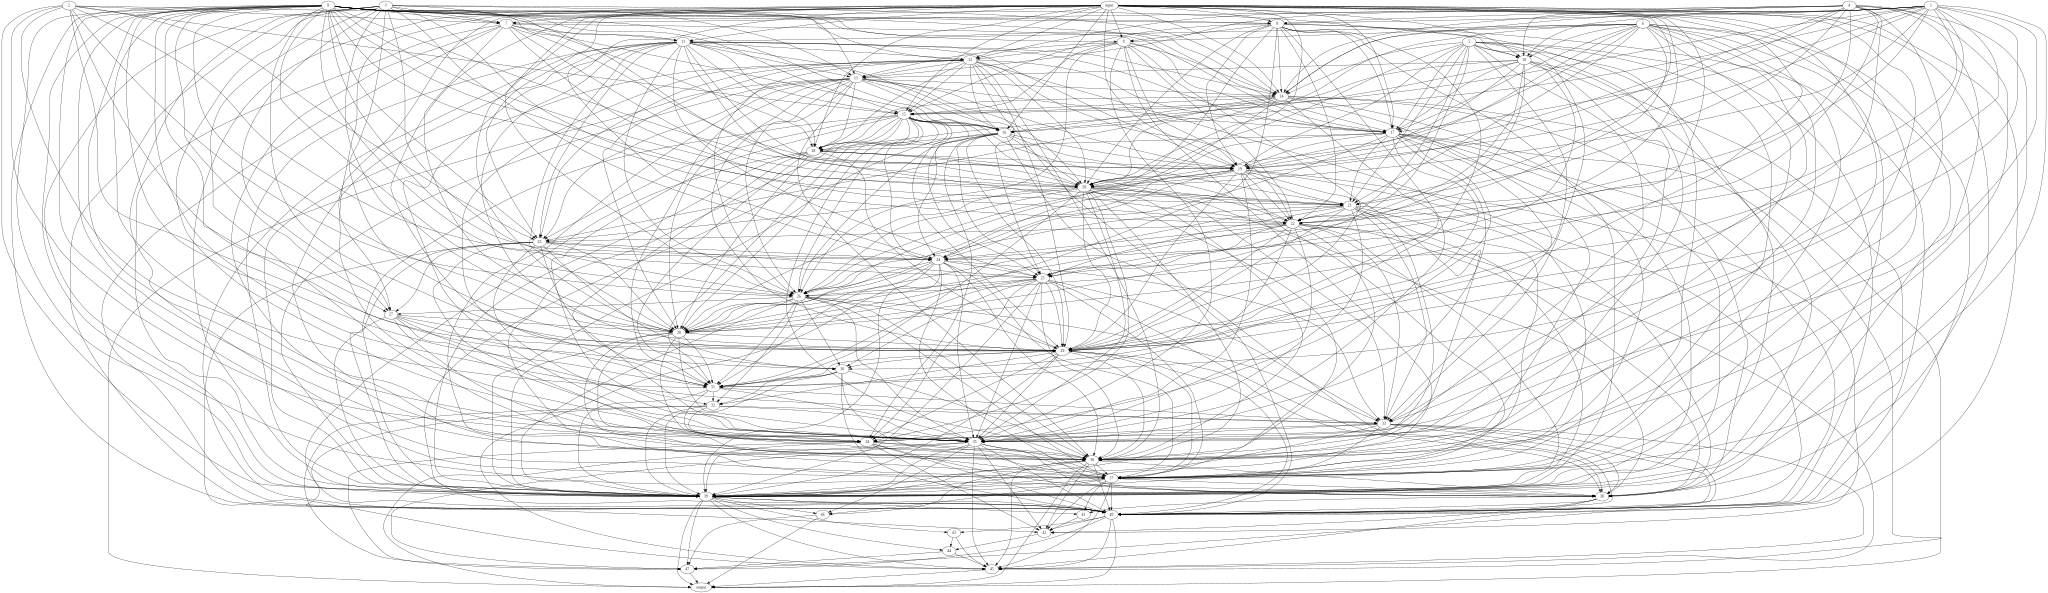

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 41.pkl
patching 688 edges, keeping 509 edges, 28 remain
patching 688 edges, keeping 509 edges, 28 remain
baseline score 3.1346092224121094
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining


  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([3.1250, 3.1056, 3.1342, 3.1349, 3.1331, 3.1360, 3.1363],
       device='cuda:0')
keeping edge edge  input -> 6 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.6.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.125039577484131 which has diff 0.009569644927978516 > 1e-05
keeping edge edge  0 -> 6 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.6.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1056127548217773 which has diff 0.02899646759033203 > 1e-05
keeping edge edge  1 -> 6 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.6.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1341700553894043 which has diff 0.0004391670227050781 > 1e-05
keeping edge edge  3 -> 6 (('blocks.3.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.6.hook_layer_input', <function r

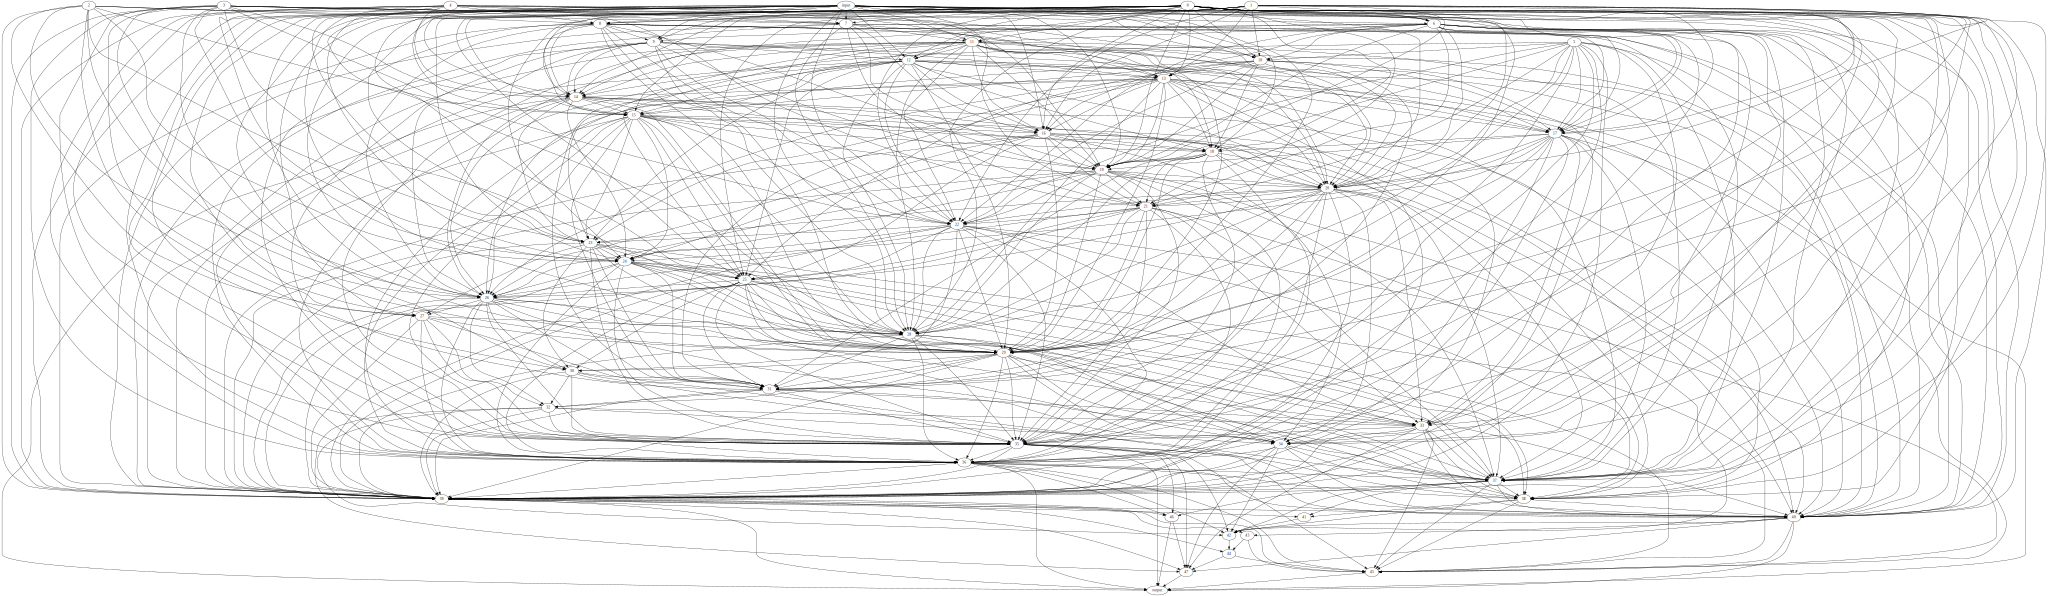

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 42.pkl
patching 691 edges, keeping 513 edges, 21 remain
patching 691 edges, keeping 513 edges, 21 remain
baseline score 3.137399911880493
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([3.1240, 3.1214, 3.1368, 3.1380, 3.1364, 3.1375], device='cuda:0')
keeping edge edge  input -> 5 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.5.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1239781379699707 which has diff 0.013421773910522461 > 1e-05
keeping edge edge  0 -> 5 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.5.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.12139892578125 which has diff 0.016000986099243164 > 1e-05
keeping edge edge  1 -> 5 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.5.hook_layer_input', <function resid_patching_hook at 0x7fb524c0

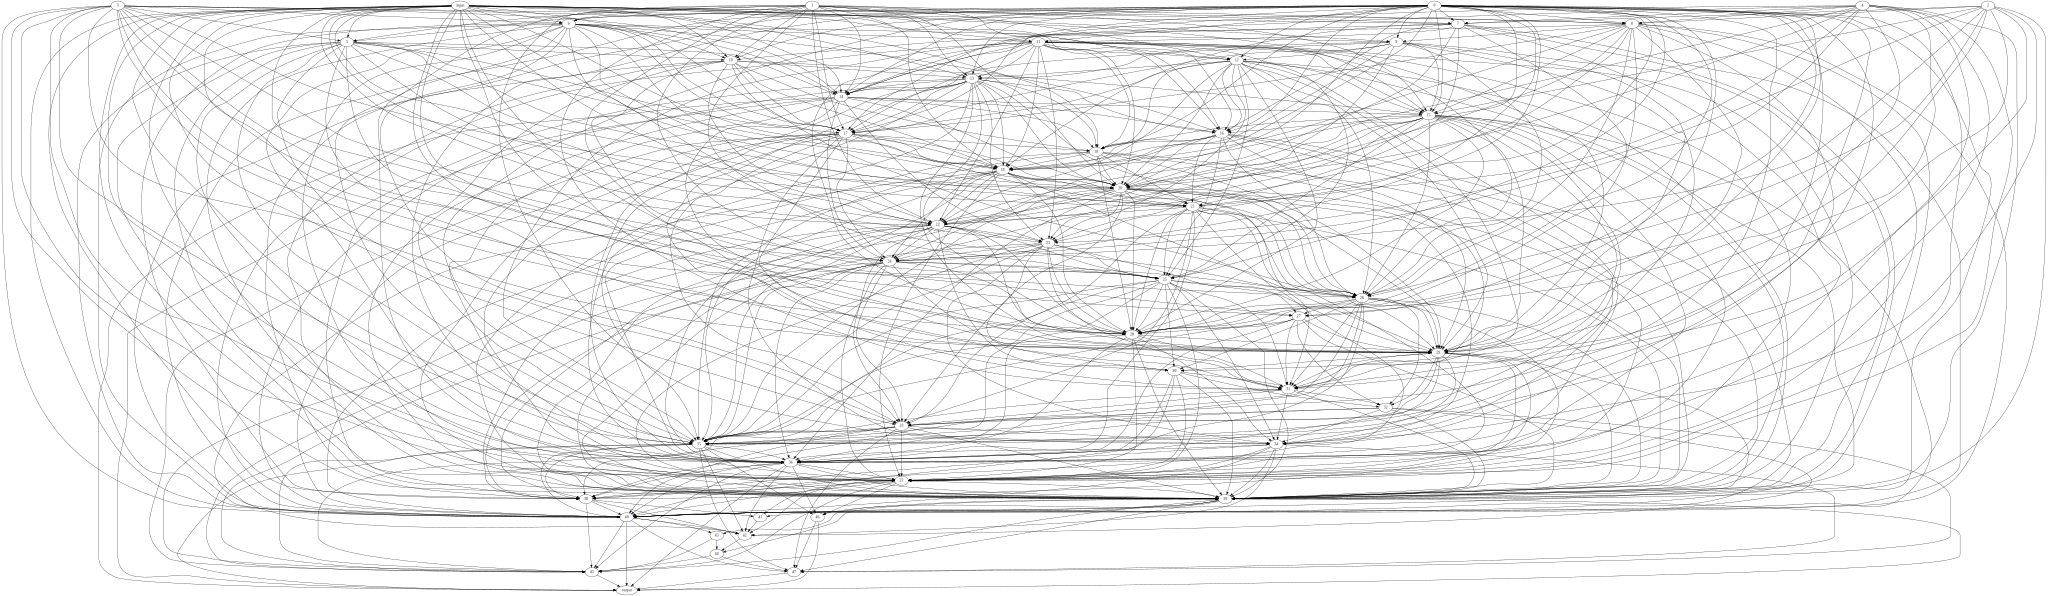

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 43.pkl
patching 693 edges, keeping 517 edges, 15 remain
patching 693 edges, keeping 517 edges, 15 remain
baseline score 3.1376805305480957
[1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([3.1350, 3.1200, 3.1356, 3.1382, 3.1329], device='cuda:0')
keeping edge edge  input -> 4 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.4.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1349937915802 which has diff 0.002686738967895508 > 1e-05
keeping edge edge  0 -> 4 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.4.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.119964122772217 which has diff 0.017716407775878906 > 1e-05
keeping edge edge  1 -> 4 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.4.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) wit

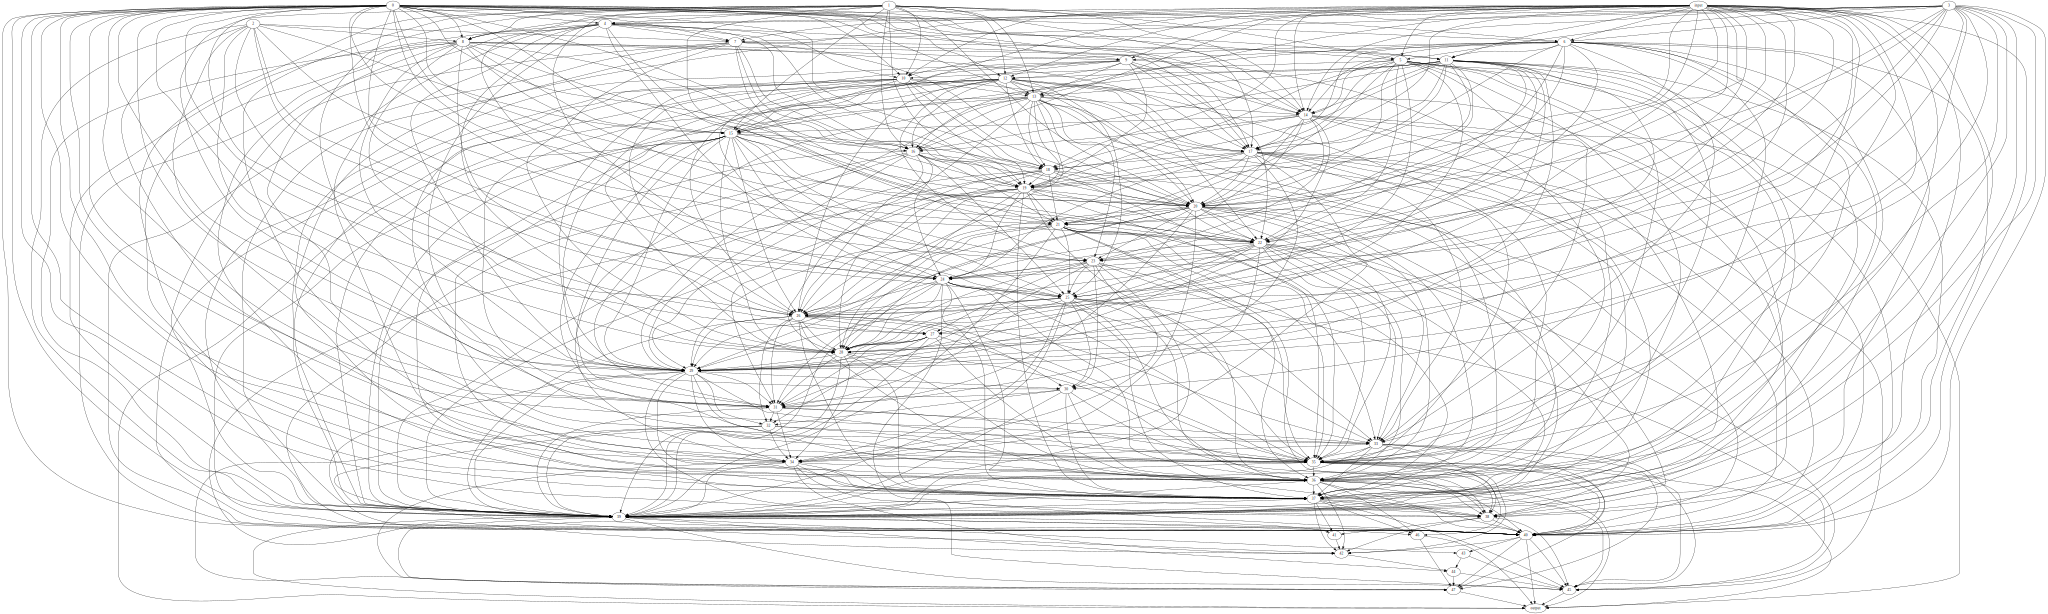

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 44.pkl
patching 694 edges, keeping 521 edges, 10 remain
patching 694 edges, keeping 521 edges, 10 remain
baseline score 3.13810658454895
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([3.1249, 3.1281, 3.1345, 3.1365], device='cuda:0')
keeping edge edge  input -> 3 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.3.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1248910427093506 which has diff 0.01321554183959961 > 1e-05
keeping edge edge  0 -> 3 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.3.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1280713081359863 which has diff 0.010035276412963867 > 1e-05
keeping edge edge  1 -> 3 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.3.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.

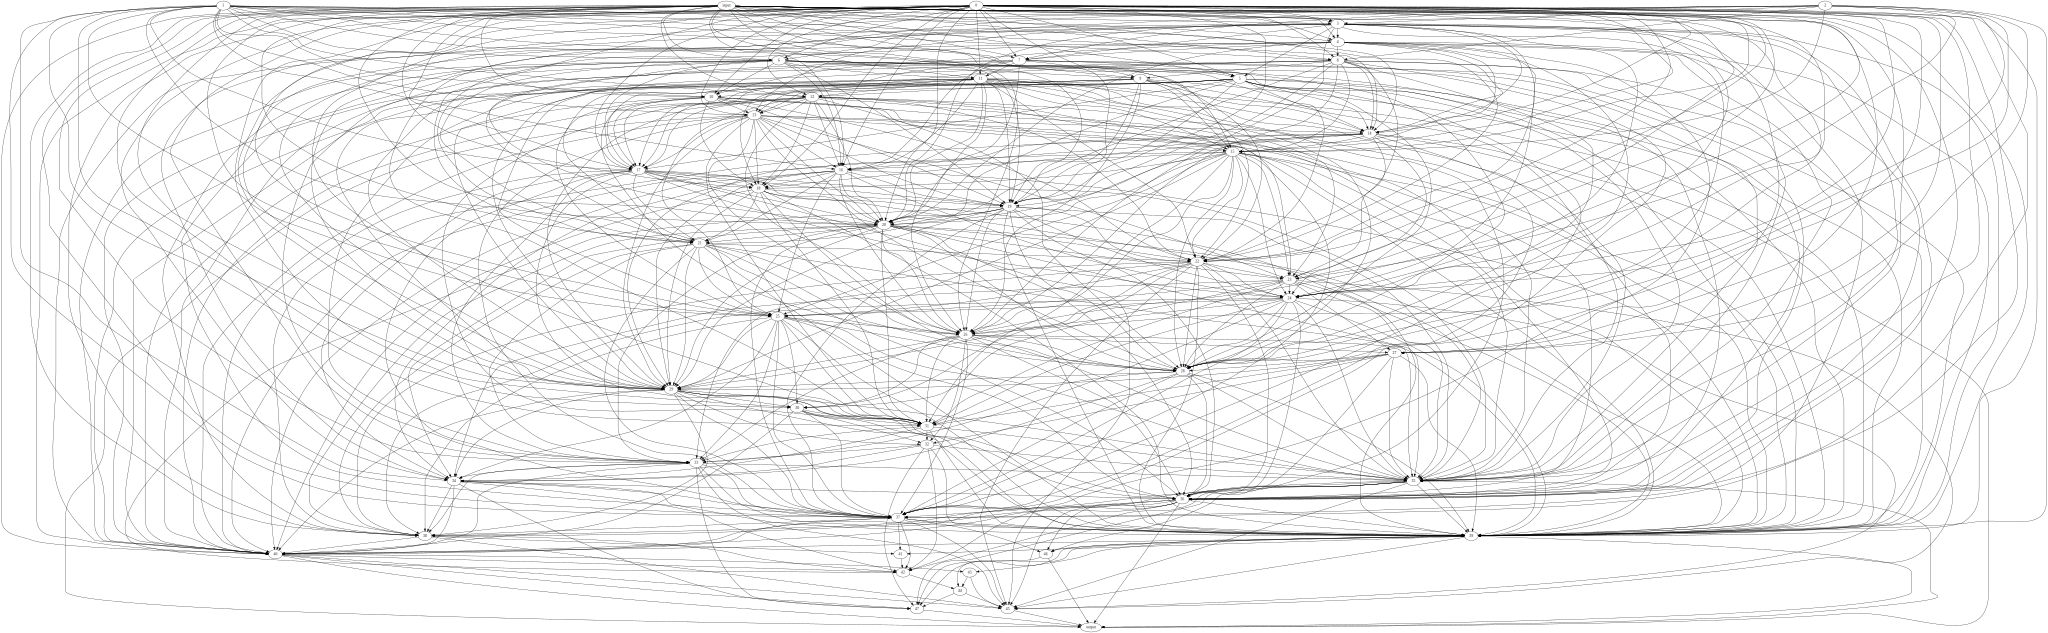

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 45.pkl
patching 694 edges, keeping 525 edges, 6 remain
patching 694 edges, keeping 525 edges, 6 remain
baseline score 3.13810658454895
[1, 1, 1] sized edge sets remaining
got scores tensor([3.1342, 3.1171, 3.1311], device='cuda:0')
keeping edge edge  input -> 2 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.2.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.134223222732544 which has diff 0.00388336181640625 > 1e-05
keeping edge edge  0 -> 2 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.2.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.11706280708313 which has diff 0.021043777465820312 > 1e-05
keeping edge edge  1 -> 2 (('blocks.1.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.2.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.131094217300415 

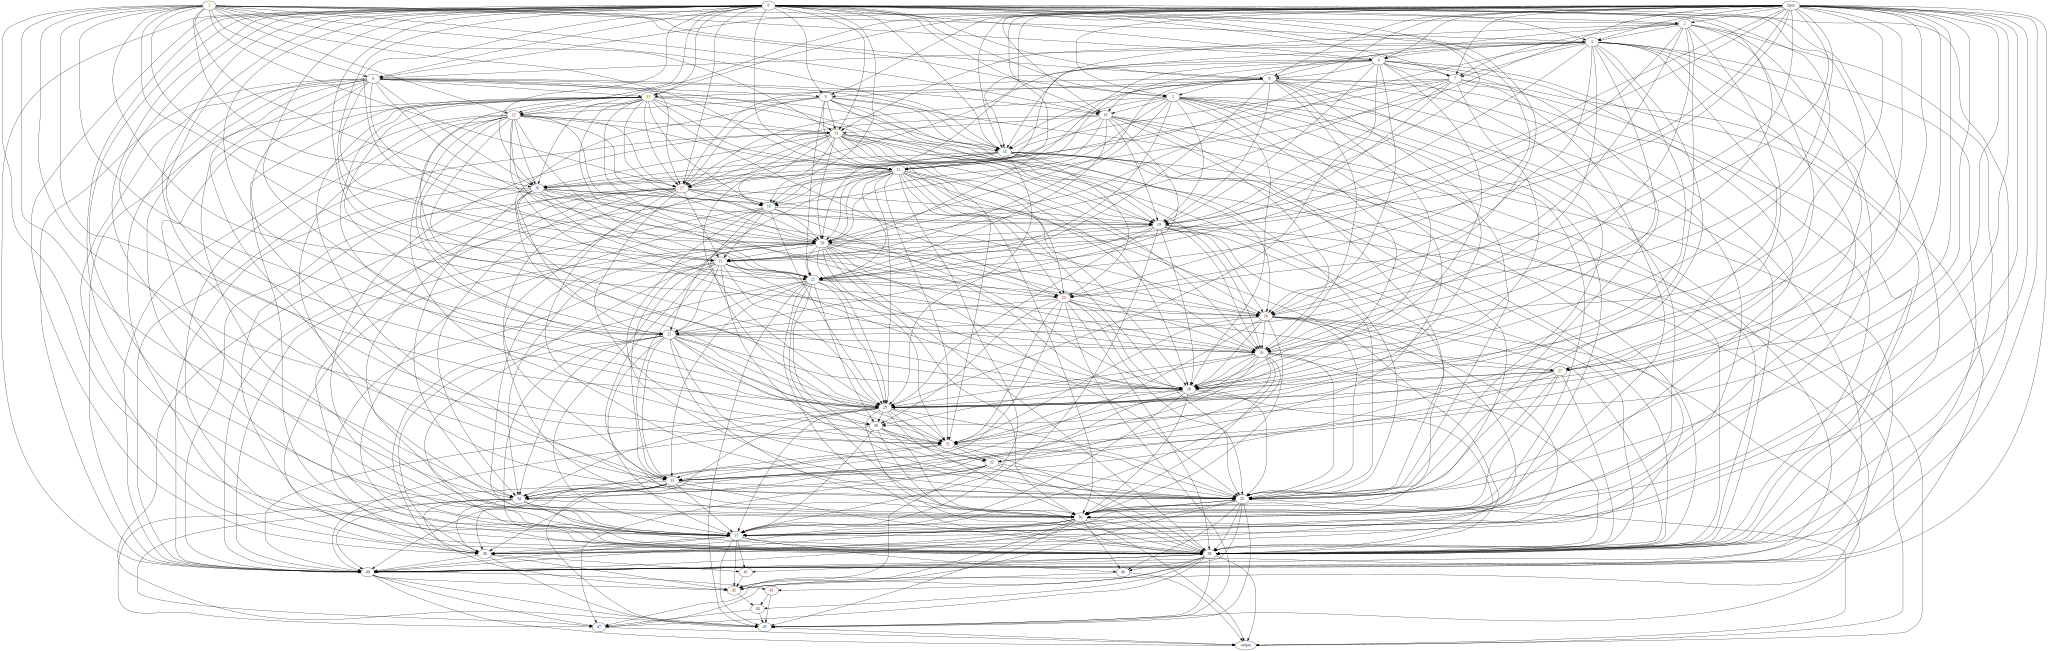

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 46.pkl
patching 694 edges, keeping 528 edges, 3 remain
patching 694 edges, keeping 528 edges, 3 remain
baseline score 3.13810658454895
[1, 1] sized edge sets remaining
got scores tensor([3.1548, 3.1196], device='cuda:0')
keeping edge edge  0 -> 1 (('blocks.0.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.1.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 3.1196465492248535 which has diff 0.01846003532409668 > 1e-05
doing rollback test with score 3.1548454761505127 and score_lost_by_edge_set -0.0167388916015625 with edge set of size 1
rolling back with pivot 1
patching 1 edges with score 3.1548454761505127 with diff of -0.0167388916015625
but patching with others at the same time, overall they have score 3.1547658443450928 with diff of -0.016659259796142578
finished these edge sets
valid score 2.3069615364074707 valid acc 0.9300000071525574


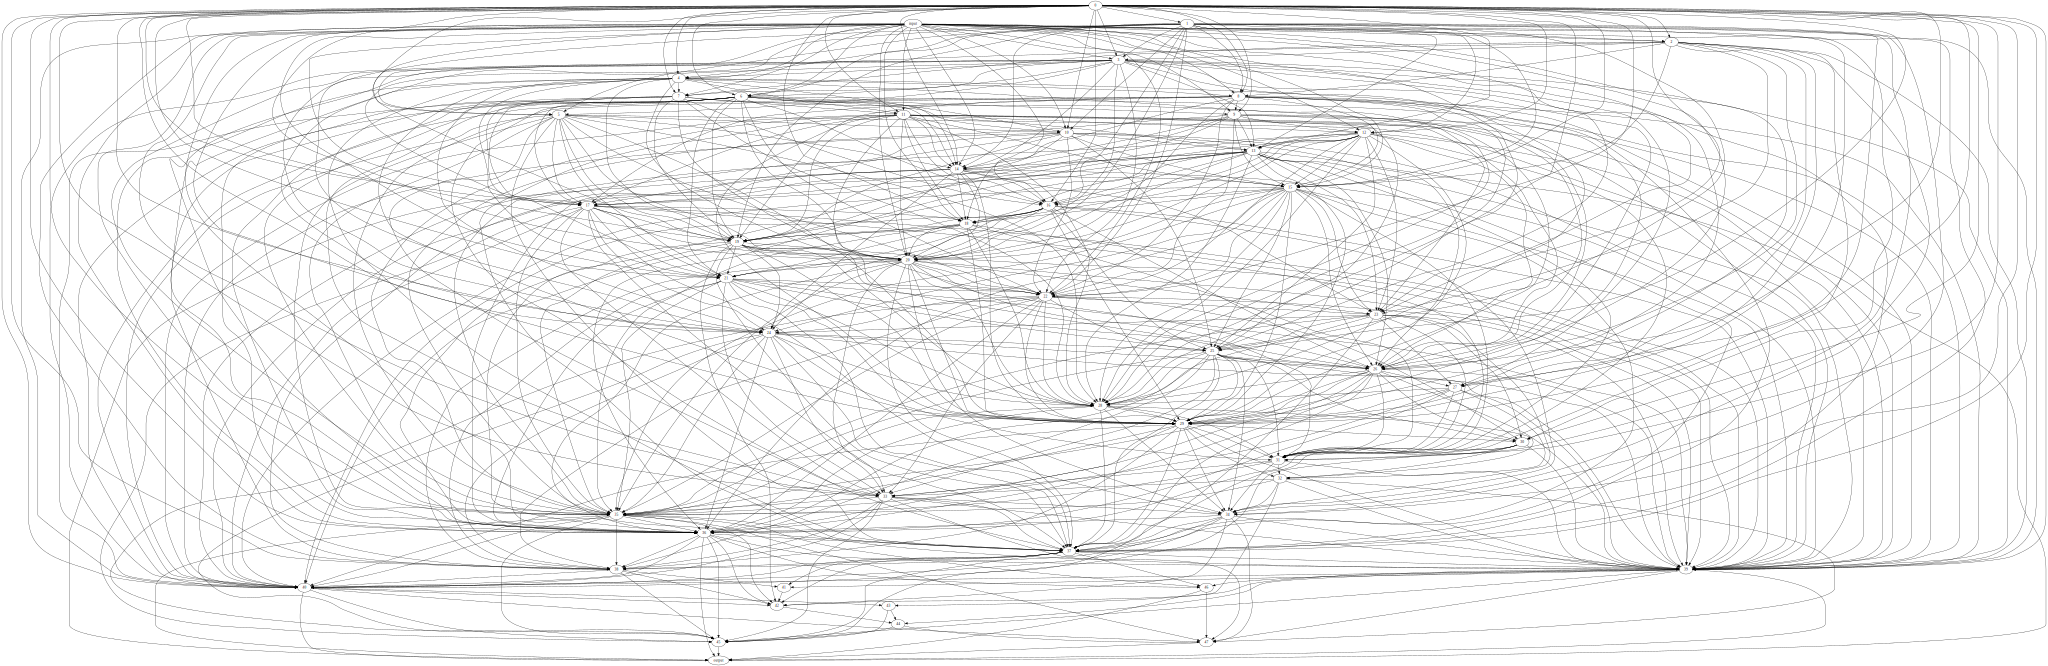

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 47.pkl
patching 695 edges, keeping 529 edges, 1 remain
patching 695 edges, keeping 529 edges, 1 remain
baseline score 3.1547658443450928
[1] sized edge sets remaining
got scores tensor([0.5659], device='cuda:0')
keeping edge edge  input -> 0 (('hook_embed', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.0.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 0.565897524356842 which has diff 2.5888683795928955 > 1e-05
finished these edge sets
valid score 2.3069615364074707 valid acc 0.9300000071525574


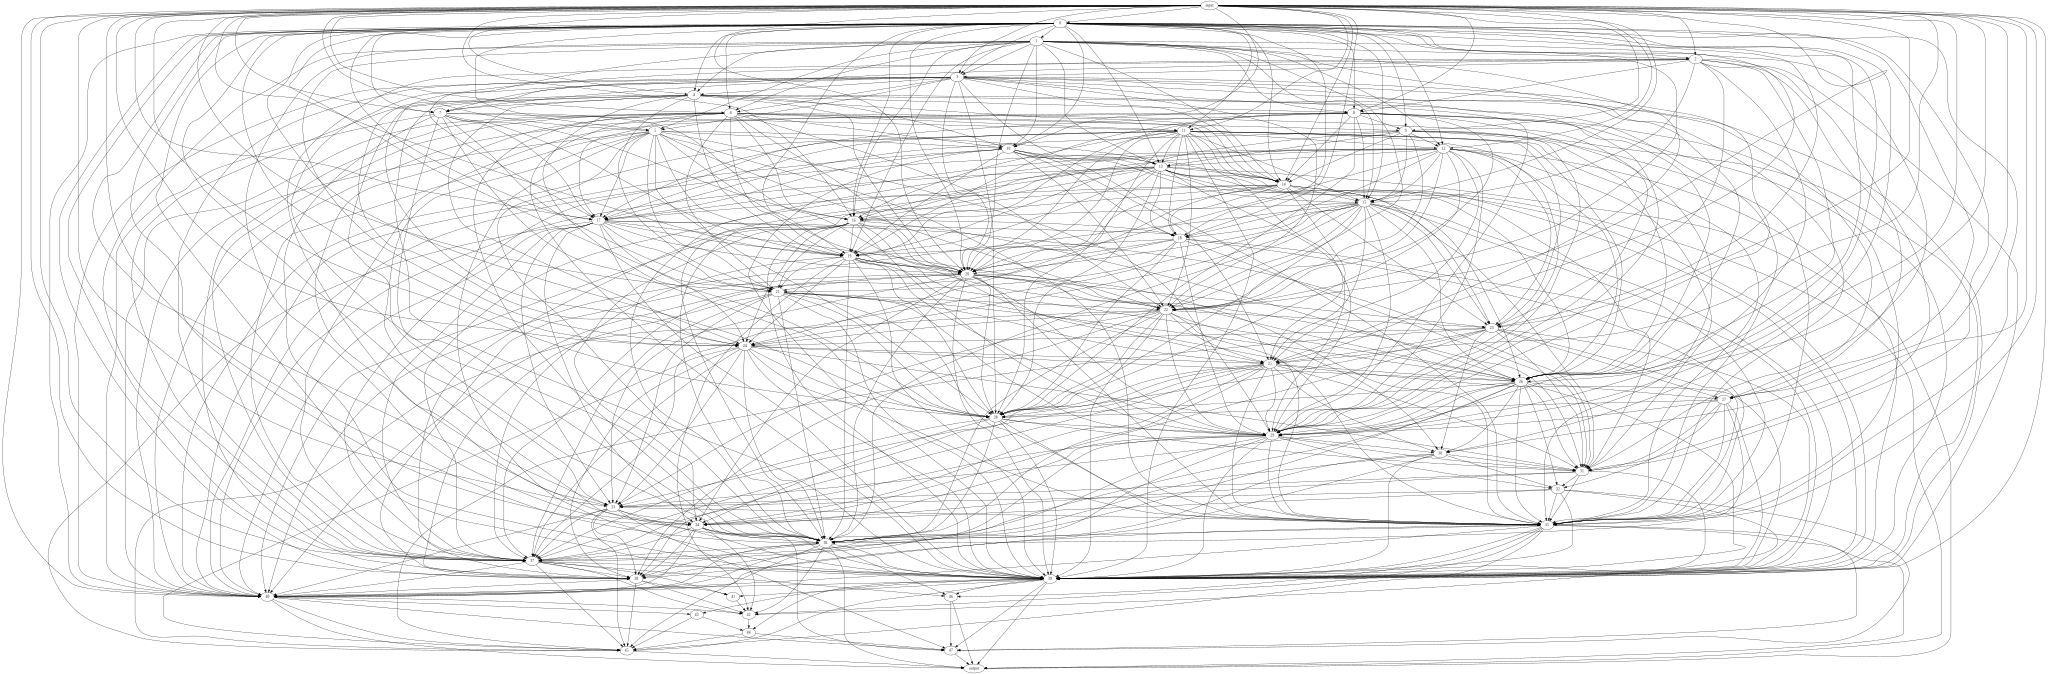

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 48.pkl
final output:


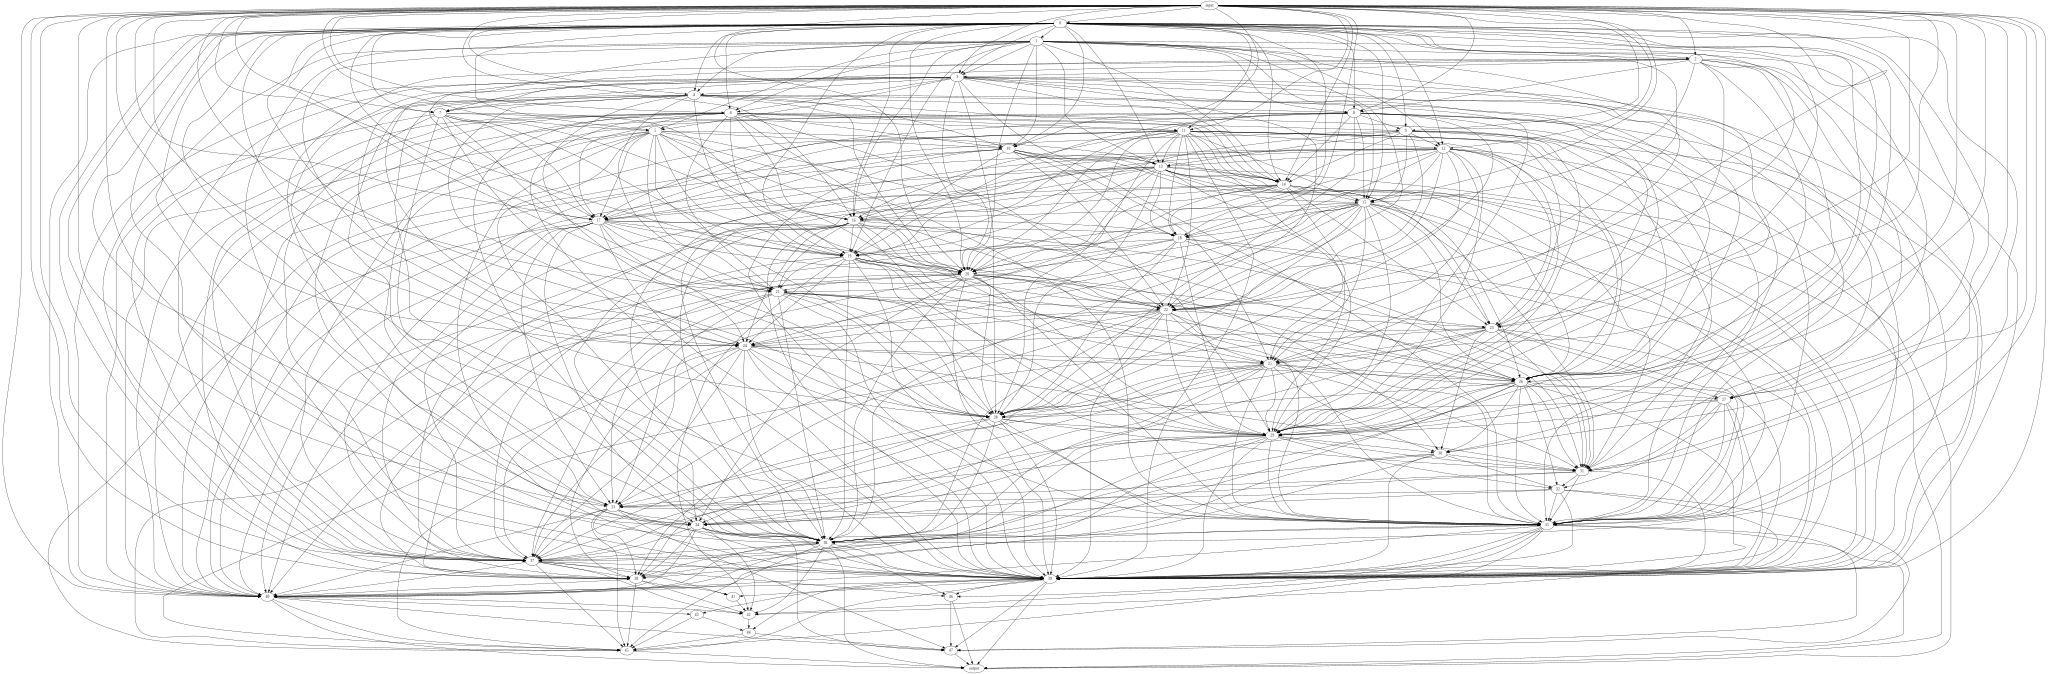

final score 3.1547658443450928
saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint final.pkl


In [4]:
from transformer_lens.hook_points import HookPoint
from acdc import Edge, ACDCConfig, LOG_LEVEL_INFO, LOG_LEVEL_DEBUG, run_acdc

global storage
storage = {}
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    return x

layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []

B,L = data.data.size()

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'input'

last_layer = max(layers)
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def layer_node(layer):
    return f'{layer}'

# direct connection from embed to output
edges.append(Edge(
        input_node=INPUT_NODE,
        input_hook=(INPUT_HOOK, storage_hook),
        output_node=OUTPUT_NODE,
        output_hook=(OUTPUT_HOOK, resid_patching_hook),
))

for layer in layers:
    # edge from embed to layer input
    edges.append(Edge(
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=layer_node(layer),
            output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
    ))

    # edge from some other earlier layer to this layer
    for other_layer in layers:
        if other_layer < layer:
            edges.append(Edge(
                    input_node=layer_node(other_layer),
                    input_hook=(f'blocks.{other_layer}.hook_out_proj', storage_hook),
                    output_node=layer_node(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
            ))

    # edge from layer output to final layer output
    edges.append(Edge(
            input_node=layer_node(layer),
            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, resid_patching_hook),
    ))

model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
}


def normalized_logit_diff_metric(data: ACDCEvalData):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
    
    
cfg = ACDCConfig(
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    metric=normalized_logit_diff_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=3,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)

result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)



